In [ ]:
from IPython.display import clear_output
!pip install datasets
!pip install arabic-reshaper python-bidi
clear_output()

In [ ]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import datasets
from datasets import load_dataset
import transformers
from transformers import BertTokenizer, AutoModel,BertModel
from google.colab import drive
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from bidi.algorithm import get_display
import arabic_reshaper
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
random.seed(0)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
#data loading and preprocessing
class ExpoDataset_BERT(Dataset):
  def __init__(self,dataset_path,onehotencoder=None,tokenizer_name='UBC-NLP/MARBERT'):
    expodataset_features=datasets.Features({'Tweet':datasets.Value('string'),'Class':datasets.Value('string')})
    self.dataset=load_dataset("csv", data_files=dataset_path,features=expodataset_features,split='train')
    self.tokenizer=BertTokenizer.from_pretrained(tokenizer_name)
    self.onehotencoder=onehotencoder if onehotencoder else OneHotEncoder()
    self.onehotencoder.fit(np.reshape(self.dataset[:]['Class'],(-1,1)))
  def __len__(self):
    return len(self.dataset)

  def __getitem__(self,idx):
    item=self.tokenizer(str(self.dataset[idx]['Tweet']),add_special_tokens=True,max_length=44,padding='max_length',truncation=True,return_tensors='pt')

    item['label']=torch.tensor(self.onehotencoder.transform([[self.dataset[idx]['Class']]]).toarray())[0]
    item['input_ids']=item['input_ids'][0]
    item['attention_mask']=item['attention_mask'][0]
    return item

In [ ]:
dataset=ExpoDataset_BERT('/content/drive/MyDrive/SeniorProject1/data/experiment/SP2_new_training_set.csv')
test_dataset=ExpoDataset_BERT('/content/drive/MyDrive/SeniorProject1/data/experiment/SP2_new_testing_set.csv',dataset.onehotencoder)

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
print(dataset[0])

{'input_ids': tensor([    2, 37540,  9242,  9703,  1018,  9007,  3580, 37784,  4818,  8671,
        45938, 16667, 22418, 38976,  1046,  8385, 50291, 57732, 65864,  2002,
        40973, 50045,  1017, 28555,  3781,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'label': tensor([1., 0., 0.], dtype=torch.float64)}


In [ ]:
seed = torch.Generator().manual_seed(42)
train_set,val_set=torch.utils.data.random_split(dataset,[0.85,0.15], generator=seed)
len(train_set),len(val_set)

(6375, 1125)

In [ ]:
full_dataloader=DataLoader(dataset,pin_memory=True,num_workers=8,batch_size=64,shuffle=True)
train_loader=DataLoader(train_set,pin_memory=True,num_workers=8,batch_size=64,shuffle=True)
val_loader=DataLoader(val_set,pin_memory=True,num_workers=8,batch_size=64,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
class RNN_AraBERT(nn.Module):
  def __init__(self,hidden_size1,hidden_size2,num_layers,dider=True,droprate=0.2,num_classes=3):
    super().__init__()
    self.bert=BertModel.from_pretrained('UBC-NLP/MARBERT')
    # freeze the bert weights
    for param in self.bert.parameters():
      param.requires_grad=False

    self.embedding_dim=self.bert.config.hidden_size
    self.rnn_hidden_size=hidden_size1
    self.rnn=nn.LSTM(self.embedding_dim,hidden_size1,num_layers,batch_first=True,bidirectional=dider)
    self.dropout=nn.Dropout(droprate)
    self.d=2 if dider else 1
    #self.fc1=nn.Linear(hidden_size1*self.d,num_classes)
    self.fc1=nn.Linear(hidden_size1*self.d,hidden_size2)
    self.fc2=nn.Linear(hidden_size2,num_classes)

    # For Improvements, I've changed the intialization algorithm
    #initliazed the rnn weights
    for name,param in self.rnn.named_parameters():
      if 'weight' in name:
        nn.init.xavier_normal_(param)
    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.xavier_normal_(self.fc2.weight)
  def forward(self,input_ids,attention_mask):
    with torch.no_grad():
      embeddings=self.bert(input_ids,attention_mask)
    x=embeddings[0]
    x=self.dropout(x)
    x,h=self.rnn(x)
    x=F.relu(x)
    x=self.fc1(x[:,-1,:])
    x=F.relu(x)
    x=self.dropout(x)
    x=self.fc2(x)
    return x

In [ ]:
#helper function to automate the loss and accuracy plots
def plot_loss_accuracy(train_total_loss,val_total_loss,train_accuracies,val_accuracies):
  plt.subplots(figsize=(12,4))
  plt.subplot(121)
  plt.plot(train_total_loss,label='train')
  if len(val_total_loss)!=0:
    plt.plot(val_total_loss,label='val')
  plt.title('Losses')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(122)
  plt.plot(train_accuracies,label='train')
  if len(val_accuracies)!=0:
    plt.plot(val_accuracies,label='val')
  plt.title('Accuracies')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
def visualize(text_ids,weights,predictions,labels):

  positives_weights = weights[labels == 2]
  negatives_weights = weights[labels == 0]
  neutrals_weights = weights[labels == 1]

  positives_text_ids = text_ids[labels == 2]
  negatives_text_ids = text_ids[labels == 0]
  neutrals_text_ids = text_ids[labels == 1]

  # Randomly selecting indices for each class
  positive_indices = np.random.choice(np.arange(len(positives_weights)), size=1)
  negative_indices = np.random.choice(np.arange(len(negatives_weights)), size=1)
  neutral_indices = np.random.choice(np.arange(len(neutrals_weights)), size=1)

  fig, axs = plt.subplots(3, figsize=(10, 6))
  #axs = [axs]  # Ensure axs is iterable if there's only one plot
  #print('axs=',type(axs[0]),axs[0])
  # Function to plot heatmaps for a given class
  def plot_heatmaps(indecies, text_ids_, weights_, ax_row):
      for index in indecies:
          text = dataset.tokenizer.decode(text_ids_[index]).split(' ')
          reshaped_text = [arabic_reshaper.reshape(token) for token in text]
          bidi_text = [get_display(token) for token in reshaped_text]
          correct_weight = weights_[index]

          # Create the heatmap for the current index
          heatmap = axs[ax_row].imshow([correct_weight], cmap='YlGnBu', aspect='auto')

          # Set the tokens as x-ticks
          axs[ax_row].set_xticks(np.arange(len(bidi_text)))
          axs[ax_row].set_xticklabels(bidi_text, rotation=90)

          # Remove y-ticks
          axs[ax_row].set_yticks([])
      plt.tight_layout()
      return heatmap

  # Plot heatmaps for positive, negative, and neutral predictions
  heatmap=plot_heatmaps(negative_indices, negatives_text_ids, negatives_weights, 0)  # Row 0 for negative
  heatmap=plot_heatmaps(neutral_indices, neutrals_text_ids, neutrals_weights, 1)  # Row 1 for neutral
  heatmap=plot_heatmaps(positive_indices, positives_text_ids, positives_weights, 2)     # Row 2 for positive

  # Set overall titles for each row
  axs[0].set_ylabel('Negative', rotation=0, labelpad=50, fontsize=12)
  axs[1].set_ylabel('Neutral', rotation=0, labelpad=50, fontsize=12)
  axs[2].set_ylabel('Positive', rotation=0, labelpad=50, fontsize=12)

  # Create a single color bar for the entire figure
  cbar_ax = fig.add_axes([1, 0.15, 0.01, 0.8])  # [left, bottom, width, height]
  plt.colorbar(heatmap, cax=cbar_ax)

  plt.suptitle('Attention Weights', fontsize=16, x=0.5, y=1.02)  # Adjust the y-position for the title
  #plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the title
  plt.show()

In [ ]:
# Test on the test_loader
def test_and_report(model,test_loader,model_name,attention_added=False):
  model.eval()
  predictions=[]
  labels=[]
  test_total_dataitem=0
  test_correct=0
  input_ids_list=[]
  attention_weights=[]
  correct_answers=[]
  all_labels=[]
  with torch.no_grad():
      for batch in test_loader:
          input_ids,attention_mask,label=batch.input_ids.to(device),batch.attention_mask.to(device),batch.label.to(device)
          output=model(input_ids,attention_mask)
          if attention_added:
            attention_weights.extend(output[1].cpu().numpy())
            output=output[0]



          # Compute the accuracy
          y_pred=F.softmax(output,dim=1)
          predicted = y_pred.argmax(axis=1)
          test_total_dataitem += label.size(0)
          test_correct += (predicted == label.argmax(axis=1)).sum()
          predictions.extend(predicted.cpu().numpy())
          labels.extend(label.argmax(axis=1).cpu().numpy())

          input_ids_list.extend(input_ids.cpu().numpy())
          all_labels.extend(label.argmax(axis=1).cpu().numpy())
          correct_answers.extend((predicted == label.argmax(axis=1)).cpu().numpy())


  test_accuracy = test_correct/test_total_dataitem
  print(f'Test correct = {test_correct}\n')
  print(f'Test total dataitem = {test_total_dataitem}\n')
  print(f'Test Accuracy = {test_accuracy}\n')
  print(classification_report(labels,predictions,target_names=['negative','neutral','positive']))
  fig,ax=plt.subplots(figsize=(5, 5))
  ConfusionMatrixDisplay.from_predictions(labels,predictions,display_labels=['negative','neutral','positive'],normalize='pred',cmap=plt.cm.Blues, xticks_rotation='vertical',ax=ax)
  plt.title(f'Confusion Matrix of {model_name}')
  plt.show()
  if attention_added:
    visualize(np.array(input_ids_list),np.array(attention_weights),correct_answers,np.array(all_labels))

In [ ]:
#helper function to automate the training loop
def train(model,epochs,optimizer,criterion,train_loader,val_loader=None,attention_added=False):
  train_total_loss=[]
  val_total_loss=[]
  train_accuracies=[]
  val_accuracies=[]
  for epoch in range(epochs):
    train_losses=0
    val_losses=0
    train_total_dataitem=0
    train_correct=0
    tqdm_par=tqdm(train_loader,desc=f'Epoch {epoch+1}')
    #tqdm_par.set_description(f'Epoch {epoch+1}')
    model.train() #training mode
    for batch in tqdm_par:
      input_ids,attention_mask,label=batch.input_ids.to(device),batch.attention_mask.to(device),batch.label.to(device)
      output=model(input_ids,attention_mask)
      if attention_added:
        output=output[0]
      train_loss=criterion(output,label)
      optimizer.zero_grad()
      train_losses+=train_loss.item()
      train_loss.backward()
      optimizer.step()
      # Compute the accuracy
      y_pred=F.softmax(output,dim=1)
      predicted = y_pred.argmax(axis=1)
      train_total_dataitem += label.size(0)
      train_correct += (predicted == label.argmax(axis=1)).sum()
    train_accuracy = train_correct / train_total_dataitem

    if val_loader:
      model.eval() #evaluation mode
      with torch.no_grad():
        val_total_dataitem=0
        val_correct=0
        for batch in val_loader:
          input_ids,attention_mask,label=batch.input_ids.to(device),batch.attention_mask.to(device),batch.label.to(device)
          output=model(input_ids,attention_mask)
          if attention_added:
            output=output[0]
          val_loss=criterion(output,label)
          val_losses+=val_loss.item()
          # Compute the accuracy
          y_pred=F.softmax(output,dim=1)
          predicted = y_pred.argmax(axis=1)
          val_total_dataitem += label.size(0)
          val_correct += (predicted == label.argmax(axis=1)).sum()
      val_accuracy = val_correct/val_total_dataitem

    tqdm_par.refresh()
    train_total_loss.append(train_losses/len(train_loader))
    train_accuracies.append(train_accuracy.cpu())
    if val_accuracy>=0.77:
      torch.save(model.state_dict(),f'/content/drive/MyDrive/SeniorProject1/models/MARBERT+Attention-LSTM77.pth')
      print(f"A model was saved at accuracy = {val_accuracy}")
    if val_loader:
      val_total_loss.append(val_losses/len(val_loader))
      val_accuracies.append(val_accuracy.cpu())
      print(f'loss = {train_losses/len(train_loader)}, val_loss ={val_losses/len(val_loader)}, accuracy = {train_accuracy}, val_accuracy = {val_accuracy}')
    else:
      print(f'loss = {train_losses/len(train_loader)}, accuracy = {train_accuracy}')

  plot_loss_accuracy(train_total_loss,val_total_loss,train_accuracies,val_accuracies)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"You're on a {device}")
#hyperparameter
bidirectional=True
num_layers=4
hidden_size1=256
hidden_size2=256
learning_rate=0.008
droprate=0.4
epoch=7
model=RNN_AraBERT(hidden_size1,hidden_size2,num_layers,bidirectional,droprate).to(device,non_blocking=True)
optimizer=optim.Adam(model.parameters(),lr=learning_rate) # play around this also
criterion=nn.CrossEntropyLoss()
#train(model,epoch,optimizer,criterion,train_loader,val_loader)
#model_name='MARBERT+GRU'
#test_and_report(model,test_loader,model_name)

You're on a cuda


Test correct = 250

Test total dataitem = 750

Test Accuracy = 0.3333333432674408

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       250
     neutral       0.00      0.00      0.00       250
    positive       0.33      1.00      0.50       250

    accuracy                           0.33       750
   macro avg       0.11      0.33      0.17       750
weighted avg       0.11      0.33      0.17       750



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


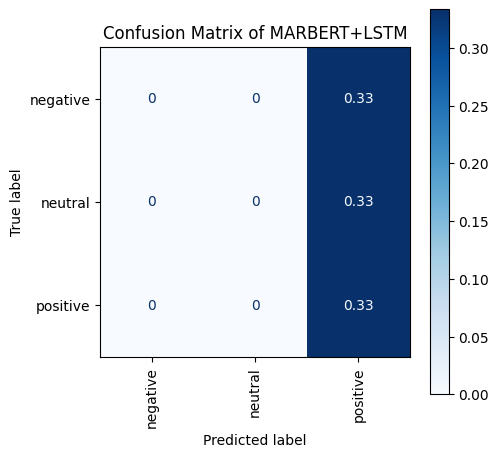

In [ ]:
#hyperparameter
bidirectional=True
num_layers=1
hidden_size1=64
hidden_size2=256
learning_rate=0.002
droprate=0.5
epoch=10
model_name='MARBERT+LSTM'
test_and_report(model,test_loader,model_name)

### Hyperparameter Tuning

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


loss = 0.9145197442112317, val_loss =0.6987834768530607, accuracy = 0.5429019927978516, val_accuracy = 0.648888885974884


Epoch 2: 100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


loss = 0.6646532295777041, val_loss =0.582790526641846, accuracy = 0.7286274433135986, val_accuracy = 0.7617777585983276


Epoch 3: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


loss = 0.5965615257049705, val_loss =0.5614953528216224, accuracy = 0.7592157125473022, val_accuracy = 0.7644444704055786


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  6.20it/s]


loss = 0.5550284663139722, val_loss =0.5312044487747354, accuracy = 0.7709804177284241, val_accuracy = 0.7724444270133972


Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


A model was saved at accuracy = 0.7902222275733948
loss = 0.5362056935370614, val_loss =0.5003145620061327, accuracy = 0.7830588221549988, val_accuracy = 0.7902222275733948


Epoch 6: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


loss = 0.49960033299323603, val_loss =0.5041100468558148, accuracy = 0.7937254905700684, val_accuracy = 0.7831110954284668


Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


A model was saved at accuracy = 0.800000011920929
loss = 0.47397866309016723, val_loss =0.47647794221202905, accuracy = 0.8045490384101868, val_accuracy = 0.800000011920929


Epoch 8: 100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


A model was saved at accuracy = 0.8124444484710693
loss = 0.46591435997848535, val_loss =0.463761301174638, accuracy = 0.814431369304657, val_accuracy = 0.8124444484710693


Epoch 9: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


A model was saved at accuracy = 0.8053333163261414
loss = 0.45480685681933586, val_loss =0.503262230341307, accuracy = 0.8156862854957581, val_accuracy = 0.8053333163261414


Epoch 10: 100%|██████████| 100/100 [00:20<00:00,  5.00it/s]


loss = 0.45772692808209625, val_loss =0.6274531712341203, accuracy = 0.8119215965270996, val_accuracy = 0.7368888854980469


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


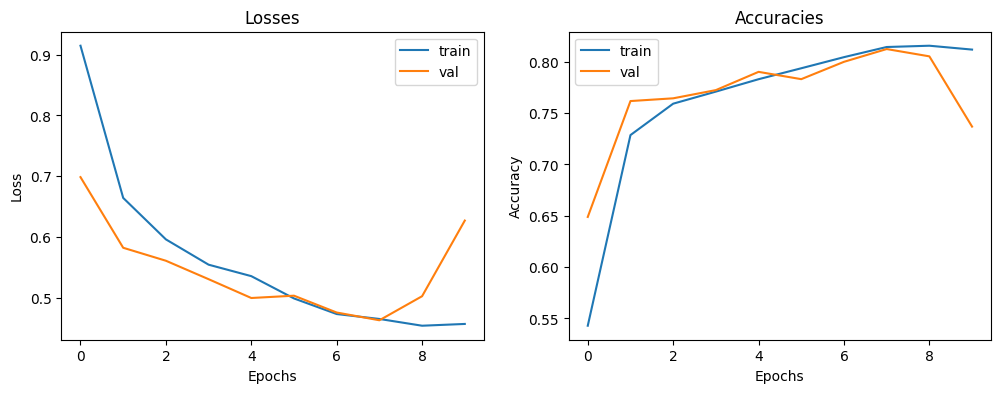

Bidirectional = True
Test correct = 477

Test total dataitem = 750

Test Accuracy = 0.6359999775886536

              precision    recall  f1-score   support

    negative       0.89      0.45      0.60       250
     neutral       0.67      0.54      0.59       250
    positive       0.55      0.92      0.68       250

    accuracy                           0.64       750
   macro avg       0.70      0.64      0.63       750
weighted avg       0.70      0.64      0.63       750



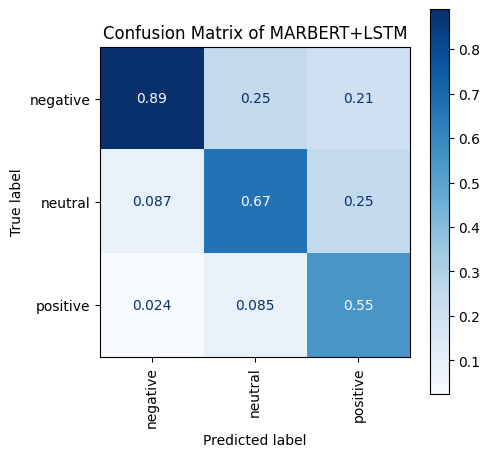

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:16<00:00,  6.14it/s]


loss = 0.9249292675466784, val_loss =0.7392890246444473, accuracy = 0.5273725390434265, val_accuracy = 0.6817777752876282


Epoch 2: 100%|██████████| 100/100 [00:16<00:00,  6.25it/s]


loss = 0.6657566807730585, val_loss =0.574205079796131, accuracy = 0.7167059183120728, val_accuracy = 0.7635555863380432


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


loss = 0.5811109598193677, val_loss =0.5944953140650258, accuracy = 0.7701960802078247, val_accuracy = 0.7457777857780457


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


loss = 0.5376571546904075, val_loss =0.6612534755740389, accuracy = 0.7843137383460999, val_accuracy = 0.6826666593551636


Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


loss = 0.5273688717346596, val_loss =0.6063270548289909, accuracy = 0.7857255339622498, val_accuracy = 0.7360000014305115


Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  6.19it/s]


loss = 0.5081713419744474, val_loss =0.5289329252698807, accuracy = 0.7960784435272217, val_accuracy = 0.7786666750907898


Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  6.25it/s]


A model was saved at accuracy = 0.795555591583252
loss = 0.48640699951813454, val_loss =0.4996670280336214, accuracy = 0.7993725538253784, val_accuracy = 0.795555591583252


Epoch 8: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


loss = 0.47991447215815186, val_loss =0.5259338672030198, accuracy = 0.8069019913673401, val_accuracy = 0.7662222385406494


Epoch 9: 100%|██████████| 100/100 [00:16<00:00,  6.07it/s]


loss = 0.45401228138093125, val_loss =0.575748502382077, accuracy = 0.8207058906555176, val_accuracy = 0.753777801990509


Epoch 10: 100%|██████████| 100/100 [00:16<00:00,  6.14it/s]


A model was saved at accuracy = 0.8026666641235352
loss = 0.4457420874284118, val_loss =0.4677569546144147, accuracy = 0.817254900932312, val_accuracy = 0.8026666641235352


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


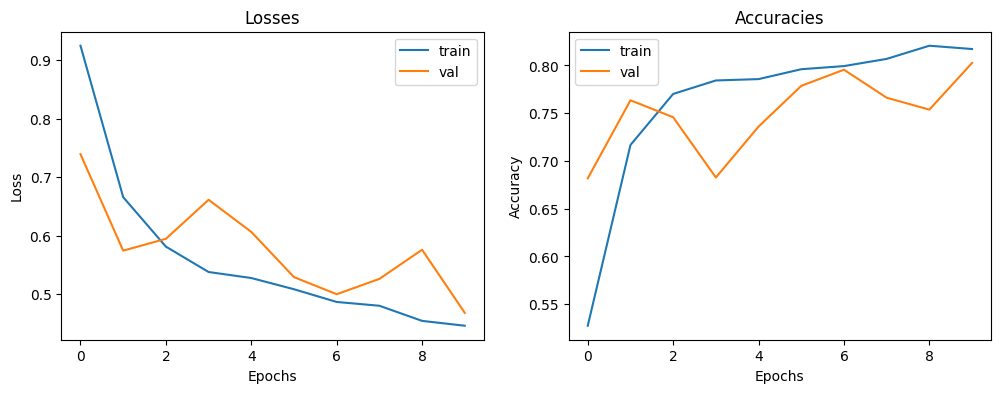

Bidirectional = False
Test correct = 527

Test total dataitem = 750

Test Accuracy = 0.7026666402816772

              precision    recall  f1-score   support

    negative       0.82      0.62      0.71       250
     neutral       0.65      0.77      0.71       250
    positive       0.68      0.72      0.70       250

    accuracy                           0.70       750
   macro avg       0.72      0.70      0.70       750
weighted avg       0.72      0.70      0.70       750



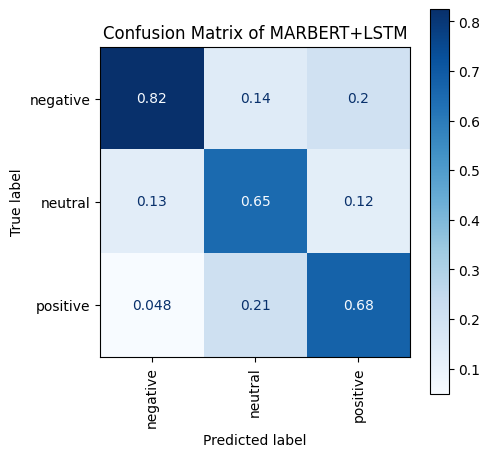

In [ ]:
bidirectional_options=[True,False]
for bidirectional1 in bidirectional_options:
  model=RNN_AraBERT(hidden_size1,hidden_size2,num_layers,bidirectional1,droprate).to(device,non_blocking=True)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  print(f'Bidirectional = {bidirectional1}')
  model_name='MARBERT+LSTM'
  test_and_report(model,test_loader,model_name)

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:19<00:00,  5.25it/s]


loss = 0.8936005082088283, val_loss =0.7574678053437905, accuracy = 0.5436862707138062, val_accuracy = 0.674666702747345


Epoch 2: 100%|██████████| 100/100 [00:18<00:00,  5.51it/s]


loss = 0.6754317669064414, val_loss =0.6380809229783669, accuracy = 0.716235339641571, val_accuracy = 0.7351111173629761


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  6.17it/s]


loss = 0.5827942718491491, val_loss =0.6187828788370808, accuracy = 0.7603137493133545, val_accuracy = 0.7360000014305115


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  6.21it/s]


loss = 0.5502462725549161, val_loss =0.6132107426094446, accuracy = 0.7752156853675842, val_accuracy = 0.7235555648803711


Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  6.23it/s]


loss = 0.5178040591207695, val_loss =0.5146511733836232, accuracy = 0.7874509692192078, val_accuracy = 0.7839999794960022


Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  5.97it/s]


loss = 0.506174892901457, val_loss =0.5618600590139365, accuracy = 0.7987450957298279, val_accuracy = 0.7760000228881836


Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  6.13it/s]


A model was saved at accuracy = 0.792888879776001
loss = 0.4885856336210793, val_loss =0.4764461600254337, accuracy = 0.796862781047821, val_accuracy = 0.792888879776001


Epoch 8: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


A model was saved at accuracy = 0.8071111440658569
loss = 0.4594194640910502, val_loss =0.4748807181369759, accuracy = 0.8123921751976013, val_accuracy = 0.8071111440658569


Epoch 9: 100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


A model was saved at accuracy = 0.8053333163261414
loss = 0.4451905491544054, val_loss =0.46391989733574274, accuracy = 0.8211764693260193, val_accuracy = 0.8053333163261414


Epoch 10: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


A model was saved at accuracy = 0.8035555481910706
loss = 0.43979940686006463, val_loss =0.4571223817638493, accuracy = 0.8224313855171204, val_accuracy = 0.8035555481910706


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


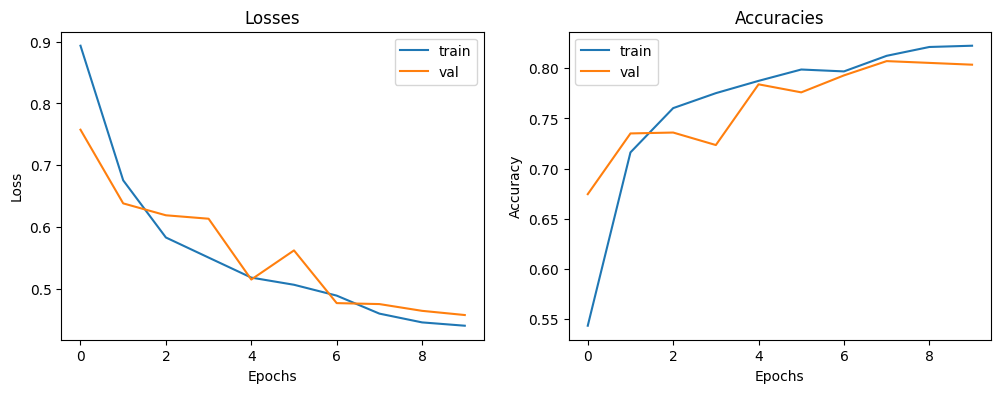

RNN Layers = 1
Test correct = 552

Test total dataitem = 750

Test Accuracy = 0.7360000014305115

              precision    recall  f1-score   support

    negative       0.78      0.72      0.75       250
     neutral       0.69      0.72      0.70       250
    positive       0.75      0.76      0.75       250

    accuracy                           0.74       750
   macro avg       0.74      0.74      0.74       750
weighted avg       0.74      0.74      0.74       750



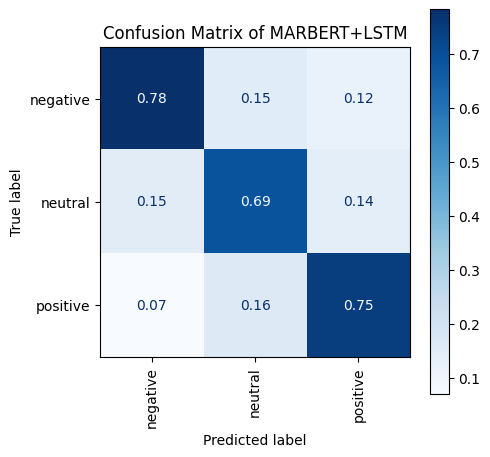

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


loss = 0.8558614280519302, val_loss =0.6607093193895424, accuracy = 0.5909019708633423, val_accuracy = 0.7235555648803711


Epoch 2: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


loss = 0.600182816925682, val_loss =0.5921258069838777, accuracy = 0.7534117698669434, val_accuracy = 0.746666669845581


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  6.16it/s]


loss = 0.5466967672330145, val_loss =0.5231894469417185, accuracy = 0.7770980596542358, val_accuracy = 0.7715555429458618


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


loss = 0.5121090071302536, val_loss =0.5034432372462374, accuracy = 0.789647102355957, val_accuracy = 0.7866666913032532


Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.4951018619591387, val_loss =0.6080887273610397, accuracy = 0.8036078810691833, val_accuracy = 0.7448889017105103


Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  6.07it/s]


A model was saved at accuracy = 0.7919999957084656
loss = 0.4940416442502784, val_loss =0.5127858012948437, accuracy = 0.8006274700164795, val_accuracy = 0.7919999957084656


Epoch 7: 100%|██████████| 100/100 [00:18<00:00,  5.52it/s]


loss = 0.4690174013307371, val_loss =0.5069177797649518, accuracy = 0.8070588707923889, val_accuracy = 0.7671111226081848


Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.69it/s]


A model was saved at accuracy = 0.8035555481910706
loss = 0.452019822404007, val_loss =0.48606426688128557, accuracy = 0.8130196332931519, val_accuracy = 0.8035555481910706


Epoch 9: 100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


loss = 0.4642736084402629, val_loss =0.5381652574421447, accuracy = 0.805647075176239, val_accuracy = 0.7777777910232544


Epoch 10: 100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


A model was saved at accuracy = 0.8008888959884644
loss = 0.438993499645483, val_loss =0.4868760363261373, accuracy = 0.8203921914100647, val_accuracy = 0.8008888959884644


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


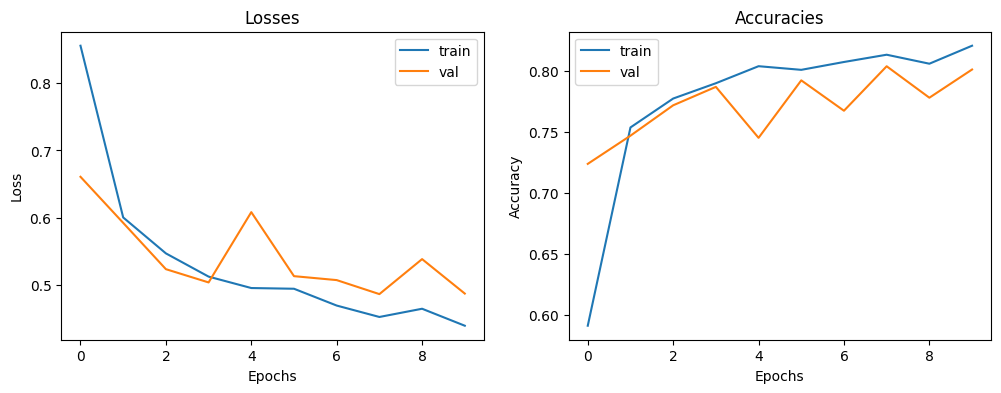

RNN Layers = 2
Test correct = 514

Test total dataitem = 750

Test Accuracy = 0.6853333115577698

              precision    recall  f1-score   support

    negative       0.83      0.51      0.63       250
     neutral       0.57      0.86      0.69       250
    positive       0.77      0.68      0.72       250

    accuracy                           0.69       750
   macro avg       0.73      0.69      0.68       750
weighted avg       0.73      0.69      0.68       750



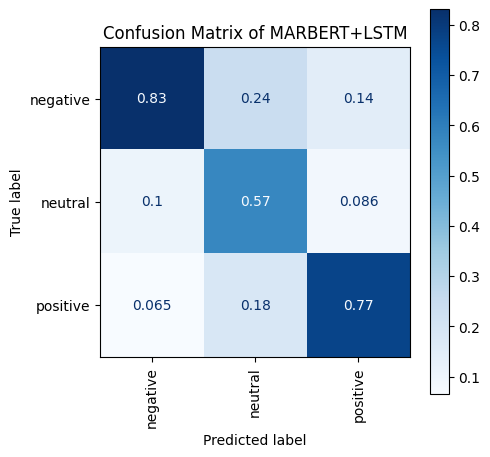

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


loss = 0.9152107593291275, val_loss =0.7953081488397459, accuracy = 0.5192157030105591, val_accuracy = 0.6044444441795349


Epoch 2: 100%|██████████| 100/100 [00:16<00:00,  6.16it/s]


loss = 0.739680647037883, val_loss =0.657465147127554, accuracy = 0.6530196070671082, val_accuracy = 0.7111111283302307


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


loss = 0.6087216356869752, val_loss =0.5692866304827269, accuracy = 0.7402353286743164, val_accuracy = 0.7546666860580444


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  6.08it/s]


loss = 0.5625937132278057, val_loss =0.6949802950470252, accuracy = 0.7733333706855774, val_accuracy = 0.7057777643203735


Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  6.21it/s]


loss = 0.5250853813419407, val_loss =0.5178530259772497, accuracy = 0.7904313802719116, val_accuracy = 0.7875555753707886


Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


loss = 0.5113258919699211, val_loss =0.5458627376305635, accuracy = 0.791215717792511, val_accuracy = 0.7706666588783264


Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  6.06it/s]


loss = 0.48082481921503, val_loss =0.5231191663057267, accuracy = 0.8090980648994446, val_accuracy = 0.7680000066757202


Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


A model was saved at accuracy = 0.8026666641235352
loss = 0.46926064136779155, val_loss =0.4861701341997815, accuracy = 0.8039215803146362, val_accuracy = 0.8026666641235352


Epoch 9: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


A model was saved at accuracy = 0.8133333325386047
loss = 0.4571642922010127, val_loss =0.4725216857135459, accuracy = 0.817098081111908, val_accuracy = 0.8133333325386047


Epoch 10: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


A model was saved at accuracy = 0.8008888959884644
loss = 0.4451927901907468, val_loss =0.4955489311915472, accuracy = 0.8258823752403259, val_accuracy = 0.8008888959884644


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


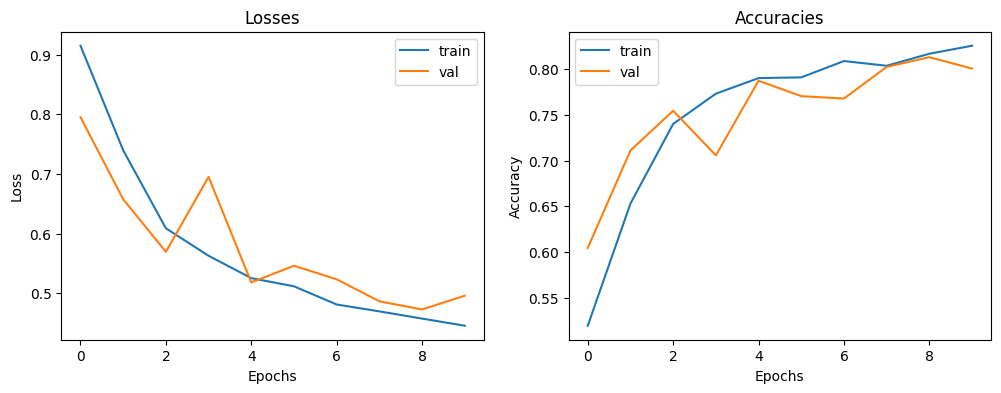

RNN Layers = 3
Test correct = 542

Test total dataitem = 750

Test Accuracy = 0.7226666808128357

              precision    recall  f1-score   support

    negative       0.83      0.66      0.74       250
     neutral       0.61      0.82      0.70       250
    positive       0.79      0.68      0.73       250

    accuracy                           0.72       750
   macro avg       0.75      0.72      0.72       750
weighted avg       0.75      0.72      0.72       750



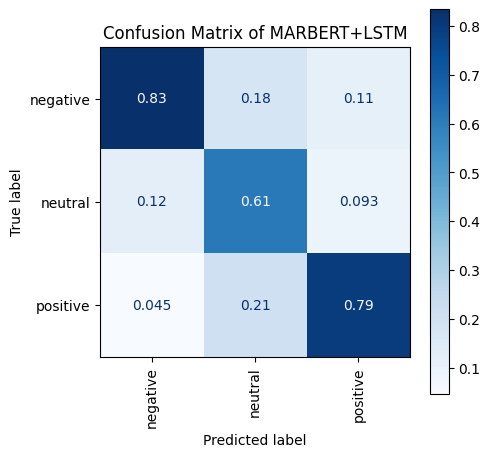

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:20<00:00,  4.91it/s]


loss = 0.9827522131575581, val_loss =0.8898928613414535, accuracy = 0.47968629002571106, val_accuracy = 0.5431111454963684


Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.876718509983184, val_loss =0.7566533666151274, accuracy = 0.552627444267273, val_accuracy = 0.5884444713592529


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.7839529849926624, val_loss =0.7116825568983359, accuracy = 0.5720784664154053, val_accuracy = 0.6097778081893921


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.7232934334152994, val_loss =0.7594015679274813, accuracy = 0.6048627495765686, val_accuracy = 0.5617777705192566


Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


loss = 0.7081691650022007, val_loss =0.6673587909040958, accuracy = 0.6097254753112793, val_accuracy = 0.6702222228050232


Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


loss = 0.675911609700697, val_loss =0.7832367931038677, accuracy = 0.6754509806632996, val_accuracy = 0.6115555763244629


Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


loss = 0.6321221884320579, val_loss =0.5973984800959453, accuracy = 0.7181176543235779, val_accuracy = 0.7235555648803711


Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  6.01it/s]


loss = 0.5823966693357318, val_loss =0.5538086024058025, accuracy = 0.7461960911750793, val_accuracy = 0.7715555429458618


Epoch 9: 100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


loss = 0.5284101468037163, val_loss =0.5427891048280039, accuracy = 0.7844706177711487, val_accuracy = 0.7839999794960022


Epoch 10: 100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


loss = 0.49112936982998867, val_loss =0.4955670390729822, accuracy = 0.7962353229522705, val_accuracy = 0.7848889231681824


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


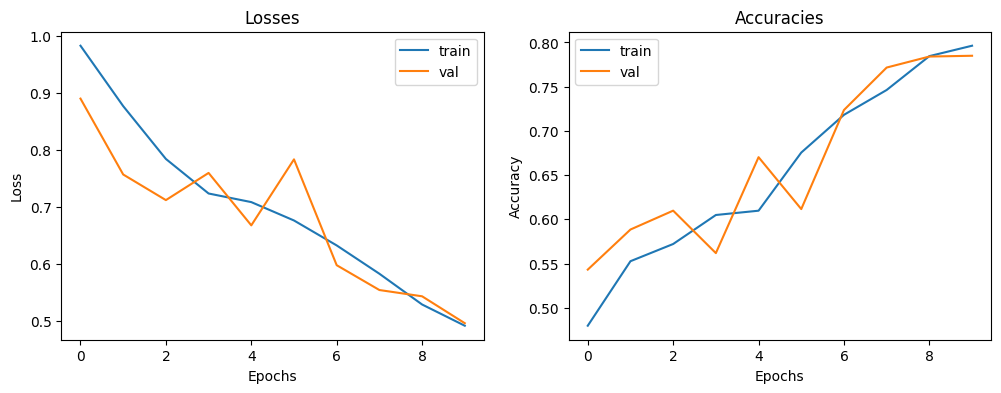

RNN Layers = 4
Test correct = 541

Test total dataitem = 750

Test Accuracy = 0.7213333249092102

              precision    recall  f1-score   support

    negative       0.78      0.70      0.74       250
     neutral       0.64      0.71      0.68       250
    positive       0.76      0.75      0.75       250

    accuracy                           0.72       750
   macro avg       0.73      0.72      0.72       750
weighted avg       0.73      0.72      0.72       750



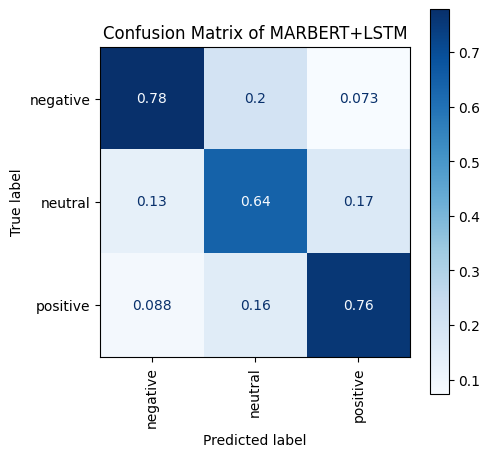

In [ ]:
bidirectional=False
rnn_layers=[1,2,3,4]
for num_layers1 in rnn_layers:
  model=RNN_AraBERT(hidden_size1,hidden_size2,num_layers1,bidirectional,droprate).to(device,non_blocking=True)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  print(f'RNN Layers = {num_layers1}')
  model_name='MARBERT+LSTM'
  test_and_report(model,test_loader,model_name)

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:16<00:00,  6.10it/s]


loss = 0.92659904194401, val_loss =0.734676942737408, accuracy = 0.525019645690918, val_accuracy = 0.6586666703224182


Epoch 2: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


loss = 0.6512824400754732, val_loss =0.5530262897318989, accuracy = 0.7320784330368042, val_accuracy = 0.7760000228881836


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  6.12it/s]


loss = 0.5638102608390424, val_loss =0.5757047842200265, accuracy = 0.7720784544944763, val_accuracy = 0.7457777857780457


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


A model was saved at accuracy = 0.795555591583252
loss = 0.53406640919124, val_loss =0.49539465635386587, accuracy = 0.779764711856842, val_accuracy = 0.795555591583252


Epoch 5: 100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


A model was saved at accuracy = 0.800000011920929
loss = 0.5152015560385431, val_loss =0.4878185332632197, accuracy = 0.7899608016014099, val_accuracy = 0.800000011920929


Epoch 6: 100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


A model was saved at accuracy = 0.800000011920929
loss = 0.48045214337427006, val_loss =0.5046128734666291, accuracy = 0.8078431487083435, val_accuracy = 0.800000011920929


Epoch 7: 100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


loss = 0.4834294367518557, val_loss =0.5353432381010419, accuracy = 0.8042353391647339, val_accuracy = 0.7760000228881836


Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  6.20it/s]


loss = 0.469115802504456, val_loss =0.5011982871261358, accuracy = 0.8160000443458557, val_accuracy = 0.7848889231681824


Epoch 9: 100%|██████████| 100/100 [00:16<00:00,  6.07it/s]


A model was saved at accuracy = 0.7937777638435364
loss = 0.4611931872000083, val_loss =0.5024601176941491, accuracy = 0.8139607906341553, val_accuracy = 0.7937777638435364


Epoch 10: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


A model was saved at accuracy = 0.8017777800559998
loss = 0.44922348611743274, val_loss =0.4666468694387578, accuracy = 0.8147451281547546, val_accuracy = 0.8017777800559998


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


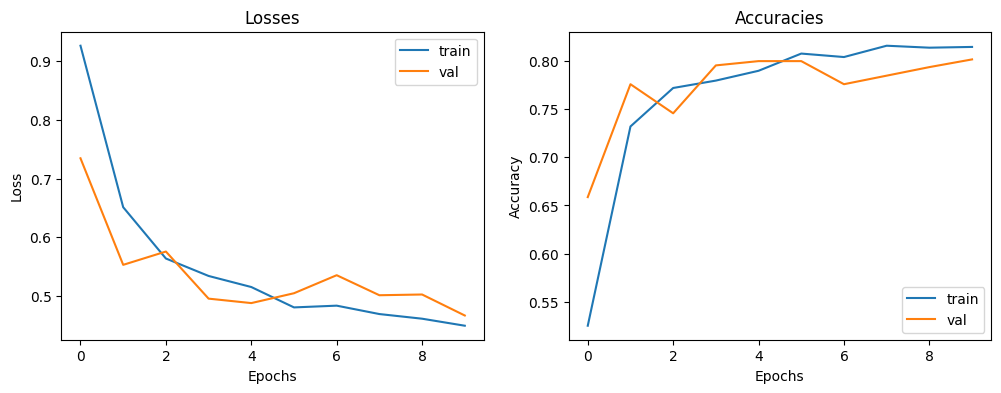

RNN hidden size = 32
Test correct = 533

Test total dataitem = 750

Test Accuracy = 0.7106666564941406

              precision    recall  f1-score   support

    negative       0.78      0.64      0.70       250
     neutral       0.69      0.70      0.70       250
    positive       0.68      0.79      0.73       250

    accuracy                           0.71       750
   macro avg       0.72      0.71      0.71       750
weighted avg       0.72      0.71      0.71       750



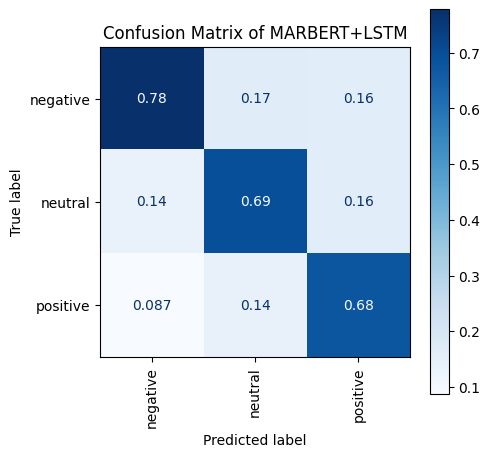

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.8976324350815058, val_loss =0.7621930948582369, accuracy = 0.5502745509147644, val_accuracy = 0.6480000019073486


Epoch 2: 100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


loss = 0.6470343347567206, val_loss =0.638614936905024, accuracy = 0.7316078543663025, val_accuracy = 0.7475555539131165


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


loss = 0.5991181856446975, val_loss =0.6315047574166961, accuracy = 0.7523137331008911, val_accuracy = 0.7315555810928345


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


loss = 0.5360078162312367, val_loss =0.5222797642431847, accuracy = 0.7807059288024902, val_accuracy = 0.7839999794960022


Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  6.20it/s]


loss = 0.5078472859669712, val_loss =0.6173098906418981, accuracy = 0.7927843332290649, val_accuracy = 0.7155555486679077


Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  6.07it/s]


A model was saved at accuracy = 0.7902222275733948
loss = 0.4954054006903031, val_loss =0.49259355816735895, accuracy = 0.7923137545585632, val_accuracy = 0.7902222275733948


Epoch 7: 100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


loss = 0.47860334761594386, val_loss =0.48896982080028967, accuracy = 0.7996863126754761, val_accuracy = 0.788444459438324


Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


loss = 0.4615239917724233, val_loss =0.6112837720453996, accuracy = 0.8086274862289429, val_accuracy = 0.7493333220481873


Epoch 9: 100%|██████████| 100/100 [00:16<00:00,  6.08it/s]


A model was saved at accuracy = 0.7919999957084656
loss = 0.4564483859366177, val_loss =0.5010040741952951, accuracy = 0.8089411854743958, val_accuracy = 0.7919999957084656


Epoch 10: 100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


loss = 0.45024912618929114, val_loss =0.496936492182976, accuracy = 0.812862753868103, val_accuracy = 0.7893333435058594


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


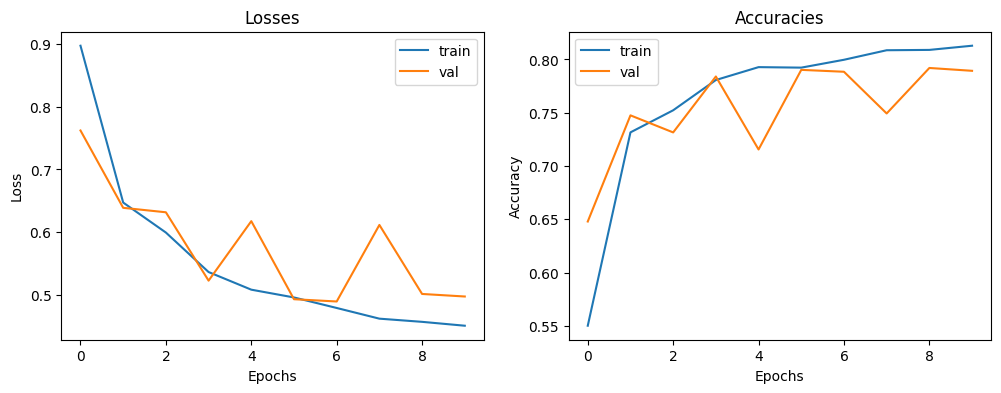

RNN hidden size = 64
Test correct = 542

Test total dataitem = 750

Test Accuracy = 0.7226666808128357

              precision    recall  f1-score   support

    negative       0.83      0.58      0.68       250
     neutral       0.62      0.82      0.71       250
    positive       0.78      0.77      0.78       250

    accuracy                           0.72       750
   macro avg       0.75      0.72      0.72       750
weighted avg       0.75      0.72      0.72       750



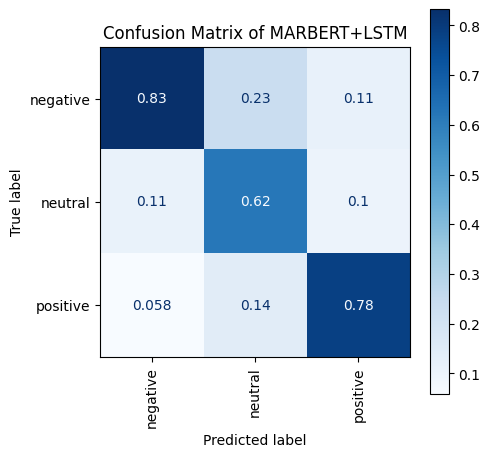

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


loss = 0.8847166202821506, val_loss =0.6626993206023049, accuracy = 0.5472941398620605, val_accuracy = 0.6933333277702332


Epoch 2: 100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


loss = 0.6715207237757866, val_loss =0.6260071314431958, accuracy = 0.717960774898529, val_accuracy = 0.6968889236450195


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


loss = 0.5722689755980331, val_loss =0.52728316069692, accuracy = 0.7593725919723511, val_accuracy = 0.7777777910232544


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  6.11it/s]


A model was saved at accuracy = 0.7946666479110718
loss = 0.5300690004973689, val_loss =0.5226308089745121, accuracy = 0.7874509692192078, val_accuracy = 0.7946666479110718


Epoch 5: 100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


loss = 0.5068697046604089, val_loss =0.5383759787861915, accuracy = 0.7926274538040161, val_accuracy = 0.7751111388206482


Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


loss = 0.49693763406701713, val_loss =0.5460677243138673, accuracy = 0.8018823862075806, val_accuracy = 0.7760000228881836


Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


loss = 0.4890235774383755, val_loss =0.5526080040131187, accuracy = 0.8009411692619324, val_accuracy = 0.788444459438324


Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


A model was saved at accuracy = 0.8071111440658569
loss = 0.4637536519431113, val_loss =0.4700650874787429, accuracy = 0.8142745494842529, val_accuracy = 0.8071111440658569


Epoch 9: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


A model was saved at accuracy = 0.8035555481910706
loss = 0.45296793308761607, val_loss =0.46792388652534167, accuracy = 0.8178823590278625, val_accuracy = 0.8035555481910706


Epoch 10: 100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


A model was saved at accuracy = 0.8097777962684631
loss = 0.44950776916120555, val_loss =0.4677466114324532, accuracy = 0.8167843222618103, val_accuracy = 0.8097777962684631


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


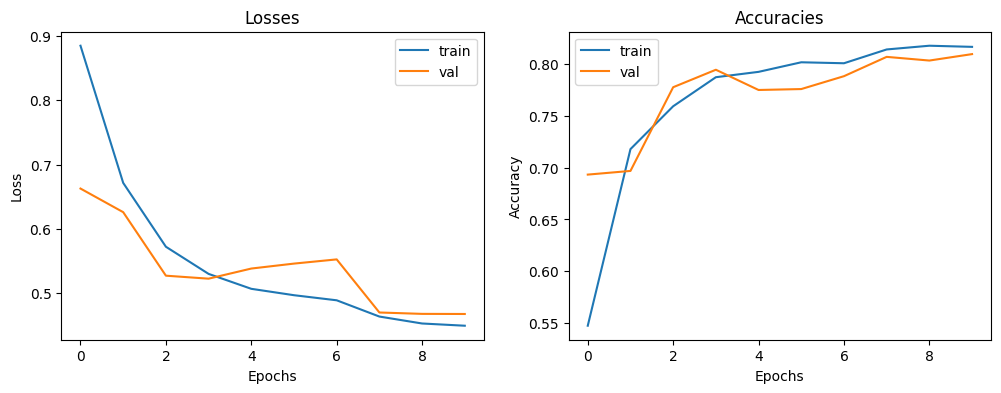

RNN hidden size = 128
Test correct = 544

Test total dataitem = 750

Test Accuracy = 0.7253333330154419

              precision    recall  f1-score   support

    negative       0.77      0.70      0.73       250
     neutral       0.64      0.82      0.72       250
    positive       0.81      0.66      0.73       250

    accuracy                           0.73       750
   macro avg       0.74      0.73      0.73       750
weighted avg       0.74      0.73      0.73       750



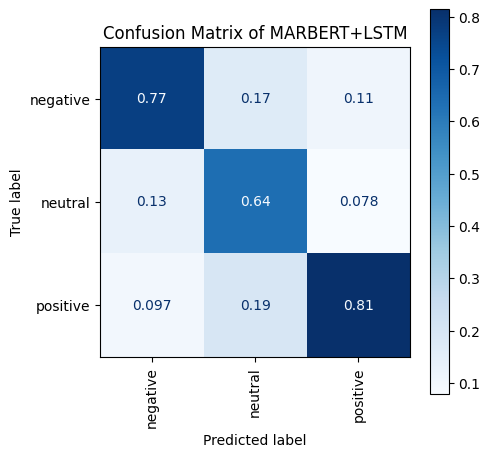

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


loss = 0.8506898992634021, val_loss =0.74626233824319, accuracy = 0.6031372547149658, val_accuracy = 0.671999990940094


Epoch 2: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.6517751318894853, val_loss =0.549716738547475, accuracy = 0.7298823595046997, val_accuracy = 0.7777777910232544


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  6.04it/s]


loss = 0.5766924905606488, val_loss =0.5990156039328645, accuracy = 0.7573333382606506, val_accuracy = 0.7120000123977661


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  6.01it/s]


loss = 0.5598967700326252, val_loss =0.5082665877744913, accuracy = 0.7703529596328735, val_accuracy = 0.781333327293396


Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


loss = 0.5101935297939233, val_loss =0.5217567176958954, accuracy = 0.7863529324531555, val_accuracy = 0.7875555753707886


Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


loss = 0.5058694649913925, val_loss =0.496581969727474, accuracy = 0.7962353229522705, val_accuracy = 0.7866666913032532


Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


A model was saved at accuracy = 0.7964444756507874
loss = 0.4708311588444032, val_loss =0.4742411101055936, accuracy = 0.8106666803359985, val_accuracy = 0.7964444756507874


Epoch 8: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]


A model was saved at accuracy = 0.8017777800559998
loss = 0.4644254122133809, val_loss =0.483421200667003, accuracy = 0.8065882325172424, val_accuracy = 0.8017777800559998


Epoch 9: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


A model was saved at accuracy = 0.8106666803359985
loss = 0.4639961017755019, val_loss =0.4540444045726875, accuracy = 0.8076862692832947, val_accuracy = 0.8106666803359985


Epoch 10: 100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


A model was saved at accuracy = 0.7911111116409302
loss = 0.45664001985015346, val_loss =0.516691705119966, accuracy = 0.814431369304657, val_accuracy = 0.7911111116409302


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


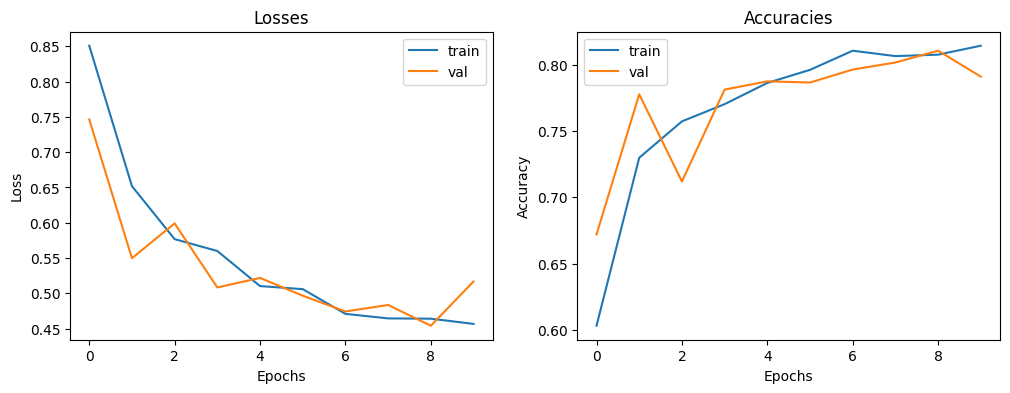

RNN hidden size = 256
Test correct = 503

Test total dataitem = 750

Test Accuracy = 0.6706666350364685

              precision    recall  f1-score   support

    negative       0.89      0.43      0.58       250
     neutral       0.62      0.83      0.71       250
    positive       0.64      0.76      0.69       250

    accuracy                           0.67       750
   macro avg       0.72      0.67      0.66       750
weighted avg       0.72      0.67      0.66       750



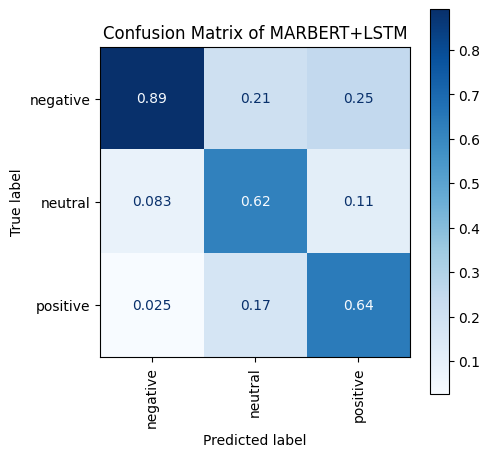

In [ ]:
bidirectional=False
num_layers=1
rnn_hidden_sizes=[32,64,128,256]
for hidden_size in rnn_hidden_sizes:
  model=RNN_AraBERT(hidden_size,hidden_size2,num_layers,bidirectional,droprate).to(device,non_blocking=True)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  print(f'RNN hidden size = {hidden_size}')
  model_name='MARBERT+LSTM'
  test_and_report(model,test_loader,model_name)

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


loss = 0.943303629664737, val_loss =0.6962263505446499, accuracy = 0.527999997138977, val_accuracy = 0.7066666483879089


Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.7374063630869498, val_loss =0.6771646570673006, accuracy = 0.700705885887146, val_accuracy = 0.7217777967453003


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  6.16it/s]


loss = 0.6592467289585048, val_loss =0.6111437620330017, accuracy = 0.7259607911109924, val_accuracy = 0.7315555810928345


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  6.16it/s]


loss = 0.5997297966325219, val_loss =0.5488363202036068, accuracy = 0.7557647228240967, val_accuracy = 0.7502222061157227


Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  6.08it/s]


loss = 0.5580804437673433, val_loss =0.537920691279224, accuracy = 0.7863529324531555, val_accuracy = 0.7760000228881836


Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


A model was saved at accuracy = 0.7937777638435364
loss = 0.5557706725953567, val_loss =0.5286266312549641, accuracy = 0.7836862802505493, val_accuracy = 0.7937777638435364


Epoch 7: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


A model was saved at accuracy = 0.7946666479110718
loss = 0.516624345850729, val_loss =0.48713257691521794, accuracy = 0.7924706339836121, val_accuracy = 0.7946666479110718


Epoch 8: 100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


A model was saved at accuracy = 0.7946666479110718
loss = 0.5054638141005643, val_loss =0.5280106374009919, accuracy = 0.8054901957511902, val_accuracy = 0.7946666479110718


Epoch 9: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


A model was saved at accuracy = 0.7973333597183228
loss = 0.49690057853628894, val_loss =0.5002139157132953, accuracy = 0.8034510016441345, val_accuracy = 0.7973333597183228


Epoch 10: 100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


A model was saved at accuracy = 0.8062222599983215
loss = 0.49634718888157714, val_loss =0.46549813426353714, accuracy = 0.8043921589851379, val_accuracy = 0.8062222599983215


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


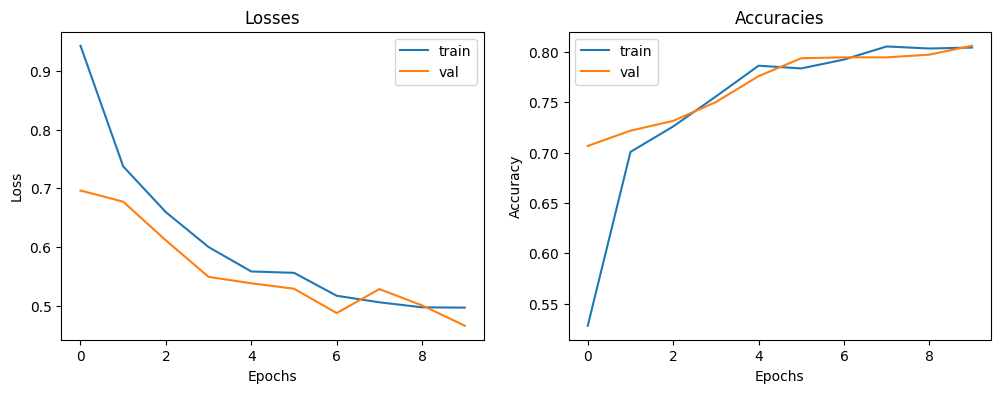

fully-connected hidden size = 32
Test correct = 571

Test total dataitem = 750

Test Accuracy = 0.7613333463668823

              precision    recall  f1-score   support

    negative       0.79      0.81      0.80       250
     neutral       0.72      0.78      0.75       250
    positive       0.78      0.69      0.73       250

    accuracy                           0.76       750
   macro avg       0.76      0.76      0.76       750
weighted avg       0.76      0.76      0.76       750



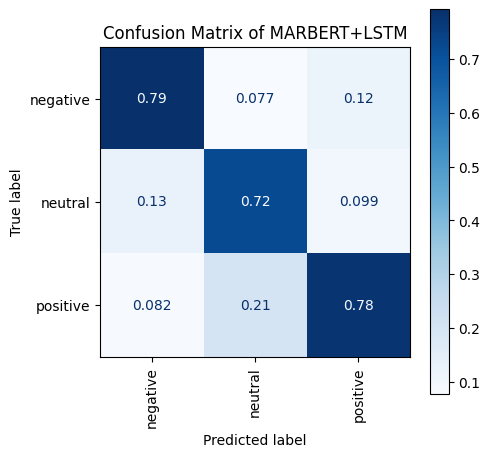

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


loss = 0.9290621793370035, val_loss =0.8280077078204019, accuracy = 0.5247058868408203, val_accuracy = 0.6435555815696716


Epoch 2: 100%|██████████| 100/100 [00:16<00:00,  6.04it/s]


loss = 0.738169510004028, val_loss =0.6108817906958308, accuracy = 0.6829804182052612, val_accuracy = 0.7253333330154419


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


loss = 0.6076962270645201, val_loss =0.5346343736535717, accuracy = 0.7468235492706299, val_accuracy = 0.7875555753707886


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  6.14it/s]


loss = 0.5656798308353786, val_loss =0.6212634684835412, accuracy = 0.7703529596328735, val_accuracy = 0.7297778129577637


Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


loss = 0.5321098385093126, val_loss =0.5427804577091199, accuracy = 0.7825882434844971, val_accuracy = 0.7502222061157227


Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  6.12it/s]


A model was saved at accuracy = 0.7902222275733948
loss = 0.5229082443966877, val_loss =0.48899330073363234, accuracy = 0.7890196442604065, val_accuracy = 0.7902222275733948


Epoch 7: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


loss = 0.506766042172317, val_loss =0.5224162103089123, accuracy = 0.7962353229522705, val_accuracy = 0.7857778072357178


Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


loss = 0.4857060123972079, val_loss =0.5478240593813819, accuracy = 0.8014118075370789, val_accuracy = 0.781333327293396


Epoch 9: 100%|██████████| 100/100 [00:16<00:00,  6.01it/s]


A model was saved at accuracy = 0.7902222275733948
loss = 0.4779046101354254, val_loss =0.4615447484906676, accuracy = 0.8139607906341553, val_accuracy = 0.7902222275733948


Epoch 10: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


A model was saved at accuracy = 0.7982222437858582
loss = 0.456301529532735, val_loss =0.49143321984138033, accuracy = 0.8139607906341553, val_accuracy = 0.7982222437858582


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


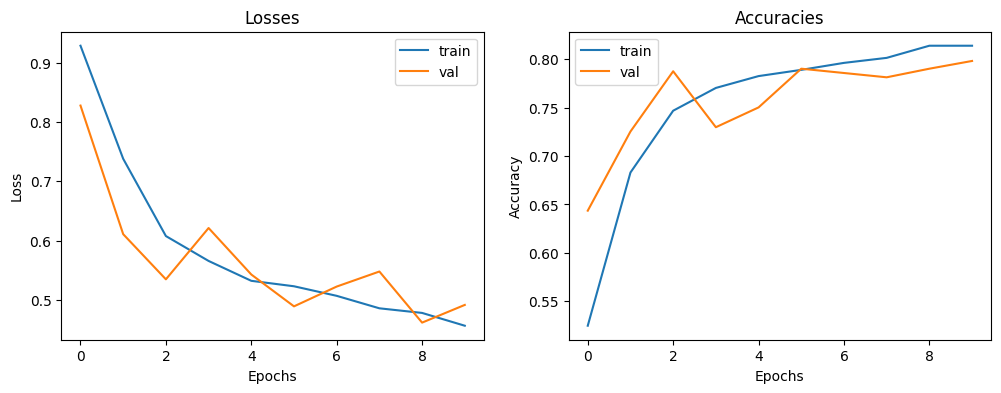

fully-connected hidden size = 64
Test correct = 544

Test total dataitem = 750

Test Accuracy = 0.7253333330154419

              precision    recall  f1-score   support

    negative       0.80      0.70      0.74       250
     neutral       0.76      0.63      0.69       250
    positive       0.66      0.85      0.74       250

    accuracy                           0.73       750
   macro avg       0.74      0.73      0.72       750
weighted avg       0.74      0.73      0.72       750



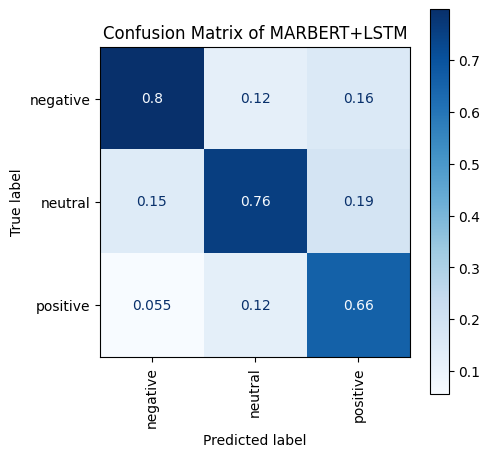

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


loss = 0.9055965199553743, val_loss =0.7766909177317886, accuracy = 0.556705892086029, val_accuracy = 0.6168888807296753


Epoch 2: 100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


loss = 0.6714919892419913, val_loss =0.6215661630222704, accuracy = 0.7168627381324768, val_accuracy = 0.7253333330154419


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  6.01it/s]


loss = 0.6125343500877413, val_loss =0.6335505551452572, accuracy = 0.7518431544303894, val_accuracy = 0.679111123085022


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


loss = 0.5696933126565371, val_loss =0.5568074653601252, accuracy = 0.7711372971534729, val_accuracy = 0.7671111226081848


Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  6.06it/s]


loss = 0.5285680279548675, val_loss =0.5380794592813065, accuracy = 0.7866666913032532, val_accuracy = 0.7688888907432556


Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


A model was saved at accuracy = 0.8053333163261414
loss = 0.5074220948173589, val_loss =0.48344247817364594, accuracy = 0.7943529486656189, val_accuracy = 0.8053333163261414


Epoch 7: 100%|██████████| 100/100 [00:19<00:00,  5.24it/s]


loss = 0.49009766337997185, val_loss =0.5226316517510313, accuracy = 0.8053333759307861, val_accuracy = 0.7839999794960022


Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


loss = 0.47965860170508534, val_loss =0.5439209420720372, accuracy = 0.8037647008895874, val_accuracy = 0.7502222061157227


Epoch 9: 100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


A model was saved at accuracy = 0.8053333163261414
loss = 0.4644510958541996, val_loss =0.476414180469344, accuracy = 0.8163137435913086, val_accuracy = 0.8053333163261414


Epoch 10: 100%|██████████| 100/100 [00:19<00:00,  5.21it/s]


A model was saved at accuracy = 0.8035555481910706
loss = 0.4452010016840201, val_loss =0.46202846275812043, accuracy = 0.8153725862503052, val_accuracy = 0.8035555481910706


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


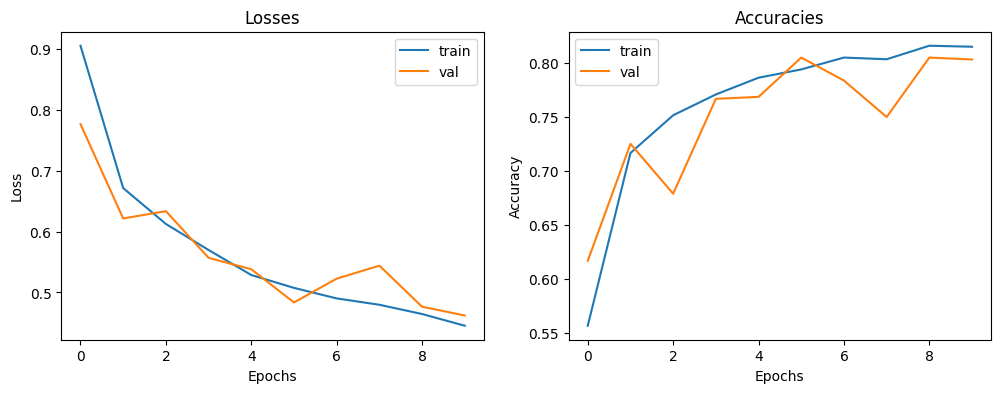

fully-connected hidden size = 128
Test correct = 552

Test total dataitem = 750

Test Accuracy = 0.7360000014305115

              precision    recall  f1-score   support

    negative       0.79      0.69      0.74       250
     neutral       0.69      0.74      0.72       250
    positive       0.73      0.78      0.75       250

    accuracy                           0.74       750
   macro avg       0.74      0.74      0.74       750
weighted avg       0.74      0.74      0.74       750



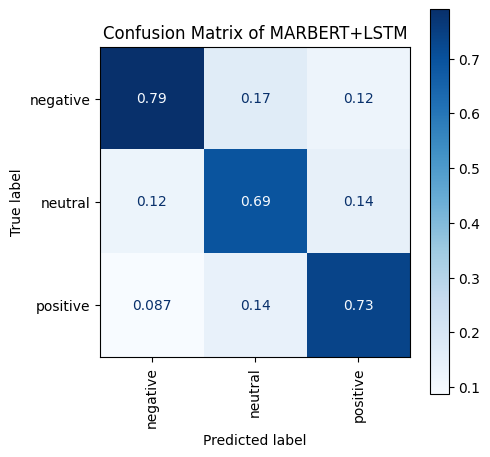

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


loss = 0.8835752927200146, val_loss =0.6237703056779813, accuracy = 0.5639215707778931, val_accuracy = 0.7271111011505127


Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.61it/s]


loss = 0.6514005636880608, val_loss =0.5873961118014086, accuracy = 0.7341176867485046, val_accuracy = 0.7502222061157227


Epoch 3: 100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


loss = 0.5743401349944701, val_loss =0.5121400045814285, accuracy = 0.7634509801864624, val_accuracy = 0.788444459438324


Epoch 4: 100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


loss = 0.5331839960773841, val_loss =0.5456044971279763, accuracy = 0.7835294008255005, val_accuracy = 0.7688888907432556


Epoch 5: 100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


loss = 0.5151491845445296, val_loss =0.5060578720853787, accuracy = 0.7857255339622498, val_accuracy = 0.788444459438324


Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  6.07it/s]


loss = 0.5024682819190079, val_loss =0.5006744064206553, accuracy = 0.7978039383888245, val_accuracy = 0.7866666913032532


Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  5.97it/s]


loss = 0.4743847733831329, val_loss =0.5386899799822193, accuracy = 0.8067451119422913, val_accuracy = 0.7839999794960022


Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  6.07it/s]


A model was saved at accuracy = 0.7911111116409302
loss = 0.4801260147799385, val_loss =0.5130809005341681, accuracy = 0.8070588707923889, val_accuracy = 0.7911111116409302


Epoch 9: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


A model was saved at accuracy = 0.8008888959884644
loss = 0.44749954063374486, val_loss =0.4812035128644139, accuracy = 0.8142745494842529, val_accuracy = 0.8008888959884644


Epoch 10: 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


A model was saved at accuracy = 0.7964444756507874
loss = 0.45700138540393676, val_loss =0.47082735385736957, accuracy = 0.8123921751976013, val_accuracy = 0.7964444756507874


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


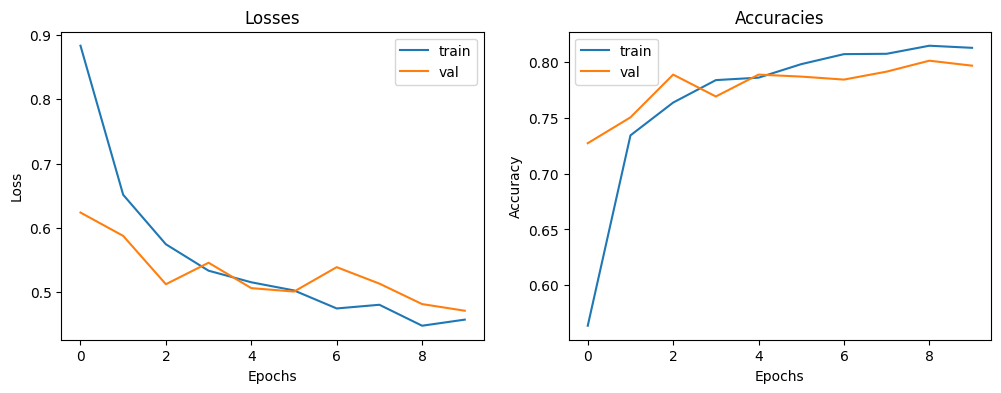

fully-connected hidden size = 256
Test correct = 519

Test total dataitem = 750

Test Accuracy = 0.6919999718666077

              precision    recall  f1-score   support

    negative       0.85      0.50      0.63       250
     neutral       0.64      0.78      0.70       250
    positive       0.67      0.79      0.73       250

    accuracy                           0.69       750
   macro avg       0.72      0.69      0.69       750
weighted avg       0.72      0.69      0.69       750



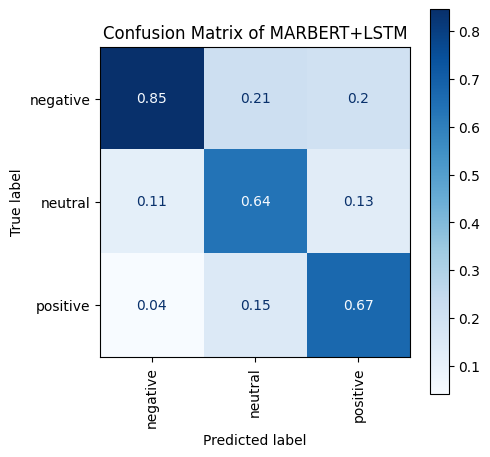

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:21<00:00,  4.70it/s]


loss = 0.8538107558608691, val_loss =0.7134091478386421, accuracy = 0.5680000185966492, val_accuracy = 0.6915555596351624


Epoch 2: 100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


loss = 0.6677183356823577, val_loss =0.5533190641311033, accuracy = 0.7201569080352783, val_accuracy = 0.7733333706855774


Epoch 3: 100%|██████████| 100/100 [00:18<00:00,  5.52it/s]


loss = 0.5880592707999444, val_loss =0.5881545809043838, accuracy = 0.7574902176856995, val_accuracy = 0.7404444813728333


Epoch 4: 100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


loss = 0.5510564980820298, val_loss =0.5260998618125398, accuracy = 0.7698823809623718, val_accuracy = 0.776888906955719


Epoch 5: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


loss = 0.5174557470538, val_loss =0.5636516649848438, accuracy = 0.7910588383674622, val_accuracy = 0.7448889017105103


Epoch 6: 100%|██████████| 100/100 [00:18<00:00,  5.42it/s]


loss = 0.4988035884010158, val_loss =0.496416072992071, accuracy = 0.7927843332290649, val_accuracy = 0.7831110954284668


Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  6.11it/s]


A model was saved at accuracy = 0.792888879776001
loss = 0.4853491494492468, val_loss =0.484822935767163, accuracy = 0.8001568913459778, val_accuracy = 0.792888879776001


Epoch 8: 100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


loss = 0.47562542544114733, val_loss =0.5993054242067961, accuracy = 0.8058039546012878, val_accuracy = 0.7351111173629761


Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.4514101269569408, val_loss =0.5423075725731671, accuracy = 0.8141176700592041, val_accuracy = 0.7831110954284668


Epoch 10: 100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


loss = 0.45055709255443815, val_loss =0.4852627708868057, accuracy = 0.8189803957939148, val_accuracy = 0.788444459438324


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


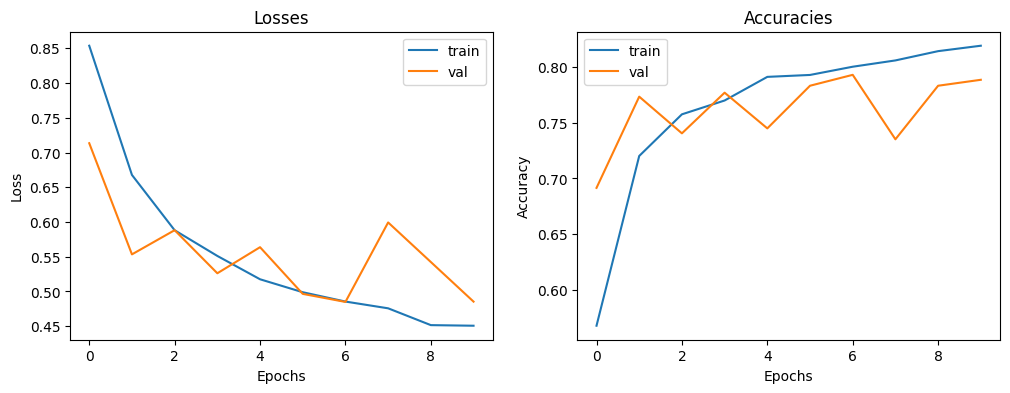

fully-connected hidden size = 512
Test correct = 527

Test total dataitem = 750

Test Accuracy = 0.7026666402816772

              precision    recall  f1-score   support

    negative       0.86      0.55      0.67       250
     neutral       0.66      0.72      0.68       250
    positive       0.66      0.84      0.74       250

    accuracy                           0.70       750
   macro avg       0.73      0.70      0.70       750
weighted avg       0.73      0.70      0.70       750



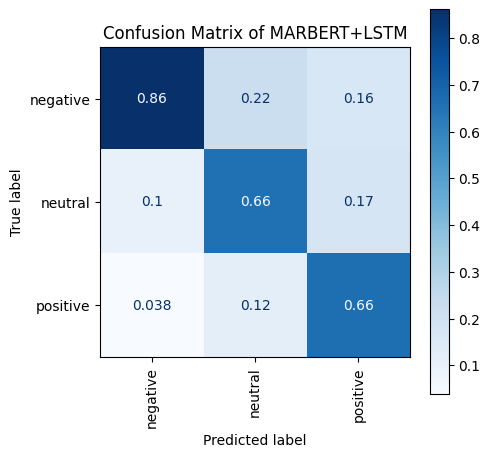

In [ ]:
bidirectional=False
num_layers=1
hidden_size1=128
fc_hidden_size=[32,64,128,256,512]
for hidden_size in fc_hidden_size:
  model=RNN_AraBERT(hidden_size1,hidden_size,num_layers,bidirectional,droprate).to(device,non_blocking=True)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  print(f'fully-connected hidden size = {hidden_size}')
  model_name='MARBERT+LSTM'
  test_and_report(model,test_loader,model_name)

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


loss = 0.994217089254809, val_loss =0.8056747659687065, accuracy = 0.46886274218559265, val_accuracy = 0.6115555763244629


Epoch 2: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


loss = 0.8249186831437655, val_loss =0.6690601569396938, accuracy = 0.6469019651412964, val_accuracy = 0.7368888854980469


Epoch 3: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


loss = 0.6830583475075084, val_loss =0.6173994174129581, accuracy = 0.7237647175788879, val_accuracy = 0.7342222332954407


Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


loss = 0.6273724379283937, val_loss =0.5868119163548451, accuracy = 0.7576470971107483, val_accuracy = 0.7511110901832581


Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


loss = 0.6123225754169238, val_loss =0.538050278086532, accuracy = 0.75811767578125, val_accuracy = 0.7760000228881836


Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.5812931531678905, val_loss =0.5176931057746649, accuracy = 0.7781960964202881, val_accuracy = 0.7866666913032532


Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


loss = 0.5560617527884879, val_loss =0.5295989826175558, accuracy = 0.779764711856842, val_accuracy = 0.7742222547531128


Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


loss = 0.5491153772486128, val_loss =0.5326211957540469, accuracy = 0.7876078486442566, val_accuracy = 0.7644444704055786


Epoch 9: 100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


A model was saved at accuracy = 0.7919999957084656
loss = 0.5254480983370927, val_loss =0.4987758968959347, accuracy = 0.7945098280906677, val_accuracy = 0.7919999957084656


Epoch 10: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


A model was saved at accuracy = 0.7991111278533936
loss = 0.5245231319764336, val_loss =0.49251199084370434, accuracy = 0.7938823699951172, val_accuracy = 0.7991111278533936


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


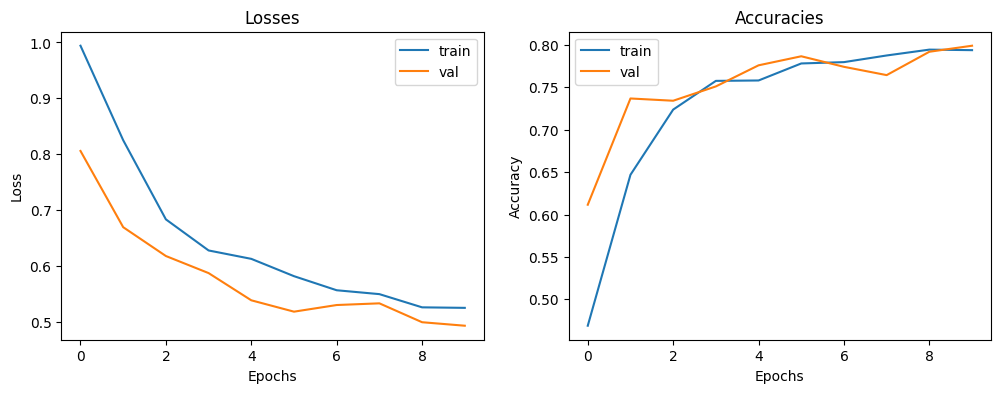

learning rate = 0.001
Test correct = 536

Test total dataitem = 750

Test Accuracy = 0.7146666646003723

              precision    recall  f1-score   support

    negative       0.81      0.68      0.74       250
     neutral       0.69      0.67      0.68       250
    positive       0.67      0.79      0.72       250

    accuracy                           0.71       750
   macro avg       0.72      0.71      0.71       750
weighted avg       0.72      0.71      0.71       750



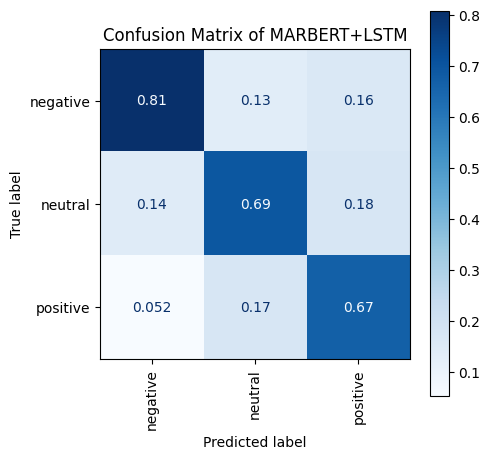

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


loss = 0.9746286766916045, val_loss =0.8573725440643599, accuracy = 0.49396079778671265, val_accuracy = 0.6275555491447449


Epoch 2: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


loss = 0.710934829257218, val_loss =0.5922695203459131, accuracy = 0.6983529329299927, val_accuracy = 0.7440000176429749


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.6112957352086993, val_loss =0.610717869999727, accuracy = 0.7532548904418945, val_accuracy = 0.753777801990509


Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.5882203926056186, val_loss =0.6854094109205527, accuracy = 0.771294116973877, val_accuracy = 0.7039999961853027


Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


loss = 0.5492197073283092, val_loss =0.5280423535627237, accuracy = 0.7844706177711487, val_accuracy = 0.781333327293396


Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  5.88it/s]


loss = 0.5371589616161054, val_loss =0.5030528244008949, accuracy = 0.7935686707496643, val_accuracy = 0.7715555429458618


Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


A model was saved at accuracy = 0.7973333597183228
loss = 0.5020166499681477, val_loss =0.49974373766695596, accuracy = 0.8053333759307861, val_accuracy = 0.7973333597183228


Epoch 8: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


loss = 0.49363064439918847, val_loss =0.5123531931479851, accuracy = 0.812862753868103, val_accuracy = 0.7804444432258606


Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.5063375560526776, val_loss =0.5260988083639561, accuracy = 0.7993725538253784, val_accuracy = 0.7751111388206482


Epoch 10: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


A model was saved at accuracy = 0.8080000281333923
loss = 0.4790869692319296, val_loss =0.4748266746115001, accuracy = 0.8174117803573608, val_accuracy = 0.8080000281333923


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


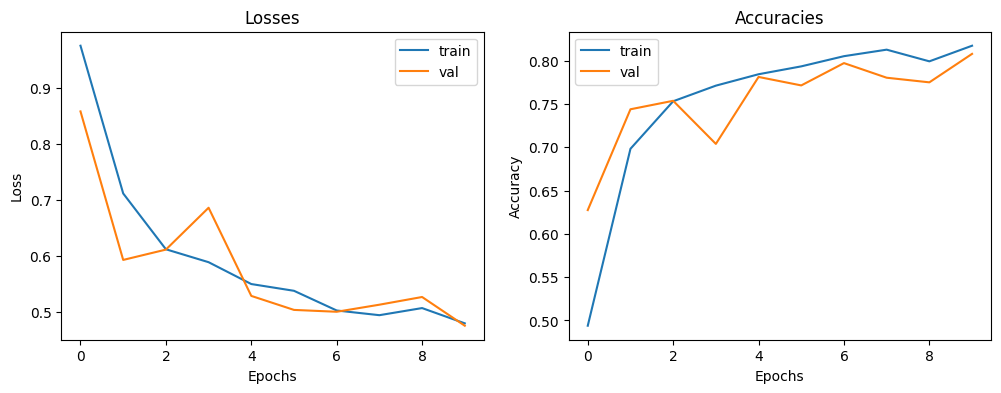

learning rate = 0.002
Test correct = 537

Test total dataitem = 750

Test Accuracy = 0.7160000205039978

              precision    recall  f1-score   support

    negative       0.87      0.59      0.70       250
     neutral       0.61      0.84      0.70       250
    positive       0.76      0.72      0.74       250

    accuracy                           0.72       750
   macro avg       0.75      0.72      0.72       750
weighted avg       0.75      0.72      0.72       750



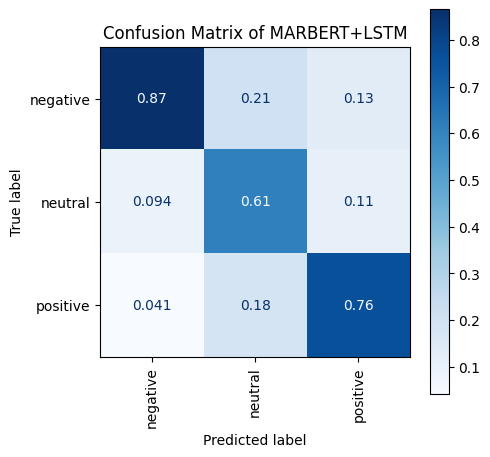

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


loss = 0.9162572739405667, val_loss =0.7930741183777541, accuracy = 0.5392941236495972, val_accuracy = 0.6213333606719971


Epoch 2: 100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


loss = 0.7217711272766373, val_loss =0.6509460593688591, accuracy = 0.6941176652908325, val_accuracy = 0.679111123085022


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


A model was saved at accuracy = 0.7902222275733948
loss = 0.6388863662388912, val_loss =0.5315125581001959, accuracy = 0.7498039603233337, val_accuracy = 0.7902222275733948


Epoch 4: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


loss = 0.5703640339360687, val_loss =0.5572910901605569, accuracy = 0.7825882434844971, val_accuracy = 0.7528889179229736


Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


loss = 0.5520132727614393, val_loss =0.5177436522500175, accuracy = 0.7860392332077026, val_accuracy = 0.7662222385406494


Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.5329070616100651, val_loss =0.5057142921313524, accuracy = 0.7949804067611694, val_accuracy = 0.781333327293396


Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


A model was saved at accuracy = 0.7902222275733948
loss = 0.5141421312286633, val_loss =0.4902509423073963, accuracy = 0.800000011920929, val_accuracy = 0.7902222275733948


Epoch 8: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


loss = 0.49688375468487583, val_loss =0.5081287678848866, accuracy = 0.8058039546012878, val_accuracy = 0.765333354473114


Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.68it/s]


A model was saved at accuracy = 0.8035555481910706
loss = 0.49793969015610773, val_loss =0.4812043556149812, accuracy = 0.8061176538467407, val_accuracy = 0.8035555481910706


Epoch 10: 100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


A model was saved at accuracy = 0.804444432258606
loss = 0.4673546053886689, val_loss =0.4673072198852629, accuracy = 0.8101961016654968, val_accuracy = 0.804444432258606


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


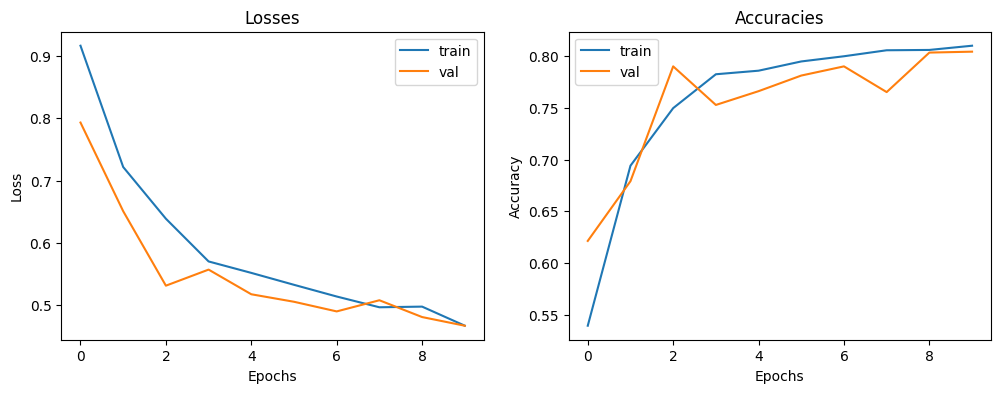

learning rate = 0.003
Test correct = 525

Test total dataitem = 750

Test Accuracy = 0.699999988079071

              precision    recall  f1-score   support

    negative       0.80      0.58      0.68       250
     neutral       0.63      0.79      0.70       250
    positive       0.72      0.72      0.72       250

    accuracy                           0.70       750
   macro avg       0.72      0.70      0.70       750
weighted avg       0.72      0.70      0.70       750



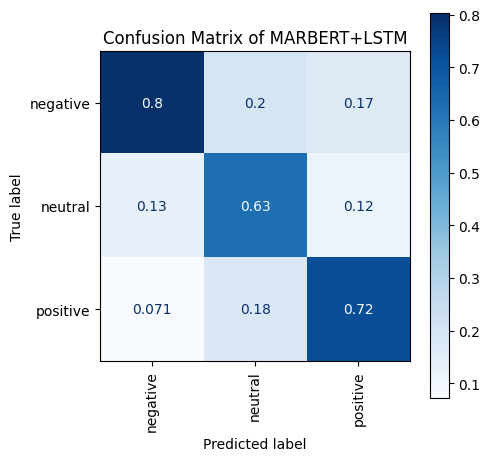

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]


loss = 1.0959269453847829, val_loss =1.0821182552079025, accuracy = 0.3656470775604248, val_accuracy = 0.4328888952732086


Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 1.0689210229617758, val_loss =1.013487300181107, accuracy = 0.43027451634407043, val_accuracy = 0.4951111078262329


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.9748261503475413, val_loss =0.8447954745064057, accuracy = 0.561098039150238, val_accuracy = 0.6355555653572083


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


loss = 0.8647294437937224, val_loss =0.7367463691842493, accuracy = 0.628862738609314, val_accuracy = 0.695111095905304


Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.7521062223345283, val_loss =0.6842101828825126, accuracy = 0.7069804072380066, val_accuracy = 0.7128888964653015


Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


loss = 0.7057675721536343, val_loss =0.6383504247252323, accuracy = 0.7218823432922363, val_accuracy = 0.7360000014305115


Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.667779302265292, val_loss =0.6038425557316048, accuracy = 0.7391372919082642, val_accuracy = 0.7573333382606506


Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.6490253672651791, val_loss =0.5910312062689256, accuracy = 0.7491765022277832, val_accuracy = 0.7662222385406494


Epoch 9: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.6165073775578304, val_loss =0.5509421943417538, accuracy = 0.7662745118141174, val_accuracy = 0.7786666750907898


Epoch 10: 100%|██████████| 100/100 [00:16<00:00,  6.01it/s]


loss = 0.6191572104817645, val_loss =0.6004220072776792, accuracy = 0.7645490169525146, val_accuracy = 0.7244444489479065


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


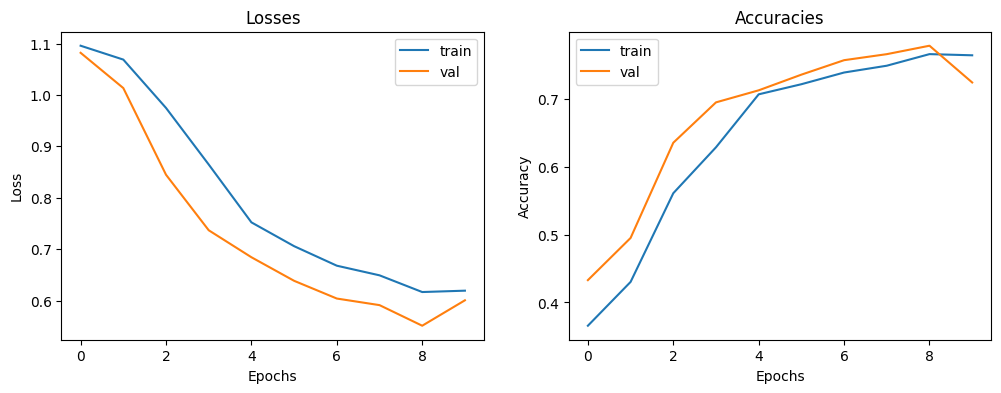

learning rate = 0.0001
Test correct = 465

Test total dataitem = 750

Test Accuracy = 0.6200000047683716

              precision    recall  f1-score   support

    negative       0.82      0.49      0.61       250
     neutral       0.58      0.52      0.54       250
    positive       0.57      0.85      0.68       250

    accuracy                           0.62       750
   macro avg       0.65      0.62      0.61       750
weighted avg       0.65      0.62      0.61       750



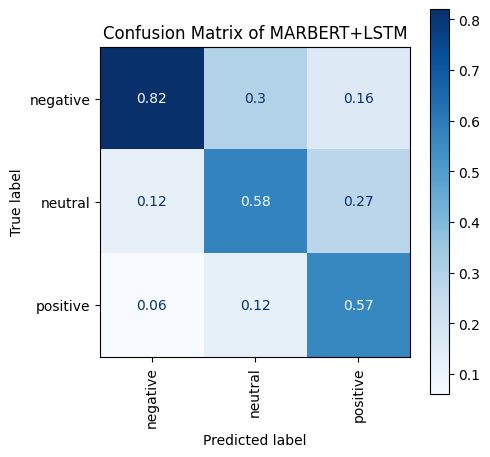

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.73it/s]


loss = 1.0882753305975348, val_loss =1.0168177902449604, accuracy = 0.38556864857673645, val_accuracy = 0.48444443941116333


Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


loss = 0.964173192496095, val_loss =0.7944749986687144, accuracy = 0.5221961140632629, val_accuracy = 0.6204444766044617


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.8129101905273423, val_loss =0.671690019580337, accuracy = 0.6404706239700317, val_accuracy = 0.7306666970252991


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


loss = 0.6994724741362771, val_loss =0.5854607752364202, accuracy = 0.7132549285888672, val_accuracy = 0.7635555863380432


Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


loss = 0.6579488825210921, val_loss =0.6468818400934578, accuracy = 0.7361568808555603, val_accuracy = 0.7324444651603699


Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


loss = 0.6106498893310252, val_loss =0.6218111041038159, accuracy = 0.7573333382606506, val_accuracy = 0.7546666860580444


Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


loss = 0.6075599712810921, val_loss =0.5623029045225401, accuracy = 0.7546666860580444, val_accuracy = 0.7839999794960022


Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


loss = 0.588581129343495, val_loss =0.5504572589828579, accuracy = 0.7727059125900269, val_accuracy = 0.7893333435058594


Epoch 9: 100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


A model was saved at accuracy = 0.7902222275733948
loss = 0.5698079461436012, val_loss =0.5242140854111217, accuracy = 0.7766274809837341, val_accuracy = 0.7902222275733948


Epoch 10: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


A model was saved at accuracy = 0.7964444756507874
loss = 0.5592284391322828, val_loss =0.5163276329675991, accuracy = 0.7885490655899048, val_accuracy = 0.7964444756507874


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


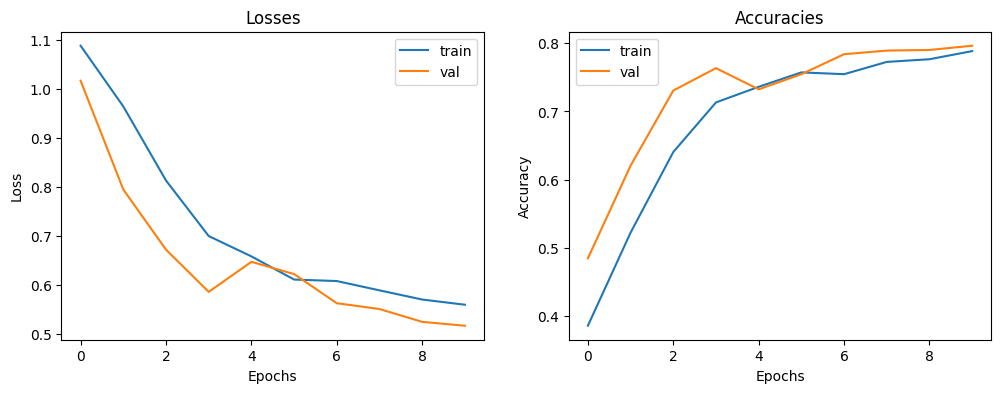

learning rate = 0.0002
Test correct = 543

Test total dataitem = 750

Test Accuracy = 0.7239999771118164

              precision    recall  f1-score   support

    negative       0.79      0.72      0.75       250
     neutral       0.71      0.73      0.72       250
    positive       0.68      0.72      0.70       250

    accuracy                           0.72       750
   macro avg       0.73      0.72      0.72       750
weighted avg       0.73      0.72      0.72       750



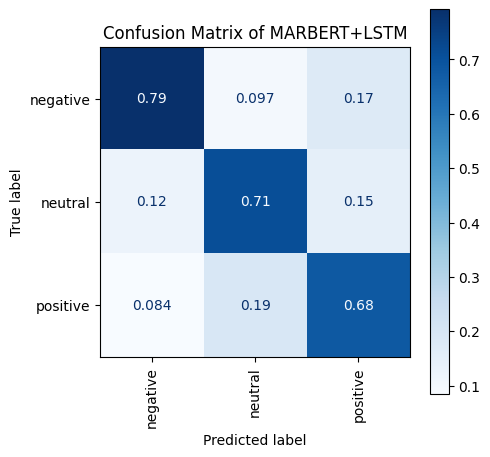

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.42it/s]


loss = 1.0388106594803945, val_loss =0.9274465110339644, accuracy = 0.4476862847805023, val_accuracy = 0.56977778673172


Epoch 2: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


loss = 0.82904067959301, val_loss =0.7170707751969198, accuracy = 0.6089411973953247, val_accuracy = 0.667555570602417


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


loss = 0.732654604000636, val_loss =0.7935463663539499, accuracy = 0.6771764755249023, val_accuracy = 0.6577777862548828


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.6698563144671295, val_loss =0.6324128676143821, accuracy = 0.7269019484519958, val_accuracy = 0.7413333654403687


Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


loss = 0.6260716902594345, val_loss =0.6125669703212658, accuracy = 0.7441568970680237, val_accuracy = 0.758222222328186


Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.5934739228261351, val_loss =0.7231106359618612, accuracy = 0.7642353177070618, val_accuracy = 0.7146666646003723


Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.5734956172916044, val_loss =0.6501443723378603, accuracy = 0.7750588655471802, val_accuracy = 0.7235555648803711


Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


loss = 0.5650720670312552, val_loss =0.5699070345209066, accuracy = 0.784000039100647, val_accuracy = 0.765333354473114


Epoch 9: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


loss = 0.5431760060053585, val_loss =0.6475201937125592, accuracy = 0.7855686545372009, val_accuracy = 0.7182222008705139


Epoch 10: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.5356282877259768, val_loss =0.607227023563282, accuracy = 0.7880784273147583, val_accuracy = 0.7440000176429749


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


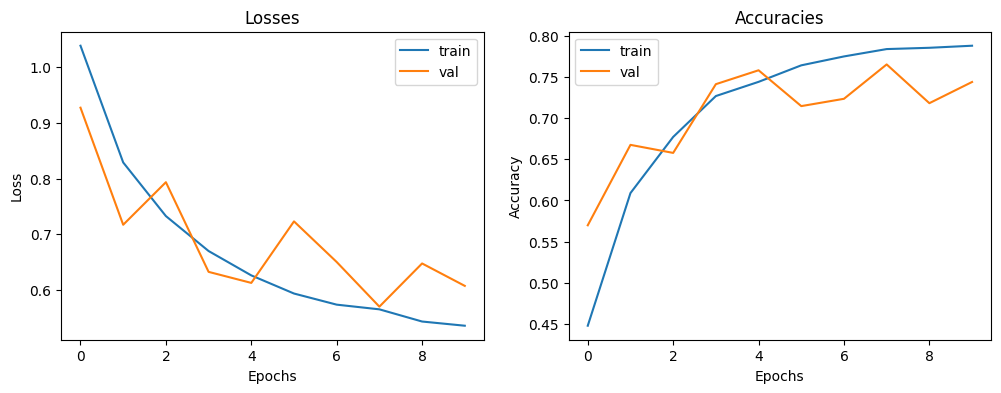

learning rate = 0.0003
Test correct = 454

Test total dataitem = 750

Test Accuracy = 0.6053333282470703

              precision    recall  f1-score   support

    negative       0.78      0.34      0.47       250
     neutral       0.57      0.85      0.68       250
    positive       0.58      0.63      0.61       250

    accuracy                           0.61       750
   macro avg       0.64      0.61      0.59       750
weighted avg       0.64      0.61      0.59       750



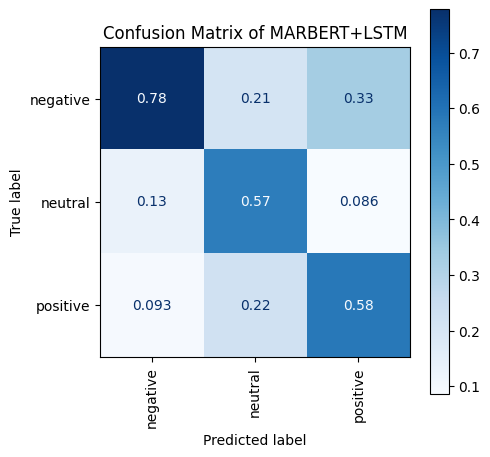

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


loss = 1.11784676563735, val_loss =1.1058758196432155, accuracy = 0.33349019289016724, val_accuracy = 0.3253333270549774


Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 1.1068803045191826, val_loss =1.0971483313492514, accuracy = 0.3410196006298065, val_accuracy = 0.3342222273349762


Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 1.102607645335106, val_loss =1.0913582411762495, accuracy = 0.33945098519325256, val_accuracy = 0.3777777850627899


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 1.096536611240978, val_loss =1.0878644601411156, accuracy = 0.3581176698207855, val_accuracy = 0.36800000071525574


Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 1.092795436788016, val_loss =1.0847636746751652, accuracy = 0.3656470775604248, val_accuracy = 0.36088889837265015


Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 1.0889288373890882, val_loss =1.0803207823204004, accuracy = 0.3781960904598236, val_accuracy = 0.36622223258018494


Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


loss = 1.085593328175541, val_loss =1.0771833330521488, accuracy = 0.38682353496551514, val_accuracy = 0.3795555531978607


Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 1.0813532041548155, val_loss =1.0708829822541737, accuracy = 0.39592158794403076, val_accuracy = 0.3919999897480011


Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 1.0767626126158314, val_loss =1.0661188126807366, accuracy = 0.3968627452850342, val_accuracy = 0.42133334279060364


Epoch 10: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


loss = 1.0757318910244758, val_loss =1.0586495382918253, accuracy = 0.4032941162586212, val_accuracy = 0.4320000112056732


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


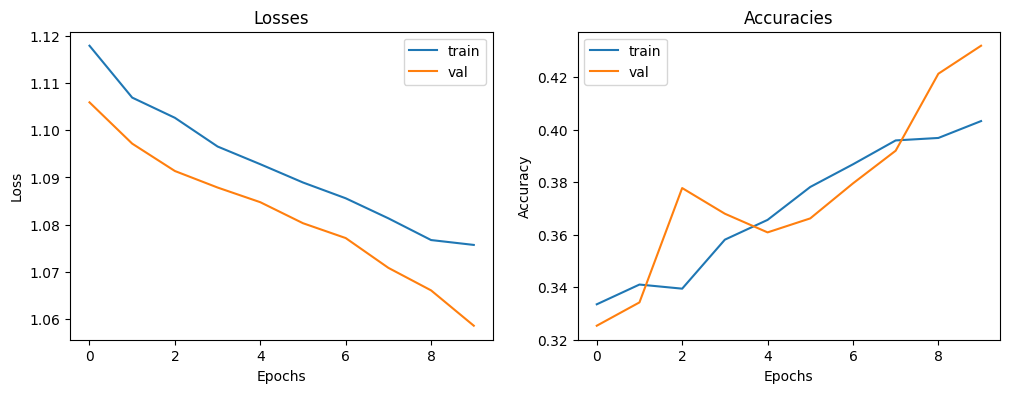

learning rate = 1e-05
Test correct = 324

Test total dataitem = 750

Test Accuracy = 0.43199998140335083

              precision    recall  f1-score   support

    negative       0.48      0.63      0.55       250
     neutral       0.39      0.67      0.50       250
    positive       0.00      0.00      0.00       250

    accuracy                           0.43       750
   macro avg       0.29      0.43      0.35       750
weighted avg       0.29      0.43      0.35       750



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


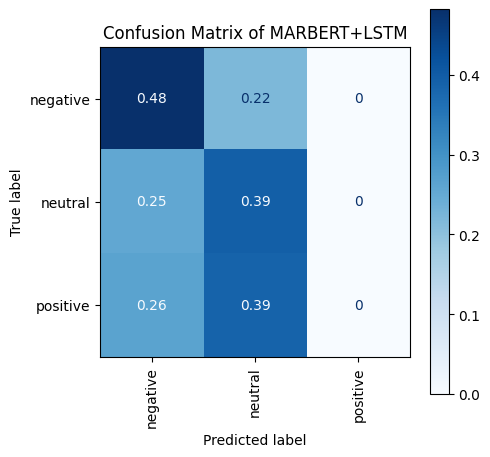

In [ ]:
bidirectional=False
num_layers=1
hidden_size1=128
hidden_size2=32
learning_rates=[0.001,0.002,0.003,0.0001,0.0002,0.0003,0.00001]
for learning_rate in learning_rates:
  model=RNN_AraBERT(hidden_size1,hidden_size2,num_layers,bidirectional,droprate).to(device,non_blocking=True)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  print(f'learning rate = {learning_rate}')
  model_name='MARBERT+LSTM'
  test_and_report(model,test_loader,model_name)

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:19<00:00,  5.24it/s]


loss = 0.9939940321010847, val_loss =0.8227355251569083, accuracy = 0.5206274390220642, val_accuracy = 0.6186666488647461


Epoch 2: 100%|██████████| 100/100 [00:21<00:00,  4.72it/s]


loss = 0.726184865277983, val_loss =0.637480078861481, accuracy = 0.6988235712051392, val_accuracy = 0.7306666970252991


Epoch 3: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


loss = 0.6023929863529525, val_loss =0.5692832789696017, accuracy = 0.7526274919509888, val_accuracy = 0.7626667022705078


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  6.13it/s]


loss = 0.5492428726507113, val_loss =0.5490274769642954, accuracy = 0.771294116973877, val_accuracy = 0.781333327293396


Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.5186499415541319, val_loss =0.5341150335914752, accuracy = 0.786823570728302, val_accuracy = 0.7617777585983276


Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


A model was saved at accuracy = 0.7911111116409302
loss = 0.5075779188691731, val_loss =0.5097319540210584, accuracy = 0.7907451391220093, val_accuracy = 0.7911111116409302


Epoch 7: 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


loss = 0.49482070583849397, val_loss =0.5163253979963602, accuracy = 0.8017255067825317, val_accuracy = 0.7795555591583252


Epoch 8: 100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


loss = 0.48081826980621256, val_loss =0.5198997670973636, accuracy = 0.79560786485672, val_accuracy = 0.7839999794960022


Epoch 9: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


loss = 0.4644729529072953, val_loss =0.5041515502406209, accuracy = 0.8097255229949951, val_accuracy = 0.7893333435058594


Epoch 10: 100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


loss = 0.45772551791652893, val_loss =0.5117553089194817, accuracy = 0.8149020075798035, val_accuracy = 0.7742222547531128


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


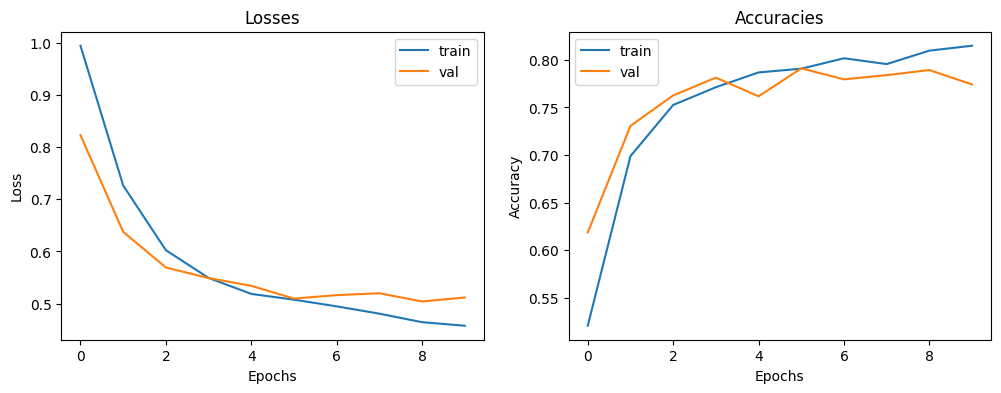

dropout rate = 0
Test correct = 526

Test total dataitem = 750

Test Accuracy = 0.7013333439826965

              precision    recall  f1-score   support

    negative       0.81      0.62      0.70       250
     neutral       0.69      0.64      0.67       250
    positive       0.64      0.85      0.73       250

    accuracy                           0.70       750
   macro avg       0.72      0.70      0.70       750
weighted avg       0.72      0.70      0.70       750



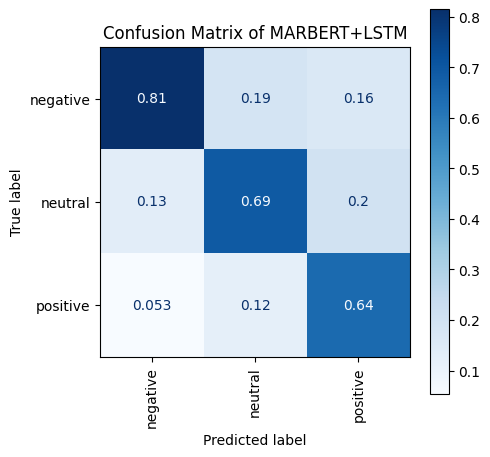

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


loss = 1.0185136805702812, val_loss =0.8303964525438823, accuracy = 0.5025882720947266, val_accuracy = 0.6480000019073486


Epoch 2: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.7308311085811016, val_loss =0.6238945267002752, accuracy = 0.6958431601524353, val_accuracy = 0.7528889179229736


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.6273023408840751, val_loss =0.5681962950057078, accuracy = 0.7507451176643372, val_accuracy = 0.765333354473114


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


loss = 0.5954031172752058, val_loss =0.5686620829775321, accuracy = 0.7618823647499084, val_accuracy = 0.7715555429458618


Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.5491417032993139, val_loss =0.5854729527612629, accuracy = 0.778509795665741, val_accuracy = 0.7662222385406494


Epoch 6: 100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


loss = 0.5480253239156483, val_loss =0.5190206797342181, accuracy = 0.7827451229095459, val_accuracy = 0.7760000228881836


Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


A model was saved at accuracy = 0.7946666479110718
loss = 0.5160685367247975, val_loss =0.5180795250199881, accuracy = 0.7909019589424133, val_accuracy = 0.7946666479110718


Epoch 8: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


loss = 0.5045918367293444, val_loss =0.505908603709834, accuracy = 0.7982745170593262, val_accuracy = 0.7857778072357178


Epoch 9: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


loss = 0.49598363931296774, val_loss =0.5425869172747978, accuracy = 0.8020392060279846, val_accuracy = 0.7733333706855774


Epoch 10: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


A model was saved at accuracy = 0.7946666479110718
loss = 0.4848054845427825, val_loss =0.4949139076741592, accuracy = 0.8018823862075806, val_accuracy = 0.7946666479110718


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


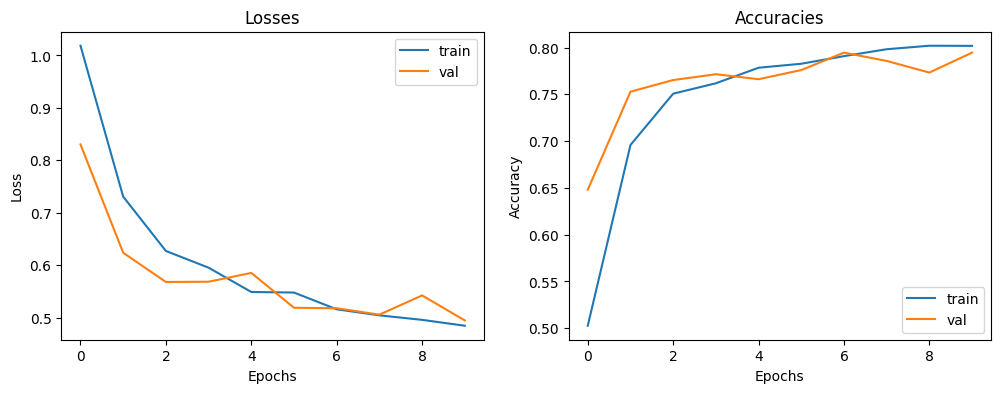

dropout rate = 0.1
Test correct = 523

Test total dataitem = 750

Test Accuracy = 0.6973333358764648

              precision    recall  f1-score   support

    negative       0.80      0.60      0.68       250
     neutral       0.61      0.80      0.69       250
    positive       0.74      0.70      0.72       250

    accuracy                           0.70       750
   macro avg       0.72      0.70      0.70       750
weighted avg       0.72      0.70      0.70       750



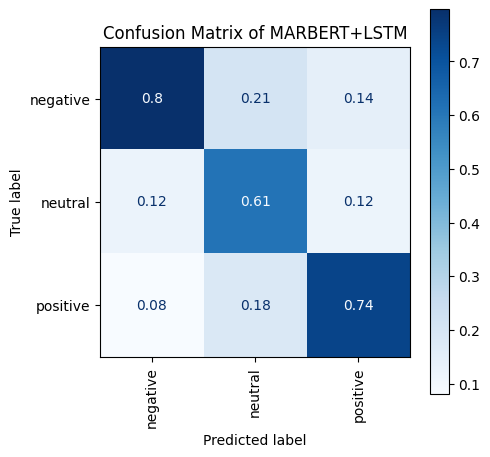

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:20<00:00,  4.77it/s]


loss = 1.0330559098133698, val_loss =0.9184429850268483, accuracy = 0.4605490267276764, val_accuracy = 0.5288888812065125


Epoch 2: 100%|██████████| 100/100 [00:19<00:00,  5.25it/s]


loss = 0.7997868144867393, val_loss =0.7067432977411583, accuracy = 0.6462745070457458, val_accuracy = 0.7048888802528381


Epoch 3: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


loss = 0.659739975430943, val_loss =0.5900848680233524, accuracy = 0.7334902286529541, val_accuracy = 0.7635555863380432


Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


loss = 0.619849507249847, val_loss =0.5511525811618068, accuracy = 0.7520000338554382, val_accuracy = 0.7742222547531128


Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  6.01it/s]


loss = 0.5659468772425092, val_loss =0.5548926212630156, accuracy = 0.7753725647926331, val_accuracy = 0.7671111226081848


Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.5441911664268693, val_loss =0.587780835352953, accuracy = 0.7854117751121521, val_accuracy = 0.7688888907432556


Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.5246598300871436, val_loss =0.5902533025276993, accuracy = 0.7918431758880615, val_accuracy = 0.7351111173629761


Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


A model was saved at accuracy = 0.8008888959884644
loss = 0.5091337916207797, val_loss =0.4939173799866912, accuracy = 0.7996863126754761, val_accuracy = 0.8008888959884644


Epoch 9: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


A model was saved at accuracy = 0.7964444756507874
loss = 0.4936189840677887, val_loss =0.5112066200921066, accuracy = 0.8032941222190857, val_accuracy = 0.7964444756507874


Epoch 10: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


loss = 0.4930056711909744, val_loss =0.5279986449782478, accuracy = 0.8032941222190857, val_accuracy = 0.7857778072357178


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


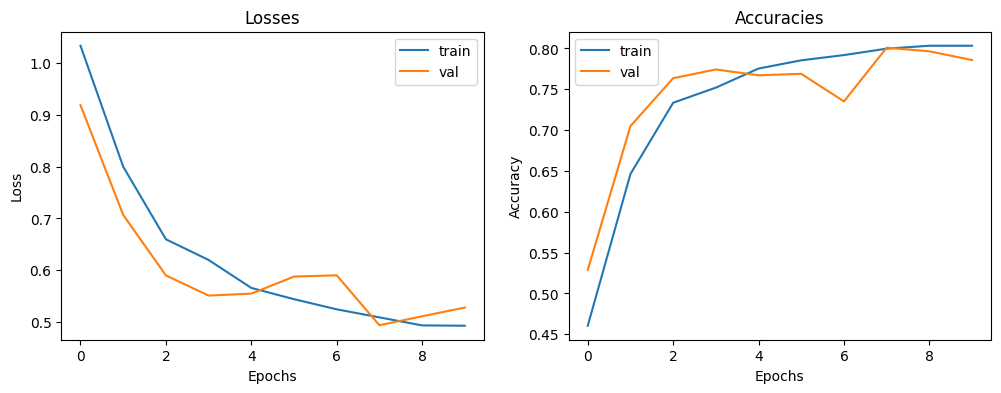

dropout rate = 0.2
Test correct = 493

Test total dataitem = 750

Test Accuracy = 0.6573333144187927

              precision    recall  f1-score   support

    negative       0.87      0.44      0.59       250
     neutral       0.58      0.82      0.68       250
    positive       0.65      0.71      0.68       250

    accuracy                           0.66       750
   macro avg       0.70      0.66      0.65       750
weighted avg       0.70      0.66      0.65       750



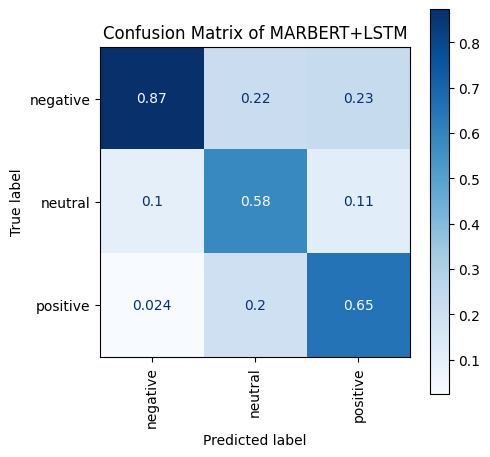

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.70it/s]


loss = 1.0355905798951595, val_loss =0.8657185586572096, accuracy = 0.466823548078537, val_accuracy = 0.6000000238418579


Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.7992686483850971, val_loss =0.6627377071685309, accuracy = 0.6586666703224182, val_accuracy = 0.7271111011505127


Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.666707342184419, val_loss =0.6181857281588417, accuracy = 0.7353725433349609, val_accuracy = 0.7457777857780457


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.6280053073767713, val_loss =0.5722022615323318, accuracy = 0.7504314184188843, val_accuracy = 0.7599999904632568


Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.578925758646316, val_loss =0.5554222728035905, accuracy = 0.7727059125900269, val_accuracy = 0.7706666588783264


Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.564215243172924, val_loss =0.5396093380145935, accuracy = 0.7774117588996887, val_accuracy = 0.776888906955719


Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


loss = 0.5418121444425159, val_loss =0.5634251230731679, accuracy = 0.7872941493988037, val_accuracy = 0.758222222328186


Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


loss = 0.5264514466334209, val_loss =0.5433054920835024, accuracy = 0.7860392332077026, val_accuracy = 0.7848889231681824


Epoch 9: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


A model was saved at accuracy = 0.7937777638435364
loss = 0.5124025025771128, val_loss =0.5150476489566559, accuracy = 0.7943529486656189, val_accuracy = 0.7937777638435364


Epoch 10: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s]


A model was saved at accuracy = 0.7946666479110718
loss = 0.49450057236540235, val_loss =0.5052587660894123, accuracy = 0.8026666641235352, val_accuracy = 0.7946666479110718


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


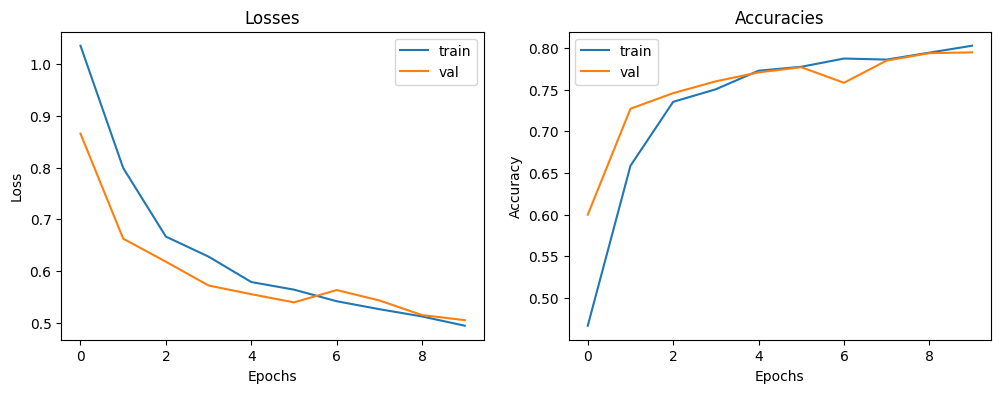

dropout rate = 0.3
Test correct = 531

Test total dataitem = 750

Test Accuracy = 0.7080000042915344

              precision    recall  f1-score   support

    negative       0.80      0.62      0.70       250
     neutral       0.67      0.73      0.70       250
    positive       0.68      0.77      0.72       250

    accuracy                           0.71       750
   macro avg       0.72      0.71      0.71       750
weighted avg       0.72      0.71      0.71       750



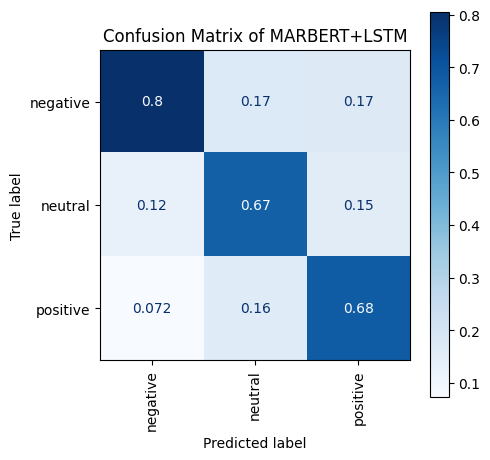

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:21<00:00,  4.73it/s]


loss = 1.0576551553910263, val_loss =0.9331151106745822, accuracy = 0.43168628215789795, val_accuracy = 0.5893333554267883


Epoch 2: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.877370467737126, val_loss =0.7687150801814444, accuracy = 0.5821176767349243, val_accuracy = 0.5884444713592529


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.7455933914073364, val_loss =0.6069061035467256, accuracy = 0.6752941608428955, val_accuracy = 0.7591111063957214


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


loss = 0.6637130329804589, val_loss =0.5869787763490872, accuracy = 0.7352157235145569, val_accuracy = 0.7484444379806519


Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


A model was saved at accuracy = 0.7946666479110718
loss = 0.638331072285098, val_loss =0.5313587674309812, accuracy = 0.750901997089386, val_accuracy = 0.7946666479110718


Epoch 6: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


loss = 0.578978388712245, val_loss =0.5368554494601088, accuracy = 0.7774117588996887, val_accuracy = 0.7857778072357178


Epoch 7: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


loss = 0.5716430145060085, val_loss =0.5653616366622597, accuracy = 0.7807059288024902, val_accuracy = 0.781333327293396


Epoch 8: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


loss = 0.5603908266676239, val_loss =0.6109697707956379, accuracy = 0.7799215912818909, val_accuracy = 0.7475555539131165


Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.61it/s]


loss = 0.5542044555774975, val_loss =0.5300497347964886, accuracy = 0.7882353067398071, val_accuracy = 0.7831110954284668


Epoch 10: 100%|██████████| 100/100 [00:16<00:00,  6.04it/s]


loss = 0.5335021802923481, val_loss =0.6413324213086804, accuracy = 0.789647102355957, val_accuracy = 0.7431111335754395


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


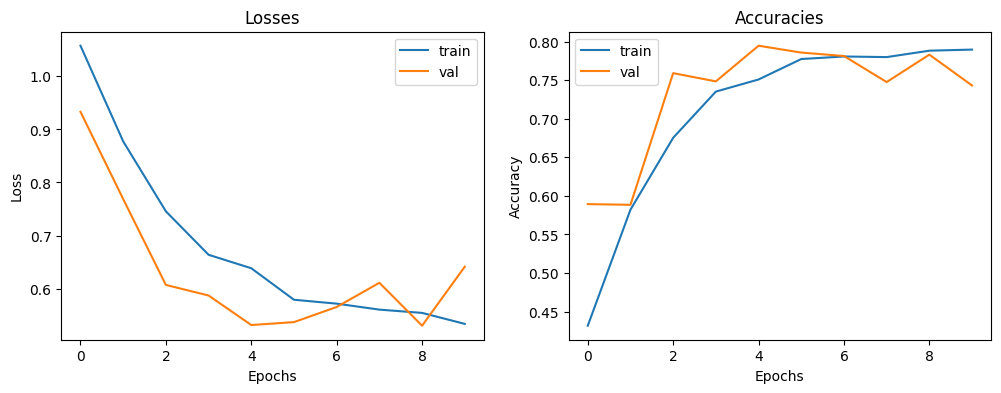

dropout rate = 0.4
Test correct = 461

Test total dataitem = 750

Test Accuracy = 0.6146666407585144

              precision    recall  f1-score   support

    negative       0.86      0.37      0.52       250
     neutral       0.51      0.90      0.65       250
    positive       0.72      0.57      0.64       250

    accuracy                           0.61       750
   macro avg       0.70      0.61      0.60       750
weighted avg       0.70      0.61      0.60       750



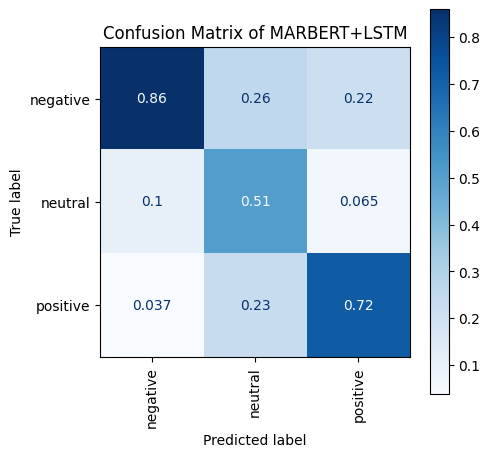

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


loss = 1.0639894785871729, val_loss =0.9227193885779305, accuracy = 0.41286274790763855, val_accuracy = 0.5928888916969299


Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.73it/s]


loss = 0.8928685310725213, val_loss =0.7336997289279429, accuracy = 0.5559215545654297, val_accuracy = 0.5982222557067871


Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


loss = 0.7920514120123885, val_loss =0.757452072249341, accuracy = 0.6111372709274292, val_accuracy = 0.5911111235618591


Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.7421927532004282, val_loss =0.6564702670169521, accuracy = 0.6505098342895508, val_accuracy = 0.6977778077125549


Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.671748528660759, val_loss =0.5830453151476733, accuracy = 0.7141960859298706, val_accuracy = 0.7671111226081848


Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.6316775213121132, val_loss =0.599912723717631, accuracy = 0.7413333654403687, val_accuracy = 0.7671111226081848


Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


A model was saved at accuracy = 0.7946666479110718
loss = 0.5952945002345701, val_loss =0.5779858206292989, accuracy = 0.7647058963775635, val_accuracy = 0.7946666479110718


Epoch 8: 100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


loss = 0.587910242143126, val_loss =0.5247141234840428, accuracy = 0.7730196118354797, val_accuracy = 0.7893333435058594


Epoch 9: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


A model was saved at accuracy = 0.7902222275733948
loss = 0.5605394193826342, val_loss =0.5226167930032953, accuracy = 0.7788235545158386, val_accuracy = 0.7902222275733948


Epoch 10: 100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


A model was saved at accuracy = 0.7964444756507874
loss = 0.5498246865140264, val_loss =0.5297206869591109, accuracy = 0.7833725810050964, val_accuracy = 0.7964444756507874


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


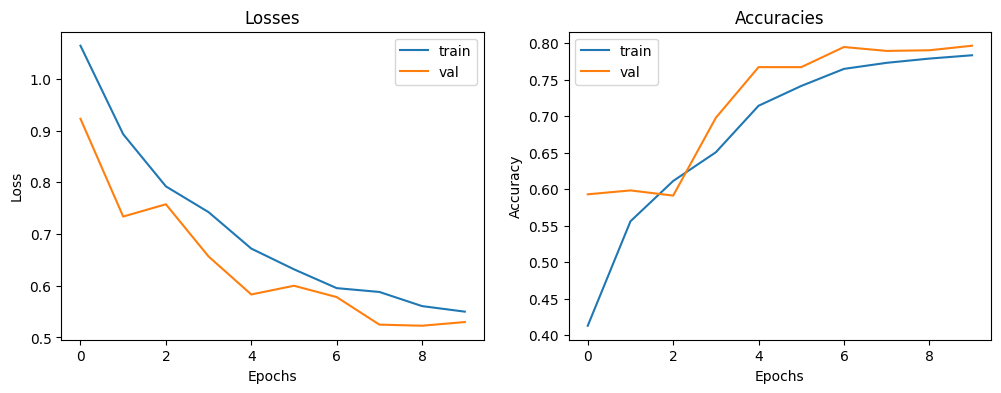

dropout rate = 0.5
Test correct = 533

Test total dataitem = 750

Test Accuracy = 0.7106666564941406

              precision    recall  f1-score   support

    negative       0.81      0.70      0.75       250
     neutral       0.68      0.66      0.67       250
    positive       0.66      0.78      0.72       250

    accuracy                           0.71       750
   macro avg       0.72      0.71      0.71       750
weighted avg       0.72      0.71      0.71       750



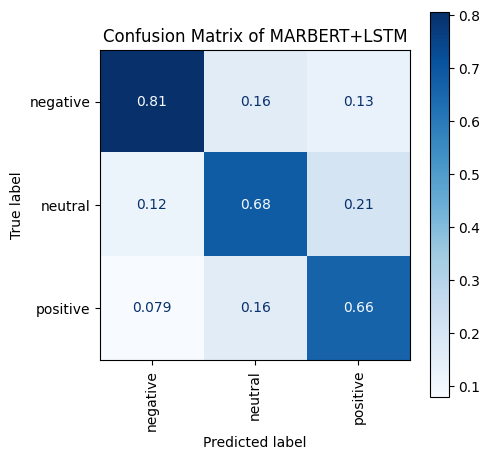

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:20<00:00,  4.96it/s]


loss = 1.0902109359528345, val_loss =1.018079943675268, accuracy = 0.3816470801830292, val_accuracy = 0.4915555715560913


Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


loss = 0.9756473099743613, val_loss =0.8236436161195843, accuracy = 0.5189019441604614, val_accuracy = 0.5991111397743225


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


loss = 0.8687747105780353, val_loss =0.8811283504356863, accuracy = 0.586980402469635, val_accuracy = 0.6026666760444641


Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.778465035994738, val_loss =1.0245191151097588, accuracy = 0.6561568975448608, val_accuracy = 0.6062222123146057


Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.7225613571866114, val_loss =0.7262277857516892, accuracy = 0.7072941064834595, val_accuracy = 0.7173333168029785


Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.6716545392557494, val_loss =0.6789130174882892, accuracy = 0.7331764698028564, val_accuracy = 0.7360000014305115


Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.6547559619846378, val_loss =0.6010799308005244, accuracy = 0.7483921647071838, val_accuracy = 0.7715555429458618


Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.638510937141646, val_loss =0.5729138694693791, accuracy = 0.756549060344696, val_accuracy = 0.7742222547531128


Epoch 9: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


A model was saved at accuracy = 0.7946666479110718
loss = 0.6081545315555996, val_loss =0.5381153006838231, accuracy = 0.7599999904632568, val_accuracy = 0.7946666479110718


Epoch 10: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


loss = 0.6115262830078572, val_loss =0.5605789031803695, accuracy = 0.7589019536972046, val_accuracy = 0.7857778072357178


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


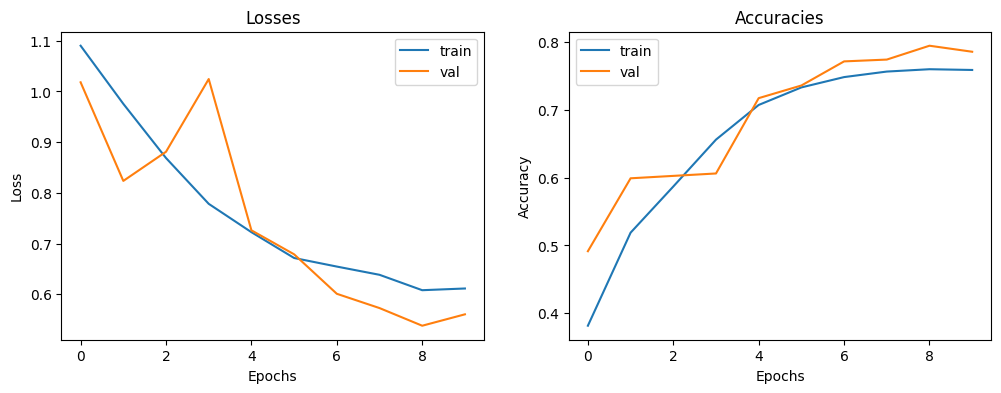

dropout rate = 0.6
Test correct = 541

Test total dataitem = 750

Test Accuracy = 0.7213333249092102

              precision    recall  f1-score   support

    negative       0.79      0.73      0.76       250
     neutral       0.64      0.73      0.68       250
    positive       0.76      0.70      0.73       250

    accuracy                           0.72       750
   macro avg       0.73      0.72      0.72       750
weighted avg       0.73      0.72      0.72       750



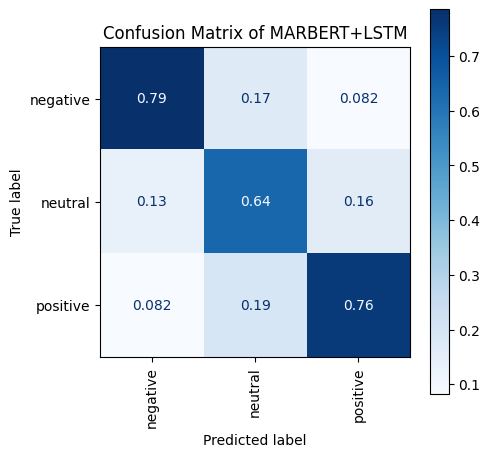

In [ ]:
bidirectional=False
num_layers=1
hidden_size1=128
hidden_size2=32
learning_rate=0.0002
drop_rates=[0,0.1,0.2,0.3,0.4,0.5,0.6]
for drop_rate in drop_rates:
  model=RNN_AraBERT(hidden_size1,hidden_size2,num_layers,bidirectional,drop_rate).to(device,non_blocking=True)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  print(f'dropout rate = {drop_rate}')
  model_name='MARBERT+LSTM'
  test_and_report(model,test_loader,model_name)

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


loss = 1.0909995952783487, val_loss =1.0387034614209656, accuracy = 0.3753725588321686, val_accuracy = 0.47466668486595154


Epoch 2: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


loss = 0.9976500777510675, val_loss =0.877350853774249, accuracy = 0.4861176609992981, val_accuracy = 0.5457777976989746


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


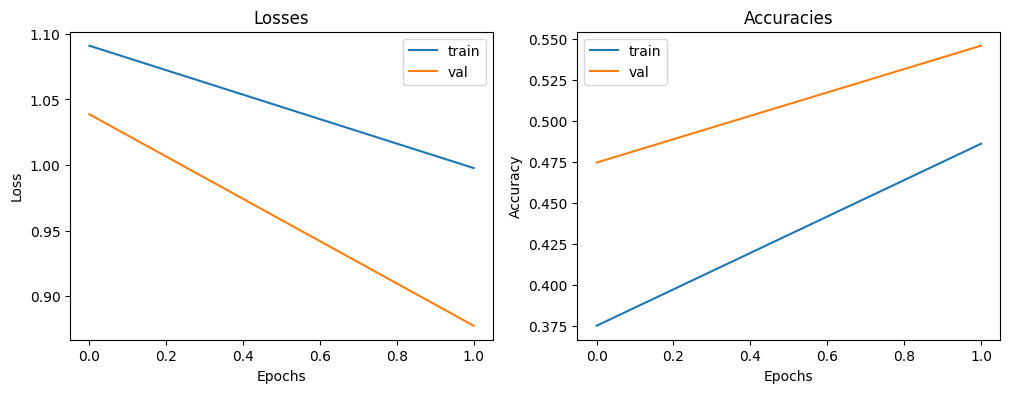

epoch = 2
Test correct = 343

Test total dataitem = 750

Test Accuracy = 0.4573333263397217

              precision    recall  f1-score   support

    negative       0.65      0.45      0.53       250
     neutral       0.43      0.85      0.57       250
    positive       0.21      0.07      0.11       250

    accuracy                           0.46       750
   macro avg       0.43      0.46      0.40       750
weighted avg       0.43      0.46      0.40       750



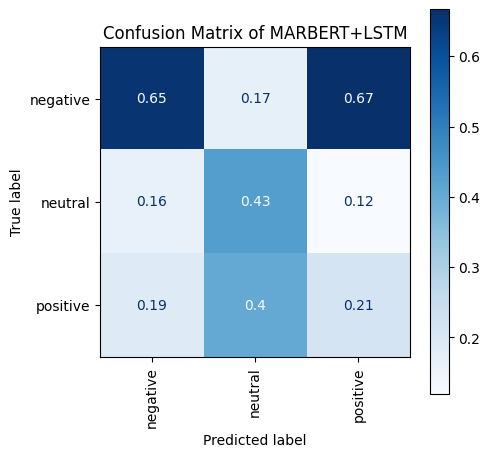

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


loss = 1.098760393818076, val_loss =1.0552508588642577, accuracy = 0.3700392246246338, val_accuracy = 0.41777777671813965


Epoch 2: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 1.04619661307834, val_loss =0.9365465944666449, accuracy = 0.44501960277557373, val_accuracy = 0.5937777757644653


Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.9057324029496223, val_loss =0.7558003223963312, accuracy = 0.5676862597465515, val_accuracy = 0.6159999966621399


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


loss = 0.7825212395524126, val_loss =0.6501352440354057, accuracy = 0.6555294394493103, val_accuracy = 0.7395555377006531


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


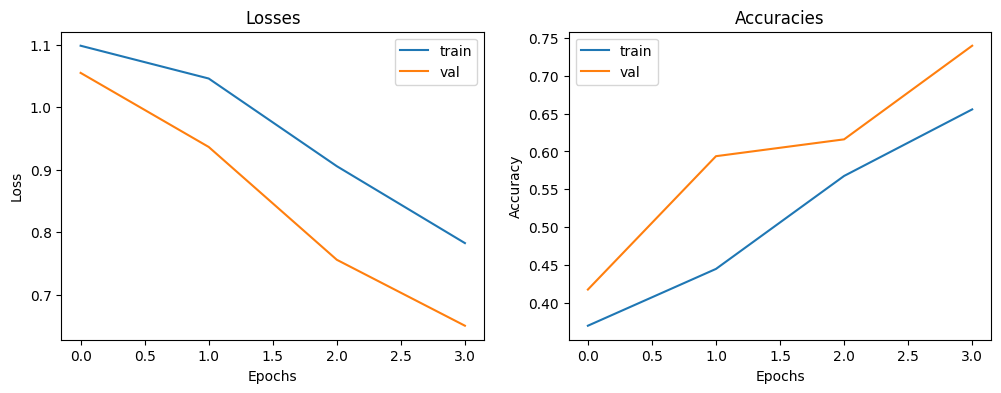

epoch = 4
Test correct = 506

Test total dataitem = 750

Test Accuracy = 0.6746666431427002

              precision    recall  f1-score   support

    negative       0.80      0.67      0.73       250
     neutral       0.68      0.70      0.69       250
    positive       0.58      0.65      0.61       250

    accuracy                           0.67       750
   macro avg       0.69      0.67      0.68       750
weighted avg       0.69      0.67      0.68       750



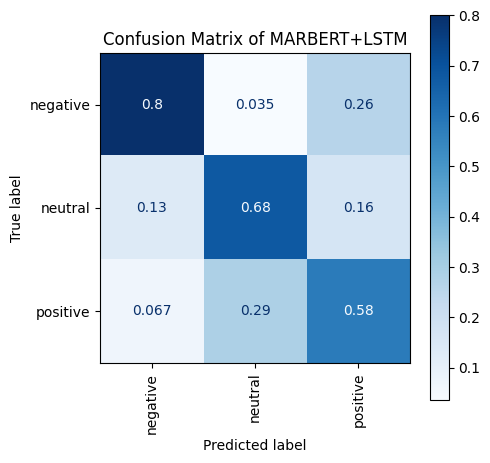

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 1.0879642809941792, val_loss =1.0540696455210492, accuracy = 0.38149020075798035, val_accuracy = 0.5128889083862305


Epoch 2: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


loss = 0.9991638945344872, val_loss =0.8521874045873447, accuracy = 0.5005490183830261, val_accuracy = 0.637333333492279


Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.8555037872843484, val_loss =0.7671168672592819, accuracy = 0.6054902076721191, val_accuracy = 0.68622225522995


Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 0.7267077614871457, val_loss =0.6480213242202617, accuracy = 0.7076078653335571, val_accuracy = 0.7377777695655823


Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


loss = 0.6940731573977339, val_loss =0.6741656563402079, accuracy = 0.7269019484519958, val_accuracy = 0.7066666483879089


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


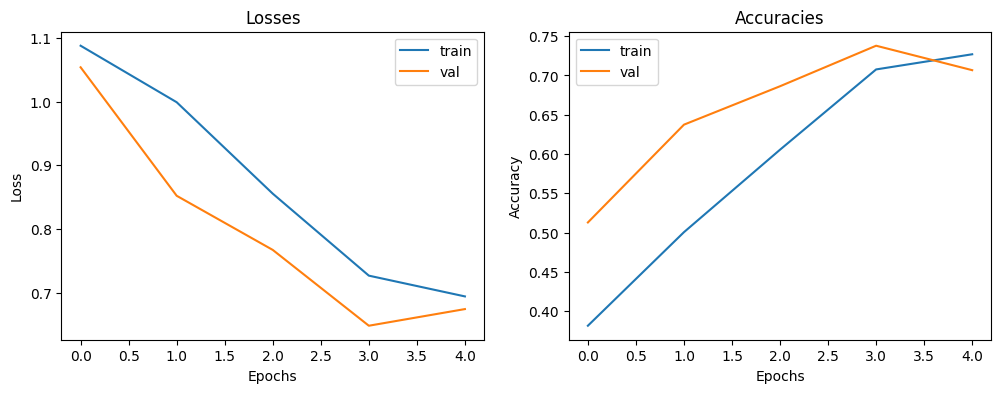

epoch = 5
Test correct = 509

Test total dataitem = 750

Test Accuracy = 0.6786666512489319

              precision    recall  f1-score   support

    negative       0.68      0.93      0.79       250
     neutral       0.60      0.74      0.66       250
    positive       0.90      0.36      0.52       250

    accuracy                           0.68       750
   macro avg       0.73      0.68      0.66       750
weighted avg       0.73      0.68      0.66       750



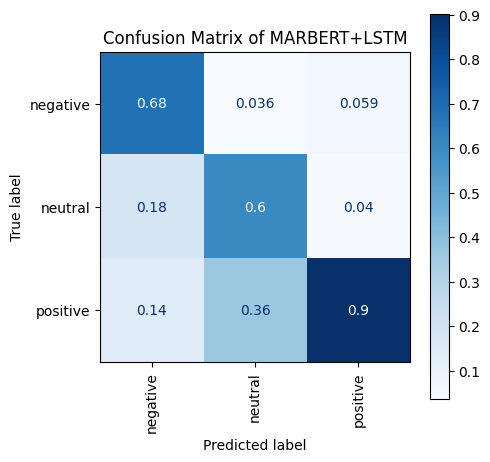

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


loss = 1.0958221117204103, val_loss =1.0338456253185533, accuracy = 0.36988237500190735, val_accuracy = 0.4497777819633484


Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.56it/s]


loss = 0.982010111020563, val_loss =0.8490661934642862, accuracy = 0.5068235397338867, val_accuracy = 0.5822222232818604


Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.68it/s]


loss = 0.8469072756607187, val_loss =0.7237500858017001, accuracy = 0.5954509973526001, val_accuracy = 0.6399999856948853


Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


loss = 0.7510112464356322, val_loss =0.6839716080395265, accuracy = 0.6610196232795715, val_accuracy = 0.7200000286102295


Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.6965891928797161, val_loss =0.6640557157828902, accuracy = 0.7137255072593689, val_accuracy = 0.6995555758476257


Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.6446633661904285, val_loss =0.8024730679511607, accuracy = 0.7427451014518738, val_accuracy = 0.6417778134346008


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


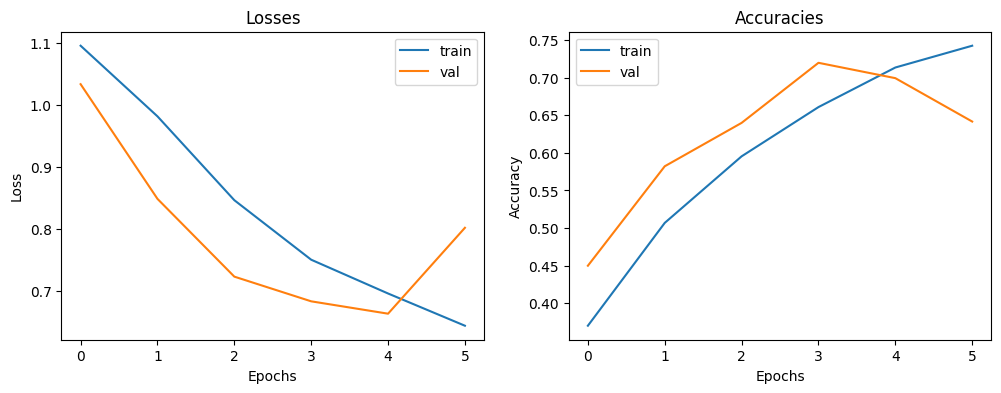

epoch = 6
Test correct = 398

Test total dataitem = 750

Test Accuracy = 0.5306666493415833

              precision    recall  f1-score   support

    negative       0.80      0.35      0.49       250
     neutral       0.77      0.29      0.42       250
    positive       0.44      0.95      0.60       250

    accuracy                           0.53       750
   macro avg       0.67      0.53      0.50       750
weighted avg       0.67      0.53      0.50       750



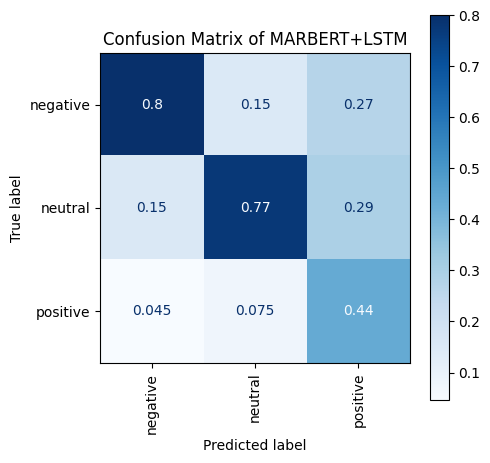

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


loss = 1.0973204333471278, val_loss =1.0622917042916513, accuracy = 0.3629803955554962, val_accuracy = 0.452444463968277


Epoch 2: 100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


loss = 1.0351657008522681, val_loss =0.9321433006185905, accuracy = 0.45192158222198486, val_accuracy = 0.5404444336891174


Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.57it/s]


loss = 0.8910268328553558, val_loss =0.7316161268589985, accuracy = 0.5672156810760498, val_accuracy = 0.6977778077125549


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  6.06it/s]


loss = 0.7916852395282499, val_loss =0.7942745382736742, accuracy = 0.6553725600242615, val_accuracy = 0.674666702747345


Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


loss = 0.6959728085855432, val_loss =0.5792385663174886, accuracy = 0.7116863131523132, val_accuracy = 0.769777774810791


Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


loss = 0.6736478167336015, val_loss =0.7679977591440372, accuracy = 0.7292549014091492, val_accuracy = 0.695111095905304


Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  5.97it/s]


loss = 0.6518044709386781, val_loss =0.7515924685940918, accuracy = 0.7488627433776855, val_accuracy = 0.7235555648803711


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


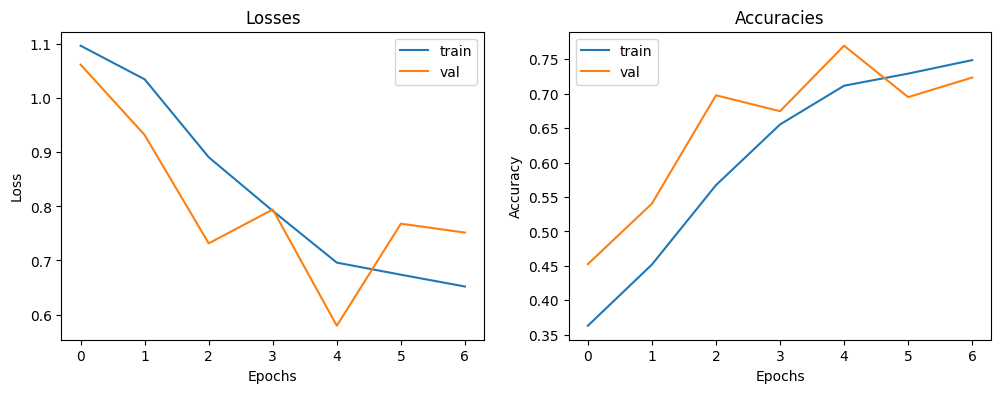

epoch = 7
Test correct = 458

Test total dataitem = 750

Test Accuracy = 0.6106666326522827

              precision    recall  f1-score   support

    negative       0.88      0.34      0.49       250
     neutral       0.51      0.90      0.65       250
    positive       0.70      0.60      0.65       250

    accuracy                           0.61       750
   macro avg       0.69      0.61      0.59       750
weighted avg       0.69      0.61      0.59       750



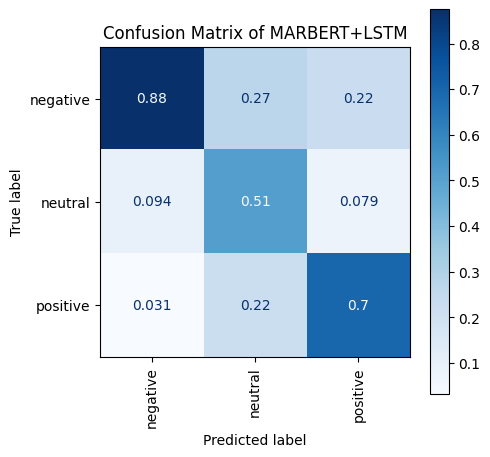

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


loss = 1.0930034902799302, val_loss =1.0400103290184952, accuracy = 0.3811764717102051, val_accuracy = 0.5288888812065125


Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


loss = 0.995758917589824, val_loss =0.8447254397326034, accuracy = 0.5033725500106812, val_accuracy = 0.5893333554267883


Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.8519992097485318, val_loss =0.7894478955786108, accuracy = 0.597019612789154, val_accuracy = 0.671999990940094


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.7748778671875204, val_loss =0.6315280110666154, accuracy = 0.6577255129814148, val_accuracy = 0.7431111335754395


Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.6896182100515305, val_loss =0.6286306622713089, accuracy = 0.7204706072807312, val_accuracy = 0.7226666808128357


Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.6627712260352868, val_loss =0.5860215346338091, accuracy = 0.7287843227386475, val_accuracy = 0.765333354473114


Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.6474861865364469, val_loss =0.624683500889605, accuracy = 0.7377254962921143, val_accuracy = 0.7288888692855835


Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.6334730737454888, val_loss =0.5747820597259139, accuracy = 0.7487059235572815, val_accuracy = 0.7608888745307922


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


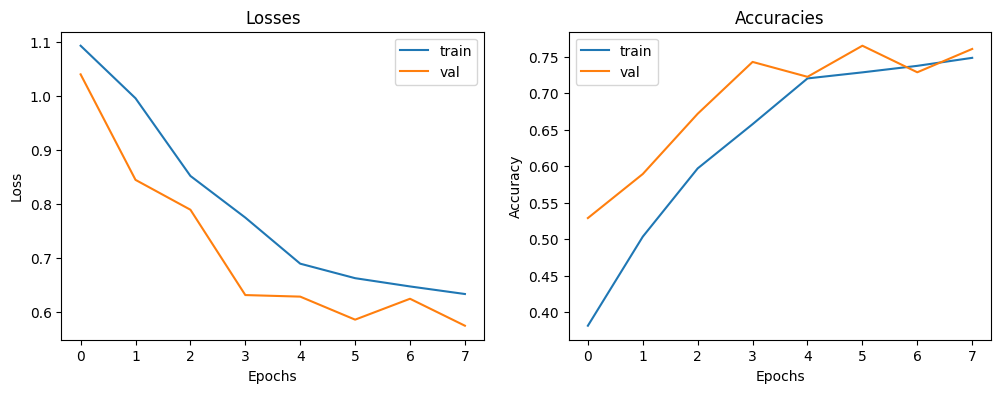

epoch = 8
Test correct = 503

Test total dataitem = 750

Test Accuracy = 0.6706666350364685

              precision    recall  f1-score   support

    negative       0.82      0.60      0.69       250
     neutral       0.56      0.84      0.68       250
    positive       0.74      0.56      0.64       250

    accuracy                           0.67       750
   macro avg       0.71      0.67      0.67       750
weighted avg       0.71      0.67      0.67       750



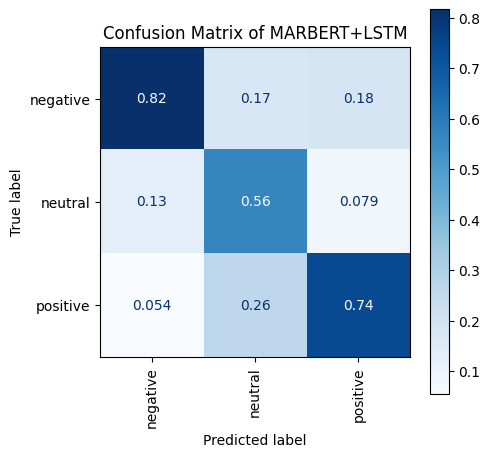

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.73it/s]


loss = 1.1051298257834516, val_loss =1.0644110455135773, accuracy = 0.3705098032951355, val_accuracy = 0.4391111135482788


Epoch 2: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 1.0226789424785723, val_loss =0.866386753165054, accuracy = 0.49349021911621094, val_accuracy = 0.5964444279670715


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.8853463601120091, val_loss =0.719556029129133, accuracy = 0.5788235664367676, val_accuracy = 0.674666702747345


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


loss = 0.7740157358838583, val_loss =0.6329958128621214, accuracy = 0.6671372652053833, val_accuracy = 0.7484444379806519


Epoch 5: 100%|██████████| 100/100 [00:20<00:00,  4.83it/s]


loss = 0.7165369773042076, val_loss =0.6004079203065429, accuracy = 0.7118431329727173, val_accuracy = 0.7573333382606506


Epoch 6: 100%|██████████| 100/100 [00:20<00:00,  4.86it/s]


loss = 0.6625421276754472, val_loss =0.6690517993668003, accuracy = 0.7328627705574036, val_accuracy = 0.7173333168029785


Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.6662670477127857, val_loss =0.5798162590280909, accuracy = 0.7400784492492676, val_accuracy = 0.7680000066757202


Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.6238742468894265, val_loss =0.646839728519756, accuracy = 0.7534117698669434, val_accuracy = 0.7573333382606506


Epoch 9: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


loss = 0.6111680769378496, val_loss =0.5906359984179977, accuracy = 0.7601568698883057, val_accuracy = 0.7671111226081848


Epoch 10: 100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


loss = 0.5981383048154263, val_loss =0.556224381630898, accuracy = 0.7680000066757202, val_accuracy = 0.7751111388206482


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


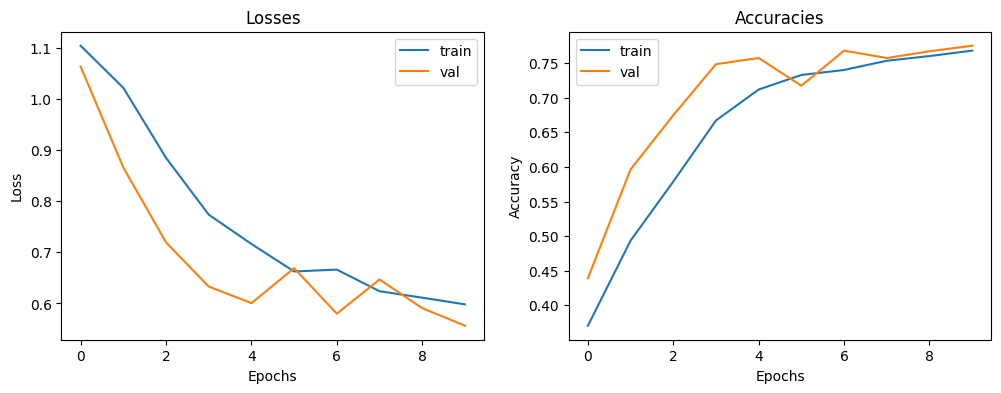

epoch = 10
Test correct = 529

Test total dataitem = 750

Test Accuracy = 0.7053333520889282

              precision    recall  f1-score   support

    negative       0.81      0.70      0.75       250
     neutral       0.72      0.62      0.67       250
    positive       0.62      0.80      0.70       250

    accuracy                           0.71       750
   macro avg       0.72      0.71      0.71       750
weighted avg       0.72      0.71      0.71       750



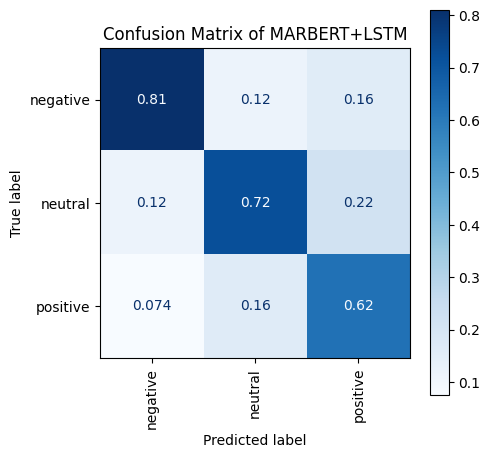

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 1.0904462992393962, val_loss =1.0381752871628571, accuracy = 0.37427452206611633, val_accuracy = 0.47733333706855774


Epoch 2: 100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


loss = 1.0133529998548925, val_loss =0.8521538909689688, accuracy = 0.47701960802078247, val_accuracy = 0.6248888969421387


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.8674754487276182, val_loss =0.6918488430847237, accuracy = 0.5921568870544434, val_accuracy = 0.7102222442626953


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.7436895398504604, val_loss =0.6289502600003062, accuracy = 0.6941176652908325, val_accuracy = 0.7377777695655823


Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


loss = 0.6916179945975073, val_loss =0.6031682238461871, accuracy = 0.7295686602592468, val_accuracy = 0.7591111063957214


Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  5.97it/s]


loss = 0.6459761550212123, val_loss =0.5741351794504963, accuracy = 0.7476078867912292, val_accuracy = 0.781333327293396


Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


loss = 0.6200224569299294, val_loss =0.6006514090192001, accuracy = 0.7620392441749573, val_accuracy = 0.7724444270133972


Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.6112659646244907, val_loss =0.5663356430640751, accuracy = 0.7643921971321106, val_accuracy = 0.7724444270133972


Epoch 9: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


loss = 0.5947429677522877, val_loss =0.623616249256272, accuracy = 0.7722353339195251, val_accuracy = 0.7644444704055786


Epoch 10: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


A model was saved at accuracy = 0.800000011920929
loss = 0.5892167505360747, val_loss =0.564156737318315, accuracy = 0.7579607963562012, val_accuracy = 0.800000011920929


Epoch 11: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


A model was saved at accuracy = 0.7964444756507874
loss = 0.5790354468510129, val_loss =0.5505646719528148, accuracy = 0.7778823971748352, val_accuracy = 0.7964444756507874


Epoch 12: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


A model was saved at accuracy = 0.7902222275733948
loss = 0.5656413270303094, val_loss =0.5600453211644761, accuracy = 0.7706666588783264, val_accuracy = 0.7902222275733948


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


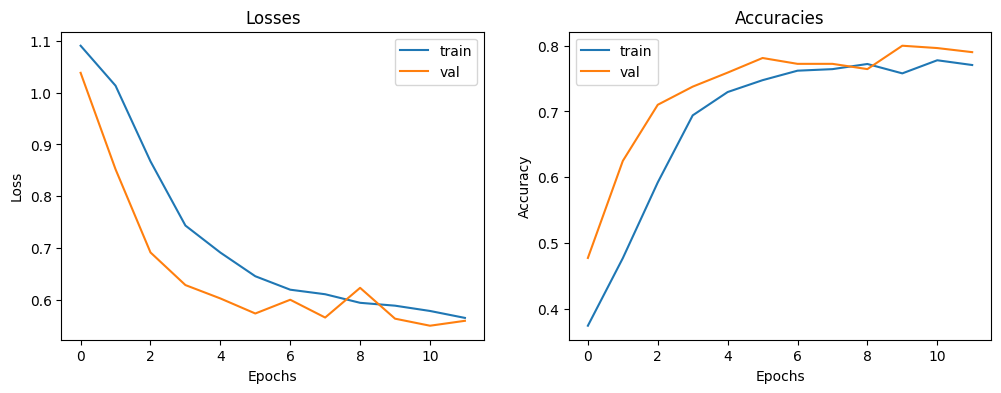

epoch = 12
Test correct = 522

Test total dataitem = 750

Test Accuracy = 0.6959999799728394

              precision    recall  f1-score   support

    negative       0.82      0.58      0.68       250
     neutral       0.61      0.79      0.69       250
    positive       0.72      0.72      0.72       250

    accuracy                           0.70       750
   macro avg       0.72      0.70      0.70       750
weighted avg       0.72      0.70      0.70       750



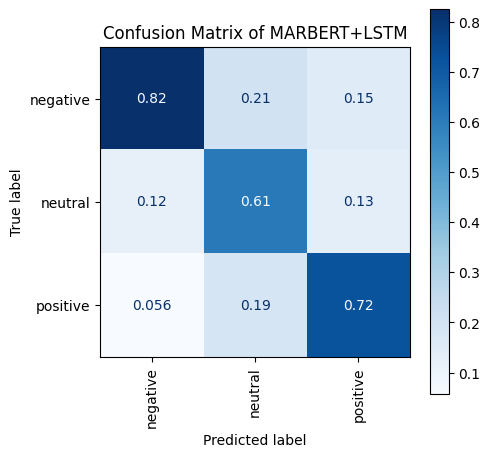

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:19<00:00,  5.00it/s]


loss = 1.095282968137509, val_loss =1.0633892370555718, accuracy = 0.37019607424736023, val_accuracy = 0.5057777762413025


Epoch 2: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 1.0358421387108496, val_loss =0.8902729743687497, accuracy = 0.46180394291877747, val_accuracy = 0.5786666870117188


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


loss = 0.8909247263407526, val_loss =0.7575165803048497, accuracy = 0.5722352862358093, val_accuracy = 0.6204444766044617


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.7884167616036538, val_loss =0.6780579738562239, accuracy = 0.6381176710128784, val_accuracy = 0.679111123085022


Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.7351197514785421, val_loss =0.5933781461007984, accuracy = 0.6839215755462646, val_accuracy = 0.7599999904632568


Epoch 6: 100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


loss = 0.6623796555370567, val_loss =0.5904259751244083, accuracy = 0.7360000014305115, val_accuracy = 0.7706666588783264


Epoch 7: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.6462983698048589, val_loss =0.5925018600267379, accuracy = 0.7474510073661804, val_accuracy = 0.753777801990509


Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


loss = 0.6458478102221521, val_loss =0.5616907935914064, accuracy = 0.7507451176643372, val_accuracy = 0.7777777910232544


Epoch 9: 100%|██████████| 100/100 [00:16<00:00,  5.88it/s]


loss = 0.6119768504377011, val_loss =0.5288331406821137, accuracy = 0.7683137655258179, val_accuracy = 0.7875555753707886


Epoch 10: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


A model was saved at accuracy = 0.7991111278533936
loss = 0.5867388123078634, val_loss =0.5361050295897796, accuracy = 0.7654902338981628, val_accuracy = 0.7991111278533936


Epoch 11: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


loss = 0.5915334069809808, val_loss =0.5620876538629124, accuracy = 0.7648627758026123, val_accuracy = 0.769777774810791


Epoch 12: 100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


loss = 0.5670694067084948, val_loss =0.5571303969313717, accuracy = 0.7788235545158386, val_accuracy = 0.7848889231681824


Epoch 13: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


A model was saved at accuracy = 0.8026666641235352
loss = 0.5737898703680717, val_loss =0.5143374567335115, accuracy = 0.7672157287597656, val_accuracy = 0.8026666641235352


Epoch 14: 100%|██████████| 100/100 [00:21<00:00,  4.71it/s]


A model was saved at accuracy = 0.7919999957084656
loss = 0.5536208836480158, val_loss =0.5181912712371061, accuracy = 0.7836862802505493, val_accuracy = 0.7919999957084656


Epoch 15: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


A model was saved at accuracy = 0.795555591583252
loss = 0.5589094005754781, val_loss =0.5269575068398865, accuracy = 0.7830588221549988, val_accuracy = 0.795555591583252


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


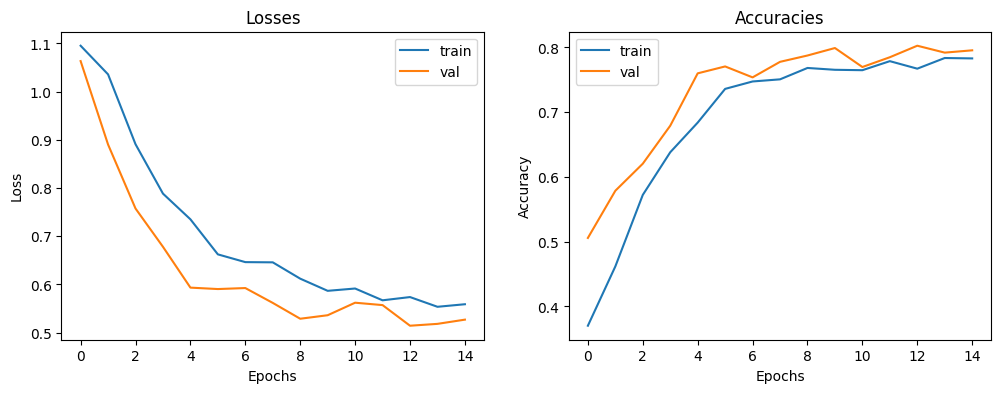

epoch = 15
Test correct = 516

Test total dataitem = 750

Test Accuracy = 0.687999963760376

              precision    recall  f1-score   support

    negative       0.84      0.56      0.67       250
     neutral       0.66      0.78      0.72       250
    positive       0.63      0.72      0.67       250

    accuracy                           0.69       750
   macro avg       0.71      0.69      0.69       750
weighted avg       0.71      0.69      0.69       750



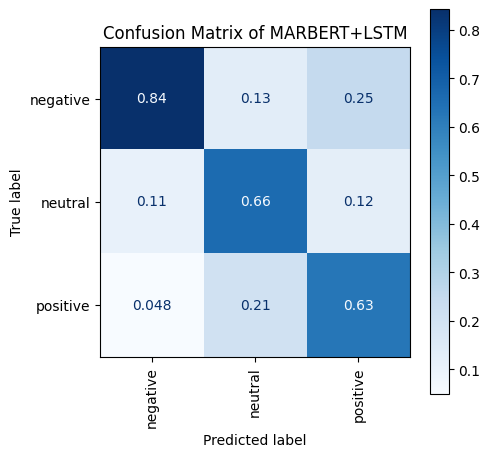

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:21<00:00,  4.74it/s]


loss = 1.1013167948876388, val_loss =1.0535973873319433, accuracy = 0.36533334851264954, val_accuracy = 0.46311110258102417


Epoch 2: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 1.0318196055137863, val_loss =0.9013359230144548, accuracy = 0.47654902935028076, val_accuracy = 0.5795555710792542


Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


loss = 0.893765726463708, val_loss =0.7349761961333526, accuracy = 0.5835294127464294, val_accuracy = 0.6711111068725586


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.7552515354537657, val_loss =0.7393913003771605, accuracy = 0.7014902234077454, val_accuracy = 0.6800000071525574


Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.76it/s]


loss = 0.7012636111198047, val_loss =0.5901528397132257, accuracy = 0.7220392227172852, val_accuracy = 0.7564444541931152


Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


loss = 0.6403221836888144, val_loss =0.5660815765651561, accuracy = 0.7598431706428528, val_accuracy = 0.7644444704055786


Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.6290257097848644, val_loss =0.5842168902561933, accuracy = 0.7618823647499084, val_accuracy = 0.7457777857780457


Epoch 8: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


loss = 0.6127185993460416, val_loss =0.6259320876359213, accuracy = 0.7620392441749573, val_accuracy = 0.7377777695655823


Epoch 9: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


loss = 0.5858129795901196, val_loss =0.5995560849995535, accuracy = 0.776941180229187, val_accuracy = 0.7599999904632568


Epoch 10: 100%|██████████| 100/100 [00:16<00:00,  5.88it/s]


A model was saved at accuracy = 0.7919999957084656
loss = 0.5795174521535902, val_loss =0.5376268884109129, accuracy = 0.7720784544944763, val_accuracy = 0.7919999957084656


Epoch 11: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]


A model was saved at accuracy = 0.7991111278533936
loss = 0.5784930151319027, val_loss =0.547054170079276, accuracy = 0.7749019861221313, val_accuracy = 0.7991111278533936


Epoch 12: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


loss = 0.5727512265387462, val_loss =0.5746329116857062, accuracy = 0.7789804339408875, val_accuracy = 0.788444459438324


Epoch 13: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.5587958997329068, val_loss =0.6501028202464723, accuracy = 0.7872941493988037, val_accuracy = 0.7564444541931152


Epoch 14: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


loss = 0.5536108726777289, val_loss =0.5828013953722402, accuracy = 0.7802352905273438, val_accuracy = 0.7848889231681824


Epoch 15: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


loss = 0.5376610275464003, val_loss =0.6044193318340004, accuracy = 0.7927843332290649, val_accuracy = 0.7866666913032532


Epoch 16: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


A model was saved at accuracy = 0.7982222437858582
loss = 0.5387797799654637, val_loss =0.5380404234729704, accuracy = 0.7930980324745178, val_accuracy = 0.7982222437858582


Epoch 17: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


loss = 0.5249917973414661, val_loss =0.7260220666570052, accuracy = 0.7951372861862183, val_accuracy = 0.7262222170829773


Epoch 18: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


loss = 0.5196586652273634, val_loss =0.6355597733538172, accuracy = 0.7929412126541138, val_accuracy = 0.7742222547531128


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


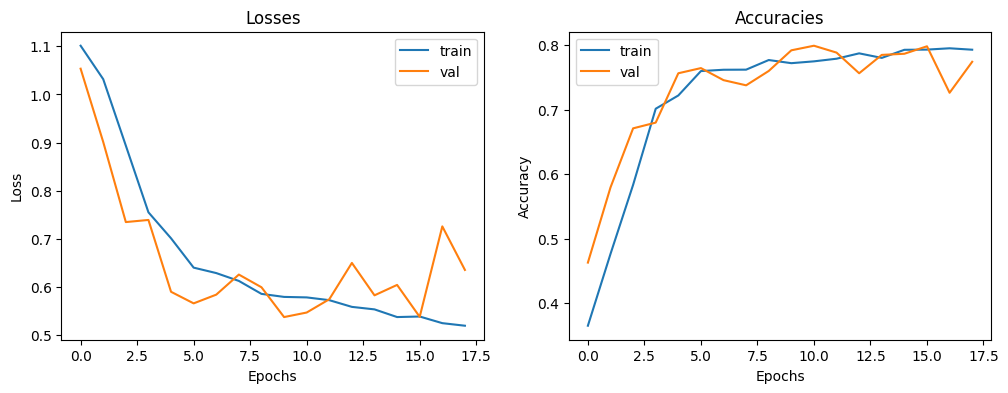

epoch = 18
Test correct = 484

Test total dataitem = 750

Test Accuracy = 0.6453333497047424

              precision    recall  f1-score   support

    negative       0.84      0.48      0.61       250
     neutral       0.75      0.59      0.66       250
    positive       0.53      0.86      0.66       250

    accuracy                           0.65       750
   macro avg       0.70      0.65      0.64       750
weighted avg       0.70      0.65      0.64       750



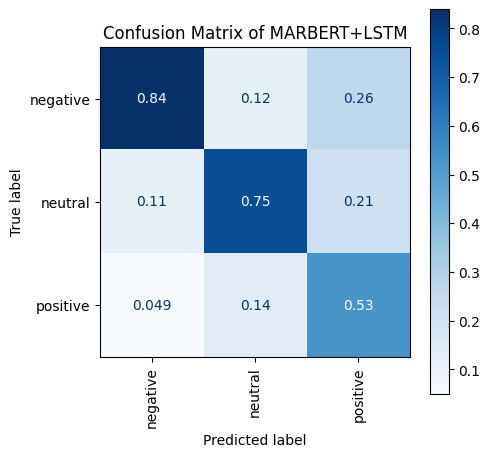

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.52it/s]


loss = 1.0897001298774893, val_loss =1.0256445043826583, accuracy = 0.38603922724723816, val_accuracy = 0.4444444477558136


Epoch 2: 100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


loss = 0.993582010938165, val_loss =0.8424027343455411, accuracy = 0.49929413199424744, val_accuracy = 0.5991111397743225


Epoch 3: 100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


loss = 0.8777343831363563, val_loss =0.9177955423772626, accuracy = 0.5802353024482727, val_accuracy = 0.5440000295639038


Epoch 4: 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


loss = 0.7878207417645975, val_loss =0.686905596837193, accuracy = 0.6298039555549622, val_accuracy = 0.6880000233650208


Epoch 5: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.7164745816579857, val_loss =0.8453652730292721, accuracy = 0.6892549395561218, val_accuracy = 0.648888885974884


Epoch 6: 100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


loss = 0.6649003988416361, val_loss =0.5869966772845184, accuracy = 0.7358431816101074, val_accuracy = 0.753777801990509


Epoch 7: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.6398403439572072, val_loss =0.5786997328114531, accuracy = 0.7440000176429749, val_accuracy = 0.7688888907432556


Epoch 8: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.6162184632608536, val_loss =0.7038824940581443, accuracy = 0.7620392441749573, val_accuracy = 0.7333333492279053


Epoch 9: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


loss = 0.6013042260904562, val_loss =0.7294075929886377, accuracy = 0.7598431706428528, val_accuracy = 0.7155555486679077


Epoch 10: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.5872538861097854, val_loss =0.5871844503806959, accuracy = 0.7692549228668213, val_accuracy = 0.7715555429458618


Epoch 11: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


loss = 0.5633124432457933, val_loss =0.5371419618046007, accuracy = 0.779764711856842, val_accuracy = 0.7804444432258606


Epoch 12: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


loss = 0.5680708716519018, val_loss =0.6487676091108932, accuracy = 0.7794510126113892, val_accuracy = 0.765333354473114


Epoch 13: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


loss = 0.5539608308076612, val_loss =0.6562331475074684, accuracy = 0.7802352905273438, val_accuracy = 0.769777774810791


Epoch 14: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


loss = 0.5454860623307654, val_loss =0.6244147308896861, accuracy = 0.784156858921051, val_accuracy = 0.7084444761276245


Epoch 15: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


loss = 0.5531344625195609, val_loss =0.5863965539516117, accuracy = 0.7824313640594482, val_accuracy = 0.7839999794960022


Epoch 16: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


loss = 0.531014782802567, val_loss =0.6021421706003324, accuracy = 0.7890196442604065, val_accuracy = 0.7751111388206482


Epoch 17: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


loss = 0.519219196599705, val_loss =0.5421454142011859, accuracy = 0.7996863126754761, val_accuracy = 0.7848889231681824


Epoch 18: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


loss = 0.507223260124786, val_loss =0.5419089096990224, accuracy = 0.7978039383888245, val_accuracy = 0.7875555753707886


Epoch 19: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


loss = 0.5144327398772327, val_loss =0.5985209013264023, accuracy = 0.8001568913459778, val_accuracy = 0.7804444432258606


Epoch 20: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


loss = 0.514589148517438, val_loss =0.5094104382333499, accuracy = 0.79560786485672, val_accuracy = 0.788444459438324


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


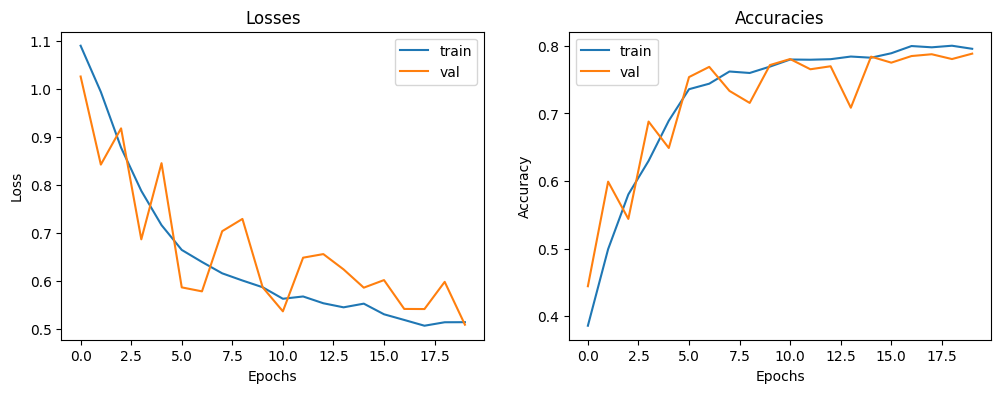

epoch = 20
Test correct = 512

Test total dataitem = 750

Test Accuracy = 0.6826666593551636

              precision    recall  f1-score   support

    negative       0.82      0.53      0.64       250
     neutral       0.61      0.81      0.70       250
    positive       0.69      0.71      0.70       250

    accuracy                           0.68       750
   macro avg       0.71      0.68      0.68       750
weighted avg       0.71      0.68      0.68       750



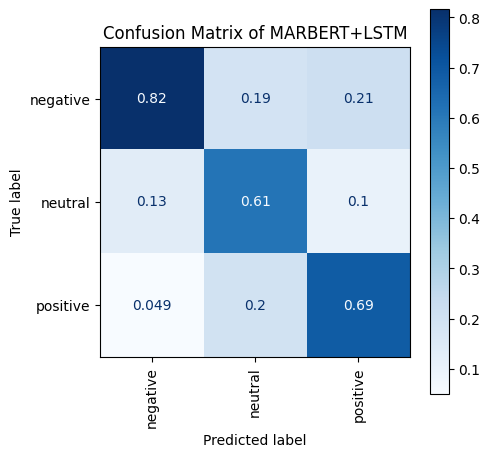

In [ ]:
bidirectional=False
num_layers=1
hidden_size1=128
hidden_size2=32
learning_rate=0.0002
droprate=0.6
num_epochs=[2,4,5,6,7,8,10,12,15,18,20]
for epoch in num_epochs:
  model=RNN_AraBERT(hidden_size1,hidden_size2,num_layers,bidirectional,droprate).to(device,non_blocking=True)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,train_loader,val_loader)
  print(f'epoch = {epoch}')
  model_name='MARBERT+LSTM'
  test_and_report(model,test_loader,model_name)

## Tuning on Test set

Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:20<00:00,  5.64it/s]


loss = 1.0900420848146017, val_loss =1.0485216009066156, accuracy = 0.37586668133735657, val_accuracy = 0.47599998116493225


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:20<00:00,  5.76it/s]


loss = 0.9647330533044537, val_loss =1.013667006014367, accuracy = 0.5170666575431824, val_accuracy = 0.5239999890327454


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:21<00:00,  5.39it/s]


loss = 0.7986408909567982, val_loss =1.085149134822237, accuracy = 0.6253333687782288, val_accuracy = 0.5333333015441895


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:21<00:00,  5.54it/s]


loss = 0.7242689308404806, val_loss =0.9322034809034001, accuracy = 0.6918666958808899, val_accuracy = 0.5839999914169312


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:19<00:00,  5.96it/s]


loss = 0.6693685447116479, val_loss =1.180435042907408, accuracy = 0.7225333452224731, val_accuracy = 0.5320000052452087


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:19<00:00,  6.00it/s]


loss = 0.6291112146096812, val_loss =1.0513932624316362, accuracy = 0.7509333491325378, val_accuracy = 0.5239999890327454


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:19<00:00,  6.04it/s]


loss = 0.6155640997732819, val_loss =0.9495746449089063, accuracy = 0.7516000270843506, val_accuracy = 0.6146666407585144


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:20<00:00,  5.63it/s]


loss = 0.6028629781028575, val_loss =0.8947718076101476, accuracy = 0.7595999836921692, val_accuracy = 0.6319999694824219


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:20<00:00,  5.84it/s]


loss = 0.5992882699766637, val_loss =1.0072382819425252, accuracy = 0.7601333260536194, val_accuracy = 0.590666651725769


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:20<00:00,  5.77it/s]


loss = 0.5859512622480504, val_loss =1.0819335533445196, accuracy = 0.7646666765213013, val_accuracy = 0.5493333339691162


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


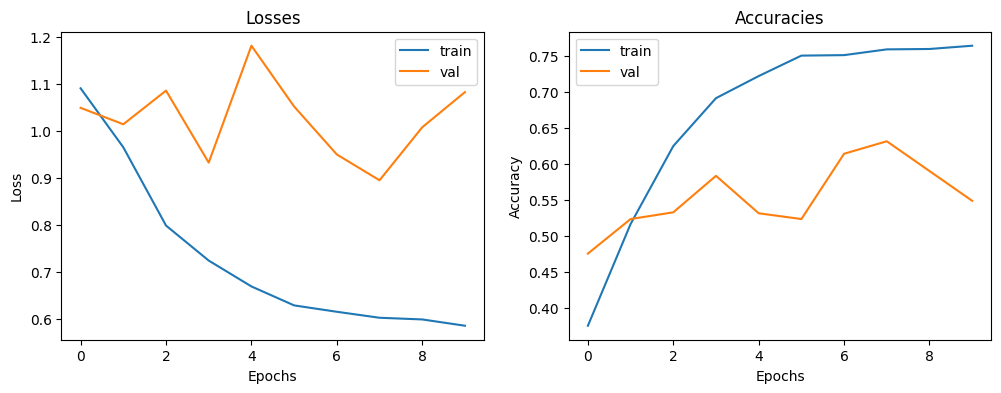

In [ ]:
bidirectional=False
num_layers=1
hidden_size1=128
hidden_size2=32
learning_rate=0.0002
droprate=0.6
epoch=10
model=RNN_AraBERT(hidden_size1,hidden_size2,num_layers,bidirectional,droprate).to(device,non_blocking=True)
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
train(model,epoch,optimizer,criterion,full_dataloader,test_loader)

Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:24<00:00,  4.85it/s]


loss = 1.071041145435624, val_loss =1.0024680463543187, accuracy = 0.4196000099182129, val_accuracy = 0.5360000133514404


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:23<00:00,  5.06it/s]


loss = 0.9113083549965592, val_loss =0.9222590167449106, accuracy = 0.547866702079773, val_accuracy = 0.590666651725769


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:19<00:00,  6.00it/s]


loss = 0.8012757814626768, val_loss =0.878632099628769, accuracy = 0.6073333621025085, val_accuracy = 0.656000018119812


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:20<00:00,  5.82it/s]


loss = 0.7210998973739157, val_loss =0.9843432490127179, accuracy = 0.6845333576202393, val_accuracy = 0.6413333415985107


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:22<00:00,  5.26it/s]


loss = 0.6920932367933947, val_loss =0.7474705101584719, accuracy = 0.7039999961853027, val_accuracy = 0.7239999771118164


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:19<00:00,  6.02it/s]


loss = 0.6244668791819403, val_loss =0.9333462036751291, accuracy = 0.7518666982650757, val_accuracy = 0.671999990940094


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:19<00:00,  5.92it/s]


loss = 0.6203023600891187, val_loss =0.8738112573739034, accuracy = 0.7585333585739136, val_accuracy = 0.6813333034515381


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:19<00:00,  6.01it/s]


loss = 0.5977719228544885, val_loss =0.9565608247099537, accuracy = 0.7626667022705078, val_accuracy = 0.6186666488647461


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:19<00:00,  5.93it/s]


loss = 0.597719147266353, val_loss =1.0271602392842423, accuracy = 0.7613333463668823, val_accuracy = 0.6399999856948853


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:19<00:00,  5.90it/s]


loss = 0.5784520618044585, val_loss =0.9666994478027028, accuracy = 0.772266685962677, val_accuracy = 0.6480000019073486


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


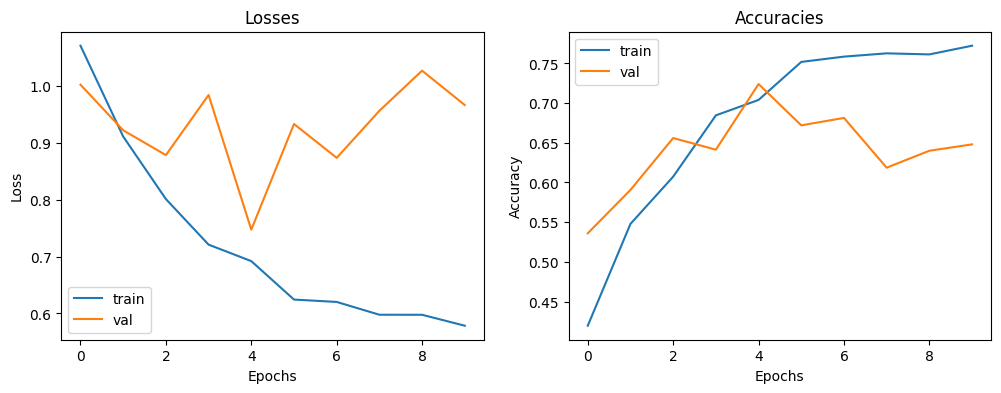

Bidirectional = True
Test correct = 486

Test total dataitem = 750

Test Accuracy = 0.6480000019073486

              precision    recall  f1-score   support

    negative       0.82      0.60      0.69       250
     neutral       0.56      0.84      0.67       250
    positive       0.65      0.51      0.57       250

    accuracy                           0.65       750
   macro avg       0.68      0.65      0.65       750
weighted avg       0.68      0.65      0.65       750



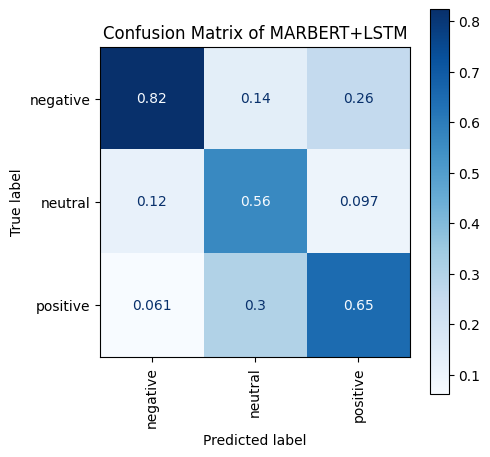

Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:20<00:00,  5.63it/s]


loss = 1.0801392191479056, val_loss =0.999010187904418, accuracy = 0.40799999237060547, val_accuracy = 0.4959999918937683


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:19<00:00,  6.07it/s]


loss = 0.9369790487874057, val_loss =0.873110287463414, accuracy = 0.5538666844367981, val_accuracy = 0.581333339214325


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:19<00:00,  6.02it/s]


loss = 0.8483649356886587, val_loss =0.9058212886675787, accuracy = 0.6252000331878662, val_accuracy = 0.5960000157356262


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:20<00:00,  5.65it/s]


loss = 0.7561994069306861, val_loss =0.8120136106736027, accuracy = 0.6905333399772644, val_accuracy = 0.6933333277702332


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:19<00:00,  5.96it/s]


loss = 0.6879625524754148, val_loss =0.7594183296841684, accuracy = 0.7338666915893555, val_accuracy = 0.7146666646003723


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:19<00:00,  6.01it/s]


loss = 0.6551405528852522, val_loss =0.7386525643412006, accuracy = 0.7495999932289124, val_accuracy = 0.7253333330154419


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:20<00:00,  5.86it/s]


loss = 0.631481366889818, val_loss =1.081244387585447, accuracy = 0.753600001335144, val_accuracy = 0.6413333415985107


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:20<00:00,  5.65it/s]


loss = 0.6298740306377878, val_loss =1.0430485317546814, accuracy = 0.7554666996002197, val_accuracy = 0.6053333282470703


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:19<00:00,  6.12it/s]


loss = 0.5901252744656579, val_loss =1.1259100244876563, accuracy = 0.7793333530426025, val_accuracy = 0.656000018119812


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:19<00:00,  6.08it/s]


loss = 0.5949448972971848, val_loss =1.0259585138588538, accuracy = 0.7754666805267334, val_accuracy = 0.6426666378974915


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


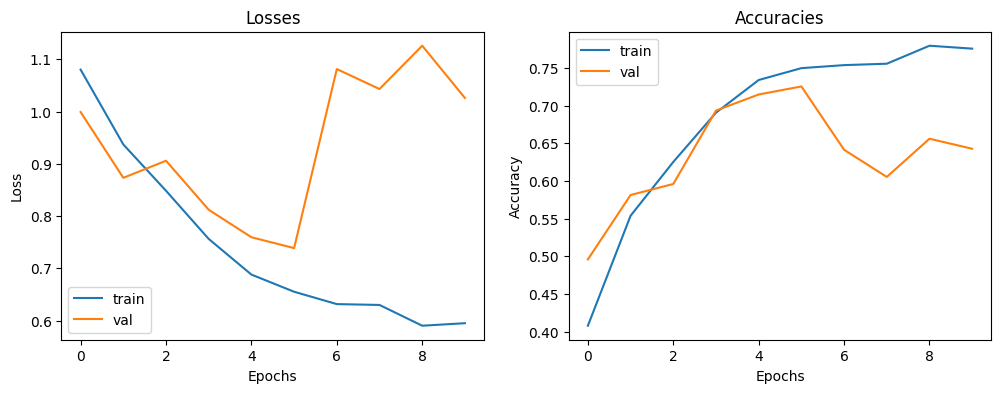

Bidirectional = False
Test correct = 482

Test total dataitem = 750

Test Accuracy = 0.6426666378974915

              precision    recall  f1-score   support

    negative       0.83      0.44      0.58       250
     neutral       0.53      0.82      0.65       250
    positive       0.72      0.66      0.69       250

    accuracy                           0.64       750
   macro avg       0.69      0.64      0.64       750
weighted avg       0.69      0.64      0.64       750



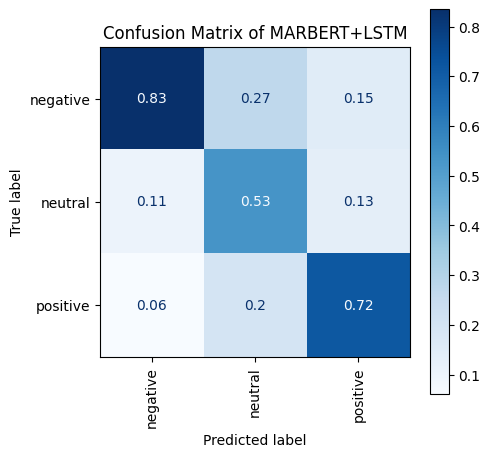

In [ ]:
bidirectional_options=[True,False]
for bidirectional1 in bidirectional_options:
  model=RNN_AraBERT(hidden_size1,hidden_size2,num_layers,bidirectional1,droprate).to(device,non_blocking=True)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,full_dataloader,test_loader)
  print(f'Bidirectional = {bidirectional1}')
  model_name='MARBERT+LSTM'
  test_and_report(model,test_loader,model_name)

Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:23<00:00,  5.12it/s]


loss = 1.088238862403642, val_loss =1.0345874295934387, accuracy = 0.38466668128967285, val_accuracy = 0.47599998116493225


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:21<00:00,  5.54it/s]


loss = 0.9733619658864435, val_loss =0.8719827987918415, accuracy = 0.5141333341598511, val_accuracy = 0.5986666679382324


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:19<00:00,  6.19it/s]


loss = 0.8459376172038202, val_loss =0.8423992966198822, accuracy = 0.6255999803543091, val_accuracy = 0.5960000157356262


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:19<00:00,  6.04it/s]


loss = 0.724961279132142, val_loss =0.8132537655729338, accuracy = 0.7030666470527649, val_accuracy = 0.6773333549499512


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:20<00:00,  5.90it/s]


loss = 0.6630799197604481, val_loss =0.7332032766377475, accuracy = 0.7393333315849304, val_accuracy = 0.699999988079071


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:21<00:00,  5.59it/s]


loss = 0.650877705169975, val_loss =0.754147733029917, accuracy = 0.7426666617393494, val_accuracy = 0.7026666402816772


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:21<00:00,  5.45it/s]


loss = 0.6246443601741605, val_loss =0.7204140343997426, accuracy = 0.7574666738510132, val_accuracy = 0.7319999933242798


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:20<00:00,  5.69it/s]


loss = 0.5979324737067157, val_loss =0.7776081763144432, accuracy = 0.7609333395957947, val_accuracy = 0.7173333168029785


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:21<00:00,  5.47it/s]


loss = 0.5912273582528669, val_loss =0.6878656083452211, accuracy = 0.7652000188827515, val_accuracy = 0.7386666536331177


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:19<00:00,  5.96it/s]


loss = 0.5811929945139307, val_loss =0.8388040979532861, accuracy = 0.7689333558082581, val_accuracy = 0.7413333058357239


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


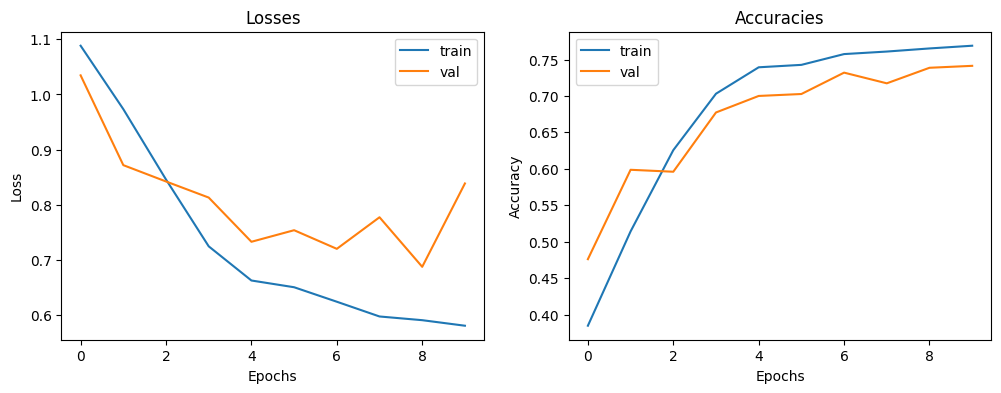

RNN Layers = 1
Test correct = 556

Test total dataitem = 750

Test Accuracy = 0.7413333058357239

              precision    recall  f1-score   support

    negative       0.67      0.92      0.77       250
     neutral       0.79      0.58      0.67       250
    positive       0.81      0.72      0.76       250

    accuracy                           0.74       750
   macro avg       0.76      0.74      0.74       750
weighted avg       0.76      0.74      0.74       750



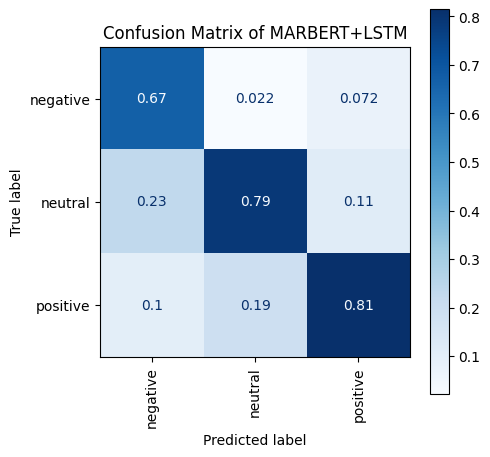

Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:20<00:00,  5.62it/s]


loss = 1.063767442021961, val_loss =0.9572141890488295, accuracy = 0.4174666702747345, val_accuracy = 0.518666684627533


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:21<00:00,  5.50it/s]


loss = 0.86789110467371, val_loss =0.8092253846339915, accuracy = 0.6005333662033081, val_accuracy = 0.6666666865348816


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:20<00:00,  5.63it/s]


loss = 0.7312104992771428, val_loss =0.7945024329847133, accuracy = 0.7008000016212463, val_accuracy = 0.656000018119812


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:20<00:00,  5.85it/s]


loss = 0.6777113252859235, val_loss =0.6838441755968708, accuracy = 0.73253333568573, val_accuracy = 0.7266666293144226


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:20<00:00,  5.83it/s]


loss = 0.6487842832674852, val_loss =0.9327538808794232, accuracy = 0.7400000095367432, val_accuracy = 0.5986666679382324


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:20<00:00,  5.80it/s]


loss = 0.6165356249424162, val_loss =0.682032585698492, accuracy = 0.7559999823570251, val_accuracy = 0.7293333411216736


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:20<00:00,  5.82it/s]


loss = 0.6170661566190387, val_loss =0.7328835407232331, accuracy = 0.7573333382606506, val_accuracy = 0.718666672706604


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:20<00:00,  5.84it/s]


loss = 0.5956858130114724, val_loss =0.6776217840245184, accuracy = 0.7673333287239075, val_accuracy = 0.7253333330154419


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:21<00:00,  5.43it/s]


loss = 0.5773150424488097, val_loss =0.6589347542699808, accuracy = 0.7801333665847778, val_accuracy = 0.7226666808128357


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:20<00:00,  5.89it/s]


loss = 0.5781724636325328, val_loss =0.7259094683767467, accuracy = 0.7675999999046326, val_accuracy = 0.7373332977294922


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


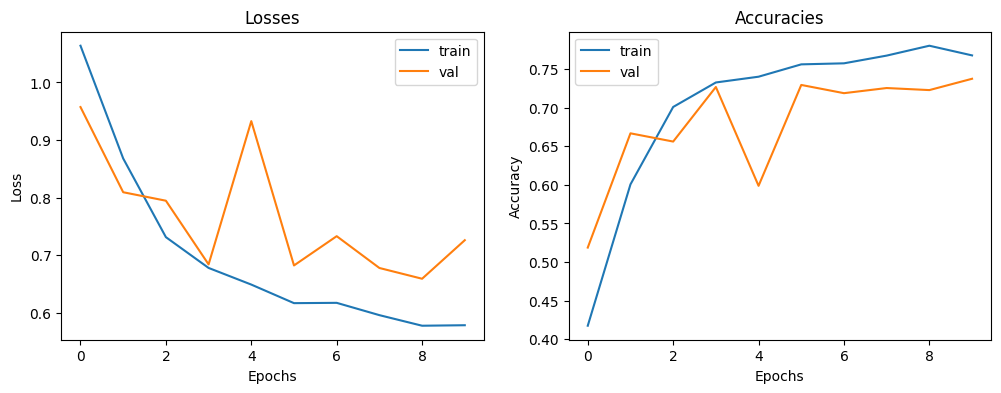

RNN Layers = 2
Test correct = 553

Test total dataitem = 750

Test Accuracy = 0.7373332977294922

              precision    recall  f1-score   support

    negative       0.78      0.78      0.78       250
     neutral       0.73      0.66      0.70       250
    positive       0.70      0.76      0.73       250

    accuracy                           0.74       750
   macro avg       0.74      0.74      0.74       750
weighted avg       0.74      0.74      0.74       750



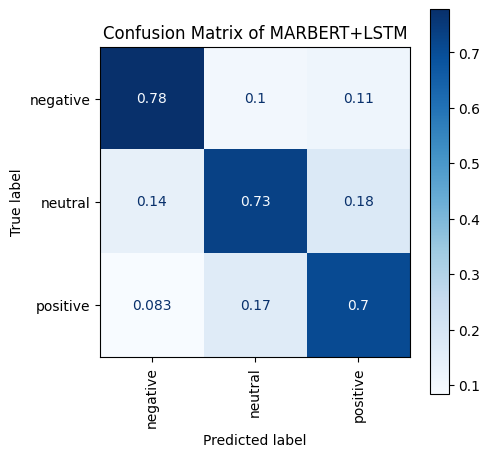

Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:21<00:00,  5.43it/s]


loss = 1.0155124638536597, val_loss =1.0112753591754986, accuracy = 0.45186668634414673, val_accuracy = 0.46533334255218506


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:22<00:00,  5.33it/s]


loss = 0.8304337651143266, val_loss =0.8861787290977942, accuracy = 0.574400007724762, val_accuracy = 0.5


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:20<00:00,  5.76it/s]


loss = 0.7684357424128075, val_loss =0.8170659256216638, accuracy = 0.5888000130653381, val_accuracy = 0.5933333039283752


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:21<00:00,  5.53it/s]


loss = 0.7415344915898279, val_loss =0.9260875488559933, accuracy = 0.6013333201408386, val_accuracy = 0.5146666765213013


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:21<00:00,  5.52it/s]


loss = 0.7307755578996746, val_loss =0.8417847873839176, accuracy = 0.6101333498954773, val_accuracy = 0.637333333492279


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:20<00:00,  5.68it/s]


loss = 0.6951989757482703, val_loss =0.8836758451474505, accuracy = 0.6818666458129883, val_accuracy = 0.6480000019073486


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:21<00:00,  5.58it/s]


loss = 0.6429253130707132, val_loss =0.7059691737949438, accuracy = 0.734000027179718, val_accuracy = 0.7293333411216736


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:20<00:00,  5.66it/s]


loss = 0.6029683837256737, val_loss =0.7487861696197639, accuracy = 0.7531999945640564, val_accuracy = 0.7066666483879089


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:20<00:00,  5.72it/s]


loss = 0.5816633280520797, val_loss =0.7531712845887776, accuracy = 0.7658666968345642, val_accuracy = 0.7053333520889282


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:20<00:00,  5.73it/s]


loss = 0.590091442986806, val_loss =0.7618621944457645, accuracy = 0.7703999876976013, val_accuracy = 0.699999988079071


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


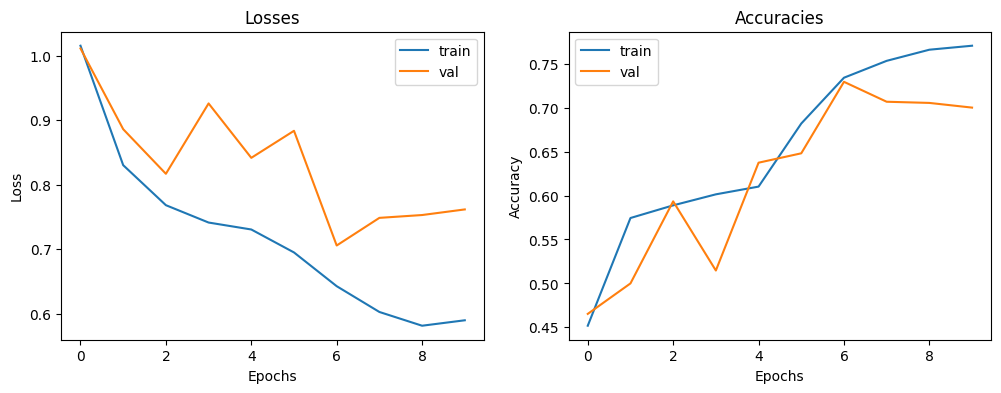

RNN Layers = 3
Test correct = 525

Test total dataitem = 750

Test Accuracy = 0.699999988079071

              precision    recall  f1-score   support

    negative       0.82      0.68      0.74       250
     neutral       0.65      0.66      0.66       250
    positive       0.65      0.76      0.70       250

    accuracy                           0.70       750
   macro avg       0.71      0.70      0.70       750
weighted avg       0.71      0.70      0.70       750



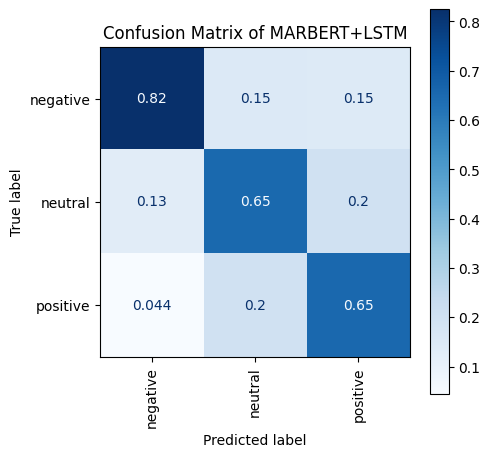

Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:22<00:00,  5.21it/s]


loss = 1.0197735323414792, val_loss =0.9202441285749007, accuracy = 0.4399999976158142, val_accuracy = 0.527999997138977


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:21<00:00,  5.62it/s]


loss = 0.8511299777833943, val_loss =1.3580169417200258, accuracy = 0.567466676235199, val_accuracy = 0.3813333213329315


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:20<00:00,  5.63it/s]


loss = 0.7894981293173119, val_loss =0.9026729676875022, accuracy = 0.605733335018158, val_accuracy = 0.5400000214576721


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:21<00:00,  5.56it/s]


loss = 0.7588014409122603, val_loss =0.919509666512528, accuracy = 0.6165333390235901, val_accuracy = 0.5266666412353516


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:22<00:00,  5.32it/s]


loss = 0.7316682280214987, val_loss =0.9612623670621795, accuracy = 0.6333333253860474, val_accuracy = 0.5586666464805603


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:22<00:00,  5.20it/s]


loss = 0.7086187878158087, val_loss =1.0526418410882943, accuracy = 0.6772000193595886, val_accuracy = 0.5893333554267883


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:21<00:00,  5.57it/s]


loss = 0.6846095260806379, val_loss =0.9112178796974636, accuracy = 0.6899999976158142, val_accuracy = 0.6493332982063293


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:21<00:00,  5.51it/s]


loss = 0.6479389813893996, val_loss =0.7298527935269795, accuracy = 0.7342666983604431, val_accuracy = 0.7213333249092102


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:21<00:00,  5.54it/s]


loss = 0.6167055527602153, val_loss =0.8066478187605938, accuracy = 0.7546666860580444, val_accuracy = 0.6946666836738586


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:21<00:00,  5.49it/s]


loss = 0.6079718726893732, val_loss =0.9589475247919546, accuracy = 0.7639999985694885, val_accuracy = 0.6413333415985107


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


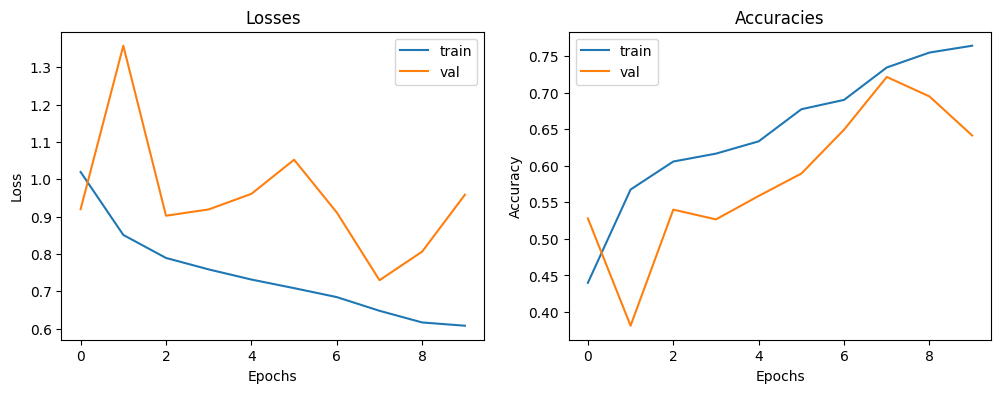

RNN Layers = 4
Test correct = 481

Test total dataitem = 750

Test Accuracy = 0.6413333415985107

              precision    recall  f1-score   support

    negative       0.87      0.44      0.58       250
     neutral       0.60      0.79      0.68       250
    positive       0.59      0.70      0.64       250

    accuracy                           0.64       750
   macro avg       0.69      0.64      0.63       750
weighted avg       0.69      0.64      0.63       750



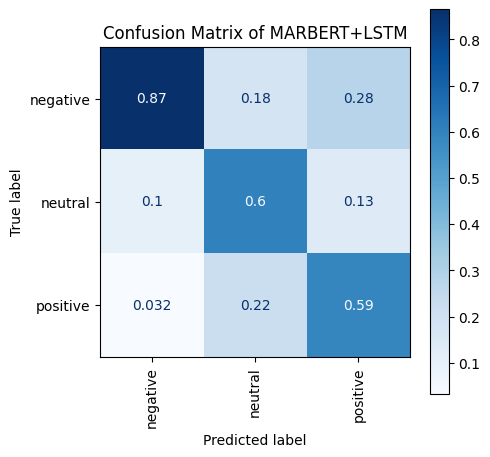

In [ ]:
bidirectional=True
rnn_layers=[1,2,3,4]
for num_layers1 in rnn_layers:
  model=RNN_AraBERT(hidden_size1,hidden_size2,num_layers1,bidirectional,droprate).to(device,non_blocking=True)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,full_dataloader,test_loader)
  print(f'RNN Layers = {num_layers1}')
  model_name='MARBERT+LSTM'
  test_and_report(model,test_loader,model_name)

Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:19<00:00,  5.94it/s]


loss = 1.0984489971832345, val_loss =1.061738173470603, accuracy = 0.38013333082199097, val_accuracy = 0.4893333315849304


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:19<00:00,  5.91it/s]


loss = 1.0393451427761993, val_loss =0.9760648712576568, accuracy = 0.4684000015258789, val_accuracy = 0.5373333096504211


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:19<00:00,  6.12it/s]


loss = 0.9584200119716115, val_loss =0.9151030344267687, accuracy = 0.5369333624839783, val_accuracy = 0.5586666464805603


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:19<00:00,  6.17it/s]


loss = 0.891012893030078, val_loss =0.8614346558654992, accuracy = 0.572533369064331, val_accuracy = 0.6573333144187927


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:19<00:00,  6.10it/s]


loss = 0.8429070153827931, val_loss =0.8541538479967393, accuracy = 0.6032000184059143, val_accuracy = 0.6586666703224182


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:19<00:00,  6.06it/s]


loss = 0.7871248072806954, val_loss =0.8285017099802592, accuracy = 0.644266664981842, val_accuracy = 0.7039999961853027


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:19<00:00,  6.02it/s]


loss = 0.7410889579569108, val_loss =0.8085110288512373, accuracy = 0.6861333250999451, val_accuracy = 0.7013333439826965


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:19<00:00,  6.07it/s]


loss = 0.7009833294690866, val_loss =0.771271414457115, accuracy = 0.7221333384513855, val_accuracy = 0.7066666483879089


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:19<00:00,  6.12it/s]


loss = 0.6810353194029224, val_loss =0.6912587014897102, accuracy = 0.7349333167076111, val_accuracy = 0.7386666536331177


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:19<00:00,  6.09it/s]


loss = 0.6550845204851714, val_loss =0.7616423998504457, accuracy = 0.7468000054359436, val_accuracy = 0.7160000205039978


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


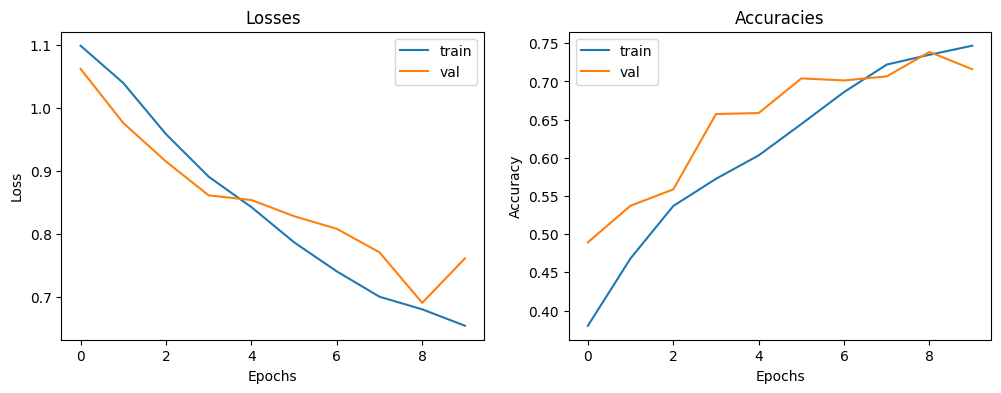

RNN hidden size = 32


Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:20<00:00,  5.80it/s]


loss = 1.1017332959230883, val_loss =1.0805983611389294, accuracy = 0.353466659784317, val_accuracy = 0.4266666769981384


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:20<00:00,  5.69it/s]


loss = 1.0559845748607406, val_loss =1.0101810095501065, accuracy = 0.4368000030517578, val_accuracy = 0.4906666576862335


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:19<00:00,  6.08it/s]


loss = 0.9496977074893249, val_loss =0.9541092255402465, accuracy = 0.5566666722297668, val_accuracy = 0.5586666464805603


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:19<00:00,  6.07it/s]


loss = 0.8451760095637226, val_loss =0.974519557881412, accuracy = 0.6306666731834412, val_accuracy = 0.5999999642372131


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:19<00:00,  6.01it/s]


loss = 0.7633370454632366, val_loss =0.8068646791212234, accuracy = 0.7006666660308838, val_accuracy = 0.6840000152587891


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:19<00:00,  6.05it/s]


loss = 0.7104036759789218, val_loss =0.7641695926541233, accuracy = 0.7310667037963867, val_accuracy = 0.7026666402816772


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:19<00:00,  6.04it/s]


loss = 0.6649459239237392, val_loss =0.9529207860456234, accuracy = 0.7470666766166687, val_accuracy = 0.6039999723434448


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:19<00:00,  6.07it/s]


loss = 0.6424726624177234, val_loss =0.7460681445309487, accuracy = 0.7542666792869568, val_accuracy = 0.6973333358764648


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:19<00:00,  6.04it/s]


loss = 0.6265132802781394, val_loss =0.7521556061076716, accuracy = 0.7633333206176758, val_accuracy = 0.6800000071525574


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:19<00:00,  6.02it/s]


loss = 0.6080022436635362, val_loss =0.7097785791797239, accuracy = 0.7677333354949951, val_accuracy = 0.7106666564941406


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


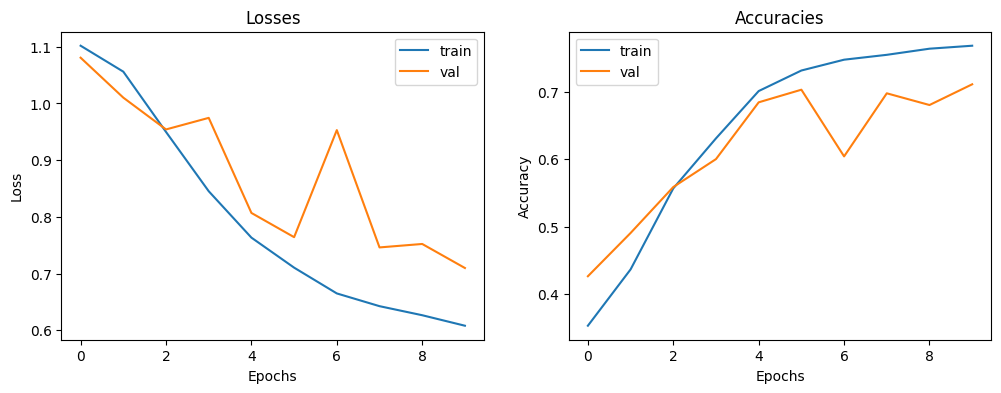

RNN hidden size = 64


Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:20<00:00,  5.81it/s]


loss = 1.0818245393424004, val_loss =1.0258369147743813, accuracy = 0.4025333523750305, val_accuracy = 0.46533334255218506


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:20<00:00,  5.73it/s]


loss = 0.9432381506222314, val_loss =0.8742499995548143, accuracy = 0.5595999956130981, val_accuracy = 0.5640000104904175


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:21<00:00,  5.59it/s]


loss = 0.800441845742664, val_loss =0.9820205980230231, accuracy = 0.6573333144187927, val_accuracy = 0.5786666870117188


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:19<00:00,  6.02it/s]


loss = 0.7110445191410999, val_loss =0.7961988467014516, accuracy = 0.7232000231742859, val_accuracy = 0.6639999747276306


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:19<00:00,  6.00it/s]


loss = 0.6775347153219895, val_loss =0.6698748667374762, accuracy = 0.7274667024612427, val_accuracy = 0.7360000014305115


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:19<00:00,  5.93it/s]


loss = 0.6314971690686937, val_loss =0.8671264573524663, accuracy = 0.7523999810218811, val_accuracy = 0.6399999856948853


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:19<00:00,  5.99it/s]


loss = 0.6056718330773614, val_loss =0.7829074658702534, accuracy = 0.7666666507720947, val_accuracy = 0.6800000071525574


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:20<00:00,  5.90it/s]


loss = 0.5991486015679255, val_loss =0.7171369566366185, accuracy = 0.7675999999046326, val_accuracy = 0.7080000042915344


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:20<00:00,  5.88it/s]


loss = 0.5774718199366915, val_loss =0.7405427478742491, accuracy = 0.7768000364303589, val_accuracy = 0.7293333411216736


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:19<00:00,  5.91it/s]


loss = 0.5610436822336676, val_loss =0.881064219654787, accuracy = 0.7820000052452087, val_accuracy = 0.6626666784286499


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


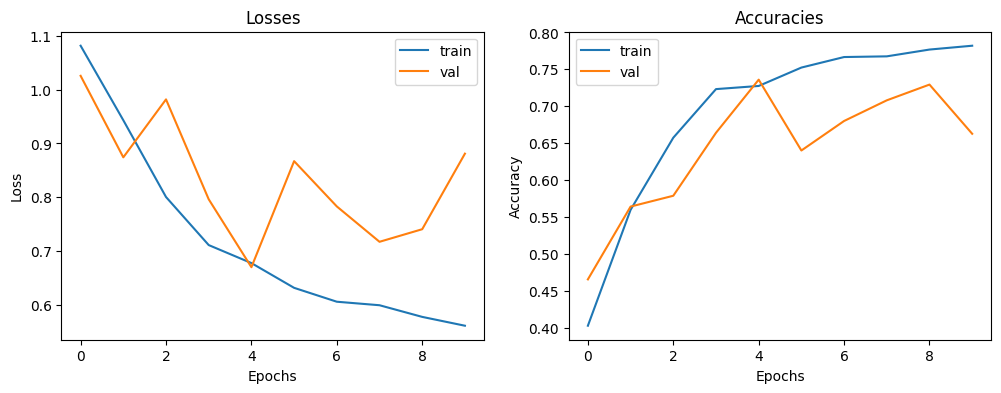

RNN hidden size = 128


Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:20<00:00,  5.68it/s]


loss = 1.081802312774047, val_loss =1.006507330042634, accuracy = 0.40746667981147766, val_accuracy = 0.48666664958000183


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:21<00:00,  5.38it/s]


loss = 0.9305557761726754, val_loss =0.8423951821152013, accuracy = 0.5573333501815796, val_accuracy = 0.6359999775886536


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:20<00:00,  5.79it/s]


loss = 0.7846655692517712, val_loss =0.7248405469395895, accuracy = 0.6471999883651733, val_accuracy = 0.7066666483879089


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:20<00:00,  5.77it/s]


loss = 0.6984101912506557, val_loss =0.7971616444988615, accuracy = 0.7266666889190674, val_accuracy = 0.6693333387374878


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:20<00:00,  5.81it/s]


loss = 0.650107141231351, val_loss =0.7774644207333355, accuracy = 0.7421333193778992, val_accuracy = 0.7226666808128357


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:20<00:00,  5.73it/s]


loss = 0.6119053499963121, val_loss =0.7626156570326387, accuracy = 0.7558666467666626, val_accuracy = 0.7279999852180481


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:20<00:00,  5.70it/s]


loss = 0.5927144680137636, val_loss =0.9015088056595771, accuracy = 0.7678666710853577, val_accuracy = 0.6840000152587891


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:21<00:00,  5.49it/s]


loss = 0.5882991409092543, val_loss =0.7572403726231984, accuracy = 0.7631999850273132, val_accuracy = 0.718666672706604


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:21<00:00,  5.59it/s]


loss = 0.5805543422394903, val_loss =1.0828433774736566, accuracy = 0.7728000283241272, val_accuracy = 0.6213333010673523


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:20<00:00,  5.80it/s]


loss = 0.5682382584911088, val_loss =0.9380633553329867, accuracy = 0.7762666940689087, val_accuracy = 0.6866666674613953


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


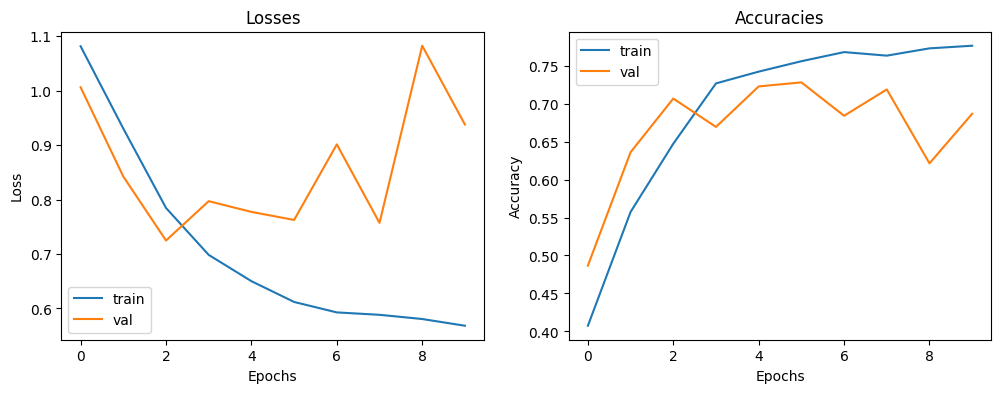

RNN hidden size = 256


Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:21<00:00,  5.42it/s]


loss = 1.0276698937453297, val_loss =0.8826169715991811, accuracy = 0.4487999975681305, val_accuracy = 0.6213333010673523


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:22<00:00,  5.13it/s]


loss = 0.8352462581910322, val_loss =0.7986249391441285, accuracy = 0.6051999926567078, val_accuracy = 0.6946666836738586


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:21<00:00,  5.41it/s]


loss = 0.728349738638184, val_loss =0.8142567580074208, accuracy = 0.6849333643913269, val_accuracy = 0.7226666808128357


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:21<00:00,  5.44it/s]


loss = 0.6759448125844242, val_loss =0.9136166014920319, accuracy = 0.7338666915893555, val_accuracy = 0.6973333358764648


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:21<00:00,  5.46it/s]


loss = 0.6328046757010451, val_loss =0.9817340643939384, accuracy = 0.7449333667755127, val_accuracy = 0.6480000019073486


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:22<00:00,  5.21it/s]


loss = 0.6170742867019489, val_loss =0.8450606483143085, accuracy = 0.7628000378608704, val_accuracy = 0.7039999961853027


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:21<00:00,  5.38it/s]


loss = 0.5899827014669062, val_loss =0.8226644234228329, accuracy = 0.765333354473114, val_accuracy = 0.734666645526886


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:21<00:00,  5.40it/s]


loss = 0.5959875898997472, val_loss =0.9865453928269098, accuracy = 0.76173335313797, val_accuracy = 0.6693333387374878


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:21<00:00,  5.41it/s]


loss = 0.5561582246186639, val_loss =0.8363763754637213, accuracy = 0.7798666954040527, val_accuracy = 0.7039999961853027


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:22<00:00,  5.20it/s]


loss = 0.5499829330632193, val_loss =0.7198522393437746, accuracy = 0.77920001745224, val_accuracy = 0.7413333058357239


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


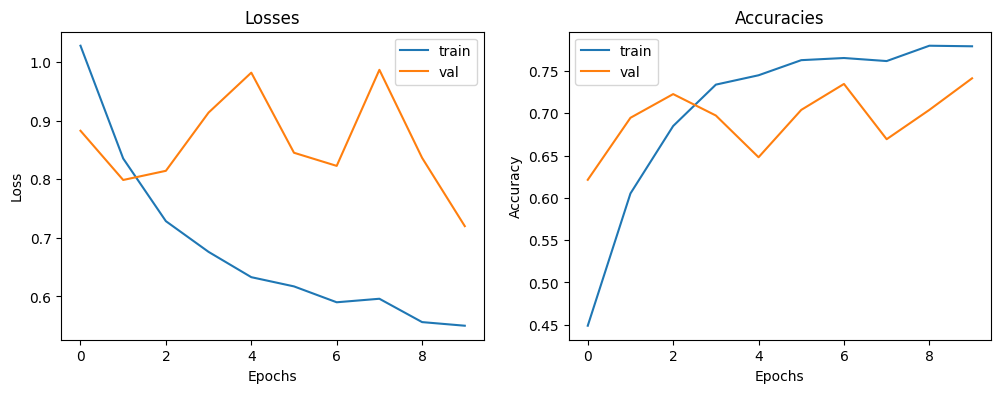

RNN hidden size = 512


In [ ]:
bidirectional=True
num_layers=1
rnn_hidden_sizes=[32,64,128,256,512]
for hidden_size in rnn_hidden_sizes:
  model=RNN_AraBERT(hidden_size,hidden_size2,num_layers,bidirectional,droprate).to(device,non_blocking=True)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,full_dataloader,test_loader)
  print(f'RNN hidden size = {hidden_size}')

Epoch 1: 100%|██████████| 118/118 [00:21<00:00,  5.44it/s]


loss = 1.0122765086664907, val_loss =0.918051569876126, accuracy = 0.46240001916885376, val_accuracy = 0.5426666736602783


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:21<00:00,  5.49it/s]


loss = 0.8374186773796544, val_loss =0.8137006843871727, accuracy = 0.5914666652679443, val_accuracy = 0.6613333225250244


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:21<00:00,  5.42it/s]


loss = 0.7442460618697245, val_loss =0.8702054675128581, accuracy = 0.665066659450531, val_accuracy = 0.6866666674613953


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:22<00:00,  5.23it/s]


loss = 0.6697922818525422, val_loss =0.9731566754185157, accuracy = 0.7269333600997925, val_accuracy = 0.7013333439826965


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:21<00:00,  5.43it/s]


loss = 0.6168606759717533, val_loss =0.7537093692736706, accuracy = 0.7585333585739136, val_accuracy = 0.7333333492279053


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:21<00:00,  5.41it/s]


loss = 0.6170833268239464, val_loss =0.9825357640719617, accuracy = 0.7529333233833313, val_accuracy = 0.6733333468437195


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:21<00:00,  5.45it/s]


loss = 0.598742527828706, val_loss =0.8237474821240092, accuracy = 0.7710666656494141, val_accuracy = 0.7080000042915344


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:22<00:00,  5.28it/s]


loss = 0.5813946234801871, val_loss =0.7352901797099891, accuracy = 0.7665333151817322, val_accuracy = 0.7426666617393494


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:21<00:00,  5.45it/s]


loss = 0.5530106712798875, val_loss =0.8010222213762734, accuracy = 0.7834666967391968, val_accuracy = 0.7546666860580444


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:21<00:00,  5.42it/s]


loss = 0.5691744383827607, val_loss =0.9641562104637463, accuracy = 0.7662667036056519, val_accuracy = 0.6639999747276306


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


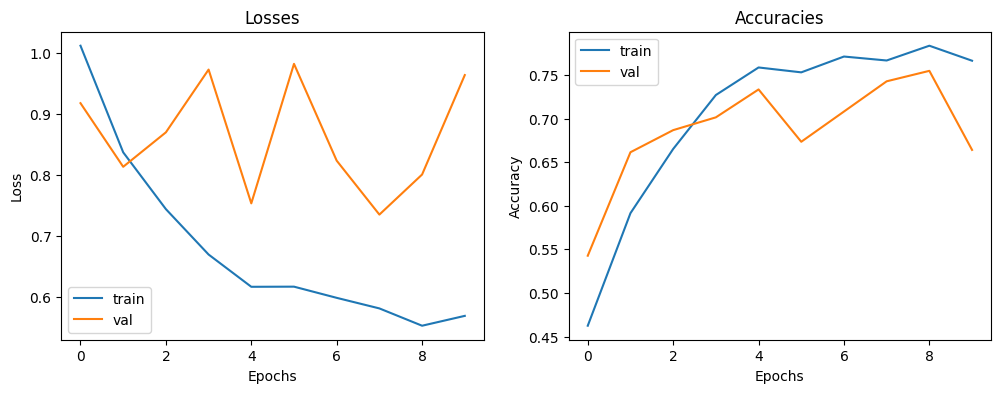

In [ ]:
hidden_size=512
model=RNN_AraBERT(hidden_size,hidden_size2,num_layers,bidirectional,droprate).to(device,non_blocking=True)
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
train(model,epoch,optimizer,criterion,full_dataloader,test_loader)

Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:20<00:00,  5.74it/s]


loss = 1.0797093127022819, val_loss =1.0183727002847751, accuracy = 0.3994666635990143, val_accuracy = 0.47333332896232605


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:20<00:00,  5.64it/s]


loss = 0.9248990796777382, val_loss =0.8447399850313863, accuracy = 0.550266683101654, val_accuracy = 0.6200000047683716


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:19<00:00,  6.05it/s]


loss = 0.8282430822270473, val_loss =0.9096327676932138, accuracy = 0.6019999980926514, val_accuracy = 0.6200000047683716


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:19<00:00,  5.99it/s]


loss = 0.7523079831997083, val_loss =0.940210945858912, accuracy = 0.6697333455085754, val_accuracy = 0.5853333473205566


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:19<00:00,  5.99it/s]


loss = 0.6962277299893875, val_loss =1.0465451568910056, accuracy = 0.7204000353813171, val_accuracy = 0.5920000076293945


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:19<00:00,  5.99it/s]


loss = 0.661272742990458, val_loss =0.9360881752776997, accuracy = 0.7498666644096375, val_accuracy = 0.5759999752044678


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:19<00:00,  5.95it/s]


loss = 0.6312840868349006, val_loss =0.9340262460226887, accuracy = 0.7513333559036255, val_accuracy = 0.6013333201408386


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:19<00:00,  5.95it/s]


loss = 0.6312345862857758, val_loss =0.7971907833937397, accuracy = 0.7502666711807251, val_accuracy = 0.6746666431427002


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:20<00:00,  5.68it/s]


loss = 0.5873129848453021, val_loss =0.8360788205734381, accuracy = 0.7738666534423828, val_accuracy = 0.6573333144187927


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:21<00:00,  5.53it/s]


loss = 0.591006705709156, val_loss =0.894953642743201, accuracy = 0.7678666710853577, val_accuracy = 0.6293333172798157


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


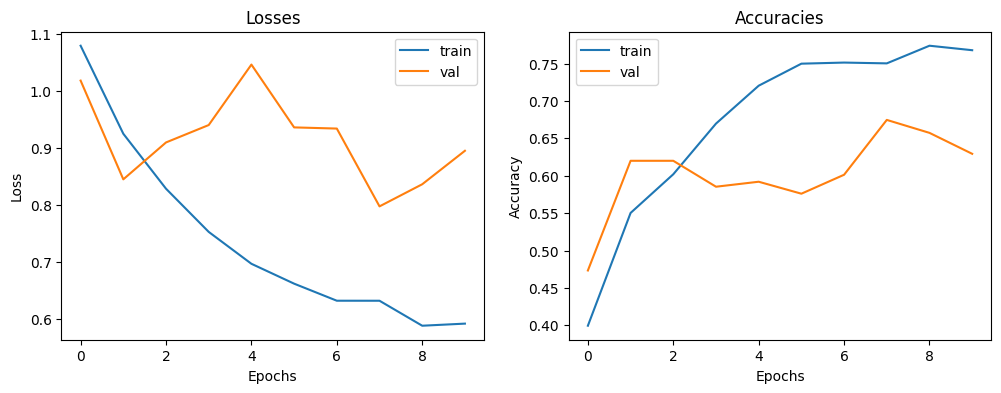

fully-connected hidden size = 32
Test correct = 472

Test total dataitem = 750

Test Accuracy = 0.6293333172798157

              precision    recall  f1-score   support

    negative       0.82      0.46      0.59       250
     neutral       0.52      0.89      0.65       250
    positive       0.74      0.54      0.62       250

    accuracy                           0.63       750
   macro avg       0.69      0.63      0.62       750
weighted avg       0.69      0.63      0.62       750



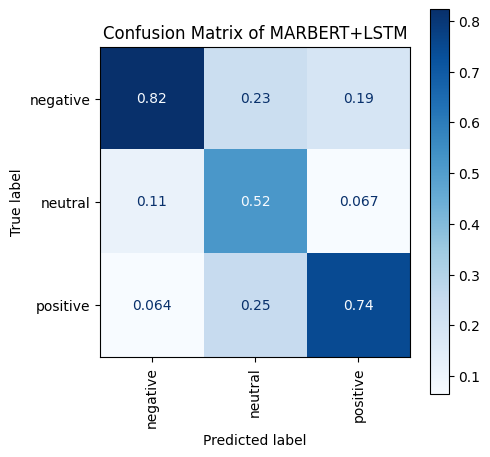

Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:19<00:00,  5.91it/s]


loss = 1.0889661369153356, val_loss =1.0417366681006346, accuracy = 0.39533334970474243, val_accuracy = 0.4519999921321869


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:19<00:00,  5.94it/s]


loss = 0.9661903462646, val_loss =0.9186427153729618, accuracy = 0.5234666466712952, val_accuracy = 0.527999997138977


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:20<00:00,  5.86it/s]


loss = 0.8112659935723882, val_loss =1.10629869588698, accuracy = 0.6237333416938782, val_accuracy = 0.47066664695739746


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:21<00:00,  5.60it/s]


loss = 0.7055069899399344, val_loss =1.0417429627848542, accuracy = 0.6969333291053772, val_accuracy = 0.5613332986831665


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:19<00:00,  5.97it/s]


loss = 0.6426061287274831, val_loss =1.399839573934804, accuracy = 0.7486667037010193, val_accuracy = 0.46399998664855957


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:19<00:00,  5.97it/s]


loss = 0.6078487759180097, val_loss =1.4189786580785606, accuracy = 0.7559999823570251, val_accuracy = 0.5400000214576721


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:19<00:00,  5.94it/s]


loss = 0.573371933068502, val_loss =1.4382226409315066, accuracy = 0.7710666656494141, val_accuracy = 0.5199999809265137


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:19<00:00,  5.94it/s]


loss = 0.5598654022158982, val_loss =1.5040500624032784, accuracy = 0.7825333476066589, val_accuracy = 0.5080000162124634


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:19<00:00,  5.93it/s]


loss = 0.5614044136629871, val_loss =1.1791692927521502, accuracy = 0.7769333124160767, val_accuracy = 0.6026666760444641


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:20<00:00,  5.89it/s]


loss = 0.5379836005060322, val_loss =1.7874743999595724, accuracy = 0.786133348941803, val_accuracy = 0.47999998927116394


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


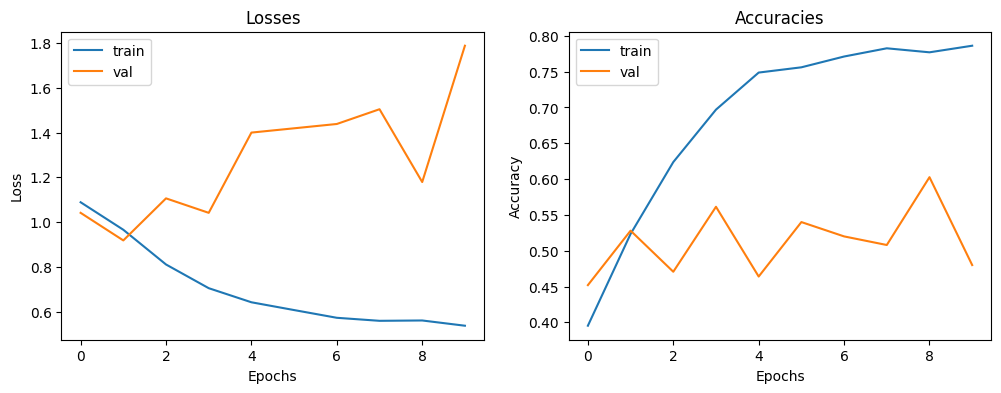

fully-connected hidden size = 64
Test correct = 360

Test total dataitem = 750

Test Accuracy = 0.47999998927116394

              precision    recall  f1-score   support

    negative       0.84      0.20      0.32       250
     neutral       0.81      0.29      0.43       250
    positive       0.40      0.95      0.56       250

    accuracy                           0.48       750
   macro avg       0.68      0.48      0.44       750
weighted avg       0.68      0.48      0.44       750



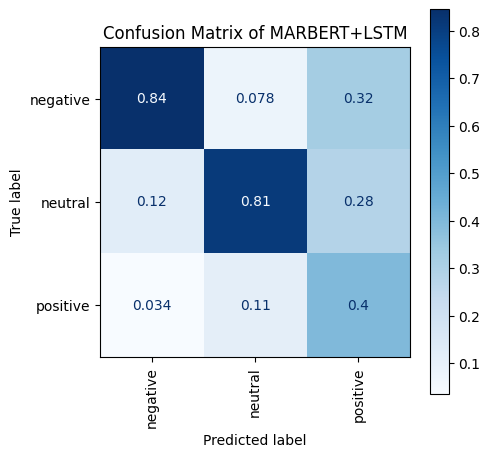

Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:21<00:00,  5.56it/s]


loss = 1.0783014615450455, val_loss =1.028602028272344, accuracy = 0.40693333745002747, val_accuracy = 0.4426666498184204


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:19<00:00,  5.93it/s]


loss = 0.9080380726256901, val_loss =1.0214219601678096, accuracy = 0.5618667006492615, val_accuracy = 0.5133333206176758


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:19<00:00,  5.96it/s]


loss = 0.7435698834761562, val_loss =0.8078737219532385, accuracy = 0.6643999814987183, val_accuracy = 0.5960000157356262


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:19<00:00,  6.02it/s]


loss = 0.6289914768936067, val_loss =0.7394005138120375, accuracy = 0.7402666807174683, val_accuracy = 0.6599999666213989


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:19<00:00,  6.00it/s]


loss = 0.6014051336793159, val_loss =0.8662500099324962, accuracy = 0.7609333395957947, val_accuracy = 0.6306666731834412


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:20<00:00,  5.89it/s]


loss = 0.5685665715512874, val_loss =0.7143400807169424, accuracy = 0.770799994468689, val_accuracy = 0.6773333549499512


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:19<00:00,  5.91it/s]


loss = 0.5554864015044191, val_loss =0.667471470497981, accuracy = 0.7793333530426025, val_accuracy = 0.7293333411216736


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:19<00:00,  5.97it/s]


loss = 0.5479745120712175, val_loss =0.7347675111670231, accuracy = 0.7801333665847778, val_accuracy = 0.6666666865348816


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:20<00:00,  5.79it/s]


loss = 0.5287510228869705, val_loss =0.730808626444596, accuracy = 0.7885333299636841, val_accuracy = 0.6759999990463257


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:21<00:00,  5.50it/s]


loss = 0.5191763503217119, val_loss =0.7710647752393159, accuracy = 0.7911999821662903, val_accuracy = 0.6639999747276306


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


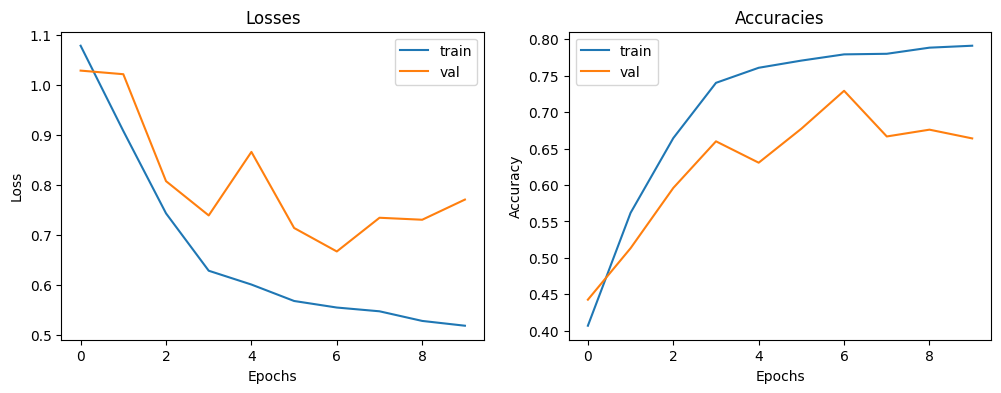

fully-connected hidden size = 128
Test correct = 498

Test total dataitem = 750

Test Accuracy = 0.6639999747276306

              precision    recall  f1-score   support

    negative       0.86      0.49      0.63       250
     neutral       0.61      0.80      0.69       250
    positive       0.63      0.70      0.66       250

    accuracy                           0.66       750
   macro avg       0.70      0.66      0.66       750
weighted avg       0.70      0.66      0.66       750



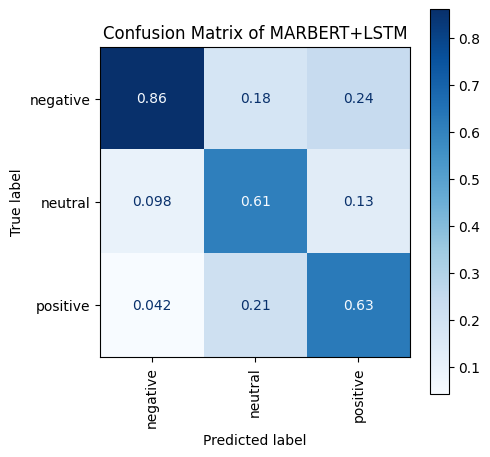

Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:19<00:00,  5.91it/s]


loss = 1.0804087420199382, val_loss =1.0156182082643246, accuracy = 0.3973333239555359, val_accuracy = 0.47866666316986084


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:19<00:00,  5.96it/s]


loss = 0.873068034202801, val_loss =0.798879983899035, accuracy = 0.5900000333786011, val_accuracy = 0.6639999747276306


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:19<00:00,  5.92it/s]


loss = 0.7131247405701637, val_loss =0.7989760121843942, accuracy = 0.6890666484832764, val_accuracy = 0.6439999938011169


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:19<00:00,  5.91it/s]


loss = 0.6266746339388602, val_loss =0.7223504587583601, accuracy = 0.7419999837875366, val_accuracy = 0.690666675567627


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:20<00:00,  5.85it/s]


loss = 0.584520438473099, val_loss =0.6926913063585559, accuracy = 0.7603999972343445, val_accuracy = 0.7039999961853027


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:20<00:00,  5.83it/s]


loss = 0.5698294636093093, val_loss =0.7246800657136929, accuracy = 0.7692000269889832, val_accuracy = 0.6840000152587891


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:21<00:00,  5.54it/s]


loss = 0.5511911753614196, val_loss =0.7477602350861517, accuracy = 0.7757333517074585, val_accuracy = 0.6919999718666077


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:19<00:00,  5.97it/s]


loss = 0.5369264811940776, val_loss =0.7156334487957318, accuracy = 0.7785333395004272, val_accuracy = 0.7093333005905151


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:19<00:00,  5.92it/s]


loss = 0.5205415022105087, val_loss =0.6647806711848386, accuracy = 0.7872000336647034, val_accuracy = 0.7279999852180481


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:19<00:00,  5.91it/s]


loss = 0.5111925540793603, val_loss =0.6584914055848207, accuracy = 0.7893333435058594, val_accuracy = 0.7266666293144226


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


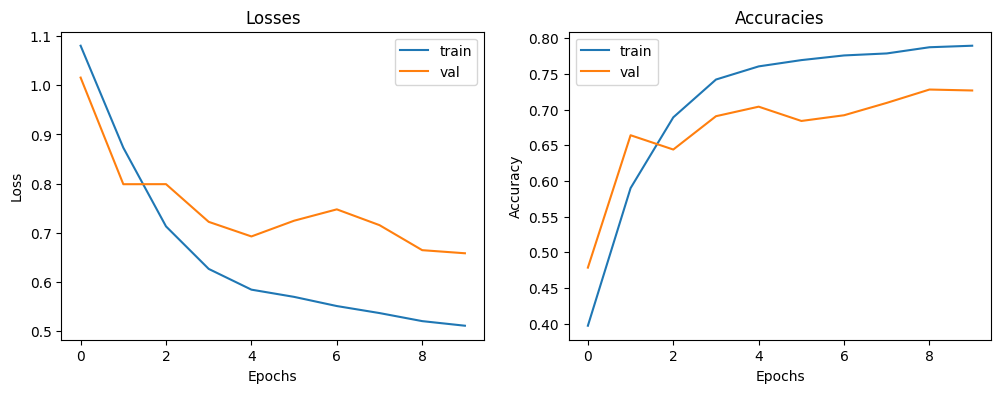

fully-connected hidden size = 256
Test correct = 545

Test total dataitem = 750

Test Accuracy = 0.7266666293144226

              precision    recall  f1-score   support

    negative       0.77      0.74      0.76       250
     neutral       0.68      0.69      0.68       250
    positive       0.73      0.75      0.74       250

    accuracy                           0.73       750
   macro avg       0.73      0.73      0.73       750
weighted avg       0.73      0.73      0.73       750



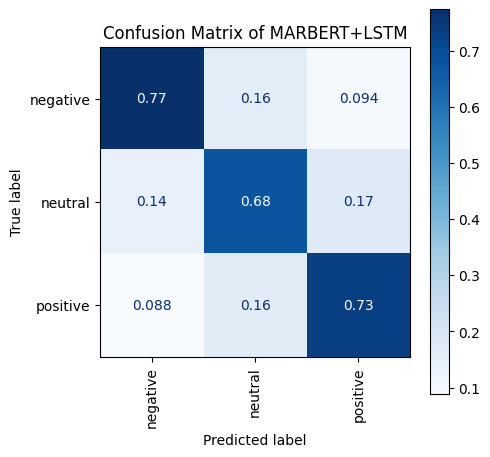

Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:20<00:00,  5.75it/s]


loss = 1.0802450390929872, val_loss =0.9967933004887343, accuracy = 0.4002666771411896, val_accuracy = 0.5


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:22<00:00,  5.35it/s]


loss = 0.8450052235043662, val_loss =0.965729806317435, accuracy = 0.5893333554267883, val_accuracy = 0.518666684627533


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:19<00:00,  5.97it/s]


loss = 0.6852165085809371, val_loss =0.7275089389029586, accuracy = 0.6934666633605957, val_accuracy = 0.6973333358764648


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:19<00:00,  5.90it/s]


loss = 0.6075625223613911, val_loss =0.6930140580018591, accuracy = 0.7465333342552185, val_accuracy = 0.7106666564941406


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:20<00:00,  5.87it/s]


loss = 0.5701317836431932, val_loss =0.7100980161971613, accuracy = 0.7677333354949951, val_accuracy = 0.6800000071525574


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:20<00:00,  5.88it/s]


loss = 0.565868135039472, val_loss =0.8611207394916572, accuracy = 0.7682666778564453, val_accuracy = 0.6453333497047424


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:20<00:00,  5.86it/s]


loss = 0.5322785503145692, val_loss =0.7189097563236103, accuracy = 0.7853333353996277, val_accuracy = 0.690666675567627


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:20<00:00,  5.84it/s]


loss = 0.5226467484307594, val_loss =0.6972966187213255, accuracy = 0.7874667048454285, val_accuracy = 0.6800000071525574


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:19<00:00,  5.90it/s]


loss = 0.5132553801104119, val_loss =0.7279217161551482, accuracy = 0.7894666790962219, val_accuracy = 0.6893333196640015


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:20<00:00,  5.89it/s]


loss = 0.5073707831417089, val_loss =0.6952669895214005, accuracy = 0.7925333380699158, val_accuracy = 0.7133333086967468


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


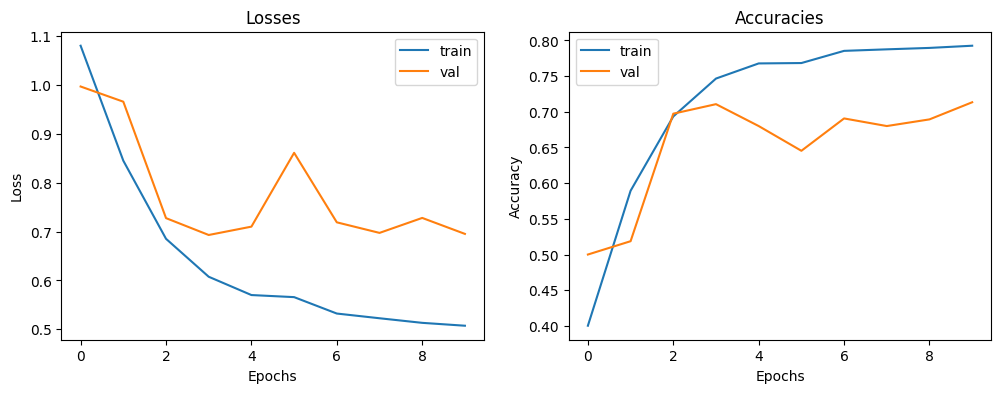

fully-connected hidden size = 512
Test correct = 535

Test total dataitem = 750

Test Accuracy = 0.7133333086967468

              precision    recall  f1-score   support

    negative       0.81      0.64      0.72       250
     neutral       0.62      0.76      0.68       250
    positive       0.75      0.74      0.75       250

    accuracy                           0.71       750
   macro avg       0.73      0.71      0.71       750
weighted avg       0.73      0.71      0.71       750



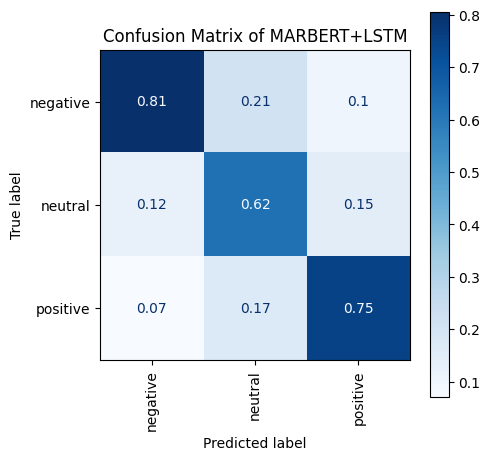

In [ ]:
bidirectional=True
num_layers=1
hidden_size1=128
fc_hidden_size=[32,64,128,256,512]
for hidden_size in fc_hidden_size:
  model=RNN_AraBERT(hidden_size1,hidden_size,num_layers,bidirectional,droprate).to(device,non_blocking=True)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,full_dataloader,test_loader)
  print(f'fully-connected hidden size = {hidden_size}')
  model_name='MARBERT+LSTM'
  test_and_report(model,test_loader,model_name)

Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:24<00:00,  4.80it/s]


loss = 0.9184451285488808, val_loss =0.9157869191165419, accuracy = 0.5314666628837585, val_accuracy = 0.5946666598320007


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:19<00:00,  5.92it/s]


loss = 0.6735163059988298, val_loss =0.8892453691963885, accuracy = 0.7217333316802979, val_accuracy = 0.6466666460037231


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:19<00:00,  5.99it/s]


loss = 0.5870306038906078, val_loss =1.0903504397713772, accuracy = 0.7642666697502136, val_accuracy = 0.628000020980835


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:19<00:00,  5.96it/s]


loss = 0.5377641284158428, val_loss =1.2767201908275678, accuracy = 0.7839999794960022, val_accuracy = 0.5786666870117188


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:20<00:00,  5.79it/s]


loss = 0.5299118900607168, val_loss =1.0899556817048637, accuracy = 0.7839999794960022, val_accuracy = 0.6266666650772095


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:21<00:00,  5.46it/s]


loss = 0.499887168413894, val_loss =0.887549705851558, accuracy = 0.7989333271980286, val_accuracy = 0.671999990940094


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:19<00:00,  5.94it/s]


loss = 0.4892754825202508, val_loss =0.9468066964542706, accuracy = 0.7970666885375977, val_accuracy = 0.6759999990463257


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:20<00:00,  5.90it/s]


loss = 0.4911253920514139, val_loss =1.0872985823388908, accuracy = 0.7985333204269409, val_accuracy = 0.5733333230018616


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:21<00:00,  5.44it/s]


loss = 0.4684199258112982, val_loss =0.8213002711646907, accuracy = 0.809066653251648, val_accuracy = 0.7106666564941406


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:19<00:00,  5.95it/s]


loss = 0.4731978836802347, val_loss =0.8940024176975029, accuracy = 0.8037333488464355, val_accuracy = 0.671999990940094


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


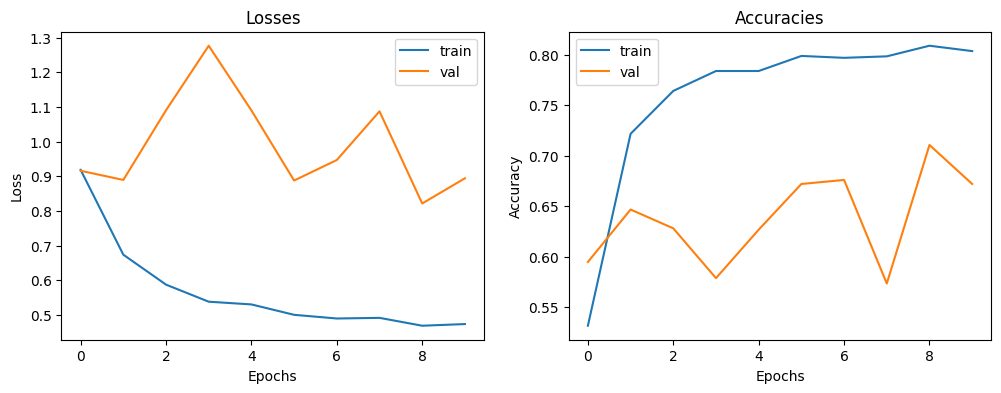

learning rate = 0.001


Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:20<00:00,  5.81it/s]


loss = 0.9043391408686662, val_loss =1.1552769247116859, accuracy = 0.5595999956130981, val_accuracy = 0.4959999918937683


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:19<00:00,  5.93it/s]


loss = 0.632205633117707, val_loss =0.7187777065629378, accuracy = 0.7391999959945679, val_accuracy = 0.7013333439826965


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:19<00:00,  5.98it/s]


loss = 0.566509023181591, val_loss =0.7388439679630011, accuracy = 0.7754666805267334, val_accuracy = 0.7080000042915344


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:23<00:00,  5.07it/s]


loss = 0.5313206849213533, val_loss =0.8488497060159558, accuracy = 0.7830666899681091, val_accuracy = 0.6826666593551636


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:20<00:00,  5.77it/s]


loss = 0.5055401362808644, val_loss =0.72037424562059, accuracy = 0.7953333258628845, val_accuracy = 0.7133333086967468


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:19<00:00,  5.97it/s]


loss = 0.49630722571587504, val_loss =0.633159556870574, accuracy = 0.7986666560173035, val_accuracy = 0.7479999661445618


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:20<00:00,  5.81it/s]


loss = 0.4873605216435085, val_loss =0.7571904377167732, accuracy = 0.8018666505813599, val_accuracy = 0.7133333086967468


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:19<00:00,  5.96it/s]


loss = 0.4746319902424661, val_loss =0.6422798362655421, accuracy = 0.8040000200271606, val_accuracy = 0.7559999823570251


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:19<00:00,  6.00it/s]


loss = 0.47002428911987154, val_loss =0.7101054983093794, accuracy = 0.8042666912078857, val_accuracy = 0.7266666293144226


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:19<00:00,  5.91it/s]


loss = 0.4549036892105314, val_loss =0.761162204602429, accuracy = 0.8102666735649109, val_accuracy = 0.7133333086967468


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


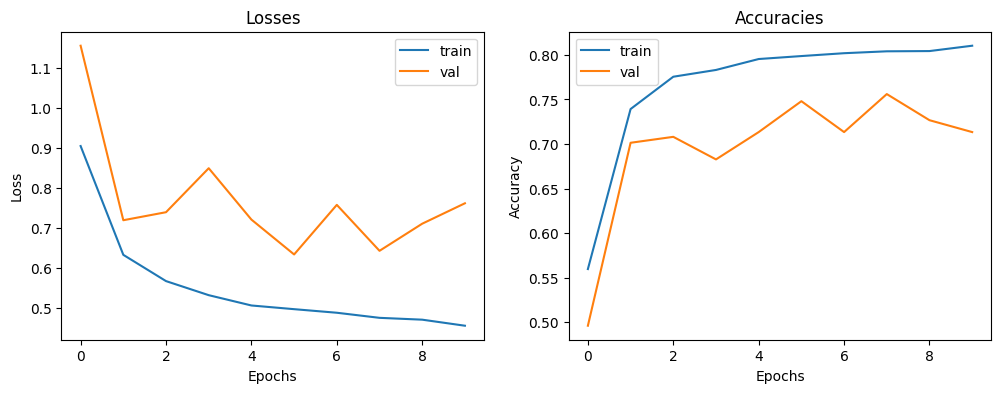

learning rate = 0.002


Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:21<00:00,  5.47it/s]


loss = 0.8508411749543725, val_loss =0.7879782548057003, accuracy = 0.593999981880188, val_accuracy = 0.653333306312561


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:19<00:00,  5.97it/s]


loss = 0.6090687445722853, val_loss =0.7179739766546898, accuracy = 0.7544000148773193, val_accuracy = 0.7013333439826965


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:19<00:00,  5.96it/s]


loss = 0.5609838893856943, val_loss =0.6535164677279944, accuracy = 0.7749333381652832, val_accuracy = 0.7333333492279053


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:19<00:00,  5.98it/s]


loss = 0.5298259040621591, val_loss =0.6620421290807418, accuracy = 0.7873333692550659, val_accuracy = 0.7333333492279053


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:19<00:00,  5.94it/s]


loss = 0.5130868178769376, val_loss =0.7444439713919196, accuracy = 0.7900000214576721, val_accuracy = 0.7199999690055847


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:19<00:00,  5.92it/s]


loss = 0.48161014028877136, val_loss =0.8181498373961021, accuracy = 0.8030666708946228, val_accuracy = 0.6653333306312561


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:19<00:00,  5.93it/s]


loss = 0.4881440489221123, val_loss =0.69147664531419, accuracy = 0.8025333285331726, val_accuracy = 0.718666672706604


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:20<00:00,  5.89it/s]


loss = 0.48170777195649683, val_loss =0.7401745544517536, accuracy = 0.8044000267982483, val_accuracy = 0.7253333330154419


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:20<00:00,  5.78it/s]


loss = 0.45988267153080115, val_loss =0.7198658036615888, accuracy = 0.8101333379745483, val_accuracy = 0.7066666483879089


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:21<00:00,  5.50it/s]


loss = 0.44499738126673116, val_loss =0.6790368137068233, accuracy = 0.8184000253677368, val_accuracy = 0.734666645526886


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


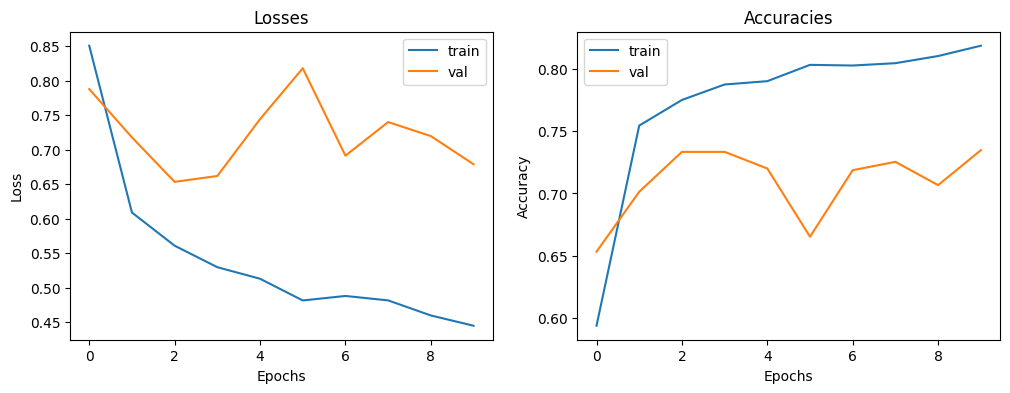

learning rate = 0.003


Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:19<00:00,  5.91it/s]


loss = 1.0927056905255774, val_loss =1.0667465832658058, accuracy = 0.3725333511829376, val_accuracy = 0.40666666626930237


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:19<00:00,  5.95it/s]


loss = 1.0035901906496272, val_loss =0.8990547123678919, accuracy = 0.5066666603088379, val_accuracy = 0.5573333501815796


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:19<00:00,  5.92it/s]


loss = 0.8396525035630701, val_loss =0.8395806962655405, accuracy = 0.5977333188056946, val_accuracy = 0.5866666436195374


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:20<00:00,  5.87it/s]


loss = 0.7498917527053516, val_loss =0.8502709005735358, accuracy = 0.654533326625824, val_accuracy = 0.6079999804496765


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:20<00:00,  5.88it/s]


loss = 0.6912712884528692, val_loss =0.8384700694235937, accuracy = 0.6934666633605957, val_accuracy = 0.6493332982063293


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:20<00:00,  5.85it/s]


loss = 0.6396049661012244, val_loss =0.705830765032379, accuracy = 0.7360000014305115, val_accuracy = 0.7053333520889282


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:19<00:00,  5.92it/s]


loss = 0.5959629892624774, val_loss =0.7170957089675948, accuracy = 0.7562666535377502, val_accuracy = 0.6986666321754456


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:21<00:00,  5.60it/s]


loss = 0.5800971899483618, val_loss =0.6971362991355726, accuracy = 0.7688000202178955, val_accuracy = 0.7239999771118164


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:23<00:00,  5.06it/s]


loss = 0.5558651075654656, val_loss =0.9364325453590964, accuracy = 0.7749333381652832, val_accuracy = 0.6493332982063293


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:20<00:00,  5.88it/s]


loss = 0.5567274527644454, val_loss =0.8007530733154019, accuracy = 0.7778666615486145, val_accuracy = 0.6786666512489319


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


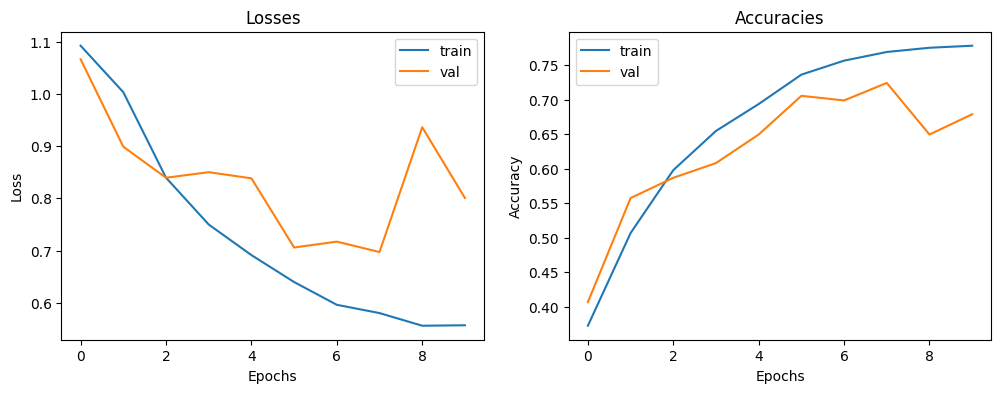

learning rate = 0.0001


Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:20<00:00,  5.79it/s]


loss = 1.0806936203386361, val_loss =1.019570844274932, accuracy = 0.3989333510398865, val_accuracy = 0.5559999942779541


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:20<00:00,  5.79it/s]


loss = 0.8904196262331832, val_loss =0.8380754822485513, accuracy = 0.5701333284378052, val_accuracy = 0.6426666378974915


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:22<00:00,  5.27it/s]


loss = 0.7308832508286, val_loss =0.7748860129772304, accuracy = 0.6697333455085754, val_accuracy = 0.6573333144187927


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:20<00:00,  5.86it/s]


loss = 0.6237994393033588, val_loss =0.6664909983177811, accuracy = 0.7433333396911621, val_accuracy = 0.7453333139419556


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:20<00:00,  5.75it/s]


loss = 0.5905295359035094, val_loss =0.7292864825599743, accuracy = 0.7541333436965942, val_accuracy = 0.7053333520889282


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:20<00:00,  5.76it/s]


loss = 0.5818653335001707, val_loss =0.7441543456454015, accuracy = 0.7634666562080383, val_accuracy = 0.7026666402816772


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:21<00:00,  5.51it/s]


loss = 0.5334079034822585, val_loss =0.8658865997487633, accuracy = 0.782800018787384, val_accuracy = 0.653333306312561


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:20<00:00,  5.75it/s]


loss = 0.5459414331336188, val_loss =0.7485816155680948, accuracy = 0.7782666683197021, val_accuracy = 0.7106666564941406


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:20<00:00,  5.90it/s]


loss = 0.5254260908459915, val_loss =0.7997130216279639, accuracy = 0.7841333150863647, val_accuracy = 0.6919999718666077


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:20<00:00,  5.72it/s]


loss = 0.5071761620899867, val_loss =0.7690342315070375, accuracy = 0.7972000241279602, val_accuracy = 0.6946666836738586


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


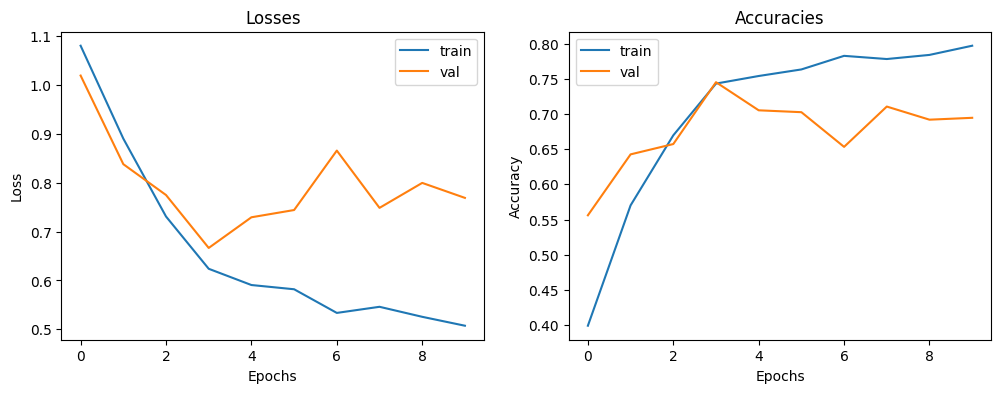

learning rate = 0.0002


Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:20<00:00,  5.75it/s]


loss = 1.0409794883644023, val_loss =1.0937709961199553, accuracy = 0.43906667828559875, val_accuracy = 0.5026666522026062


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:20<00:00,  5.63it/s]


loss = 0.8002242851699176, val_loss =0.7801868604277632, accuracy = 0.6325333118438721, val_accuracy = 0.6639999747276306


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:21<00:00,  5.61it/s]


loss = 0.6354129720483114, val_loss =0.8375405766876782, accuracy = 0.7393333315849304, val_accuracy = 0.6119999885559082


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:21<00:00,  5.49it/s]


loss = 0.6033097229913021, val_loss =0.8060882126229588, accuracy = 0.7598666548728943, val_accuracy = 0.6626666784286499


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:19<00:00,  5.93it/s]


loss = 0.5656653954586232, val_loss =0.7736637755382537, accuracy = 0.7712000012397766, val_accuracy = 0.699999988079071


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:19<00:00,  5.91it/s]


loss = 0.5307588833931866, val_loss =0.8381127570752617, accuracy = 0.7834666967391968, val_accuracy = 0.6586666703224182


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:19<00:00,  5.95it/s]


loss = 0.5280795057469577, val_loss =0.8636518705802766, accuracy = 0.7866666913032532, val_accuracy = 0.6186666488647461


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:19<00:00,  5.95it/s]


loss = 0.5030898518521202, val_loss =0.965490186635087, accuracy = 0.7906666994094849, val_accuracy = 0.6013333201408386


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:20<00:00,  5.78it/s]


loss = 0.5130421609851228, val_loss =0.8770088709813232, accuracy = 0.789733350276947, val_accuracy = 0.6520000100135803


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:20<00:00,  5.69it/s]


loss = 0.4853418678451658, val_loss =0.908479015032134, accuracy = 0.8022666573524475, val_accuracy = 0.6213333010673523


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


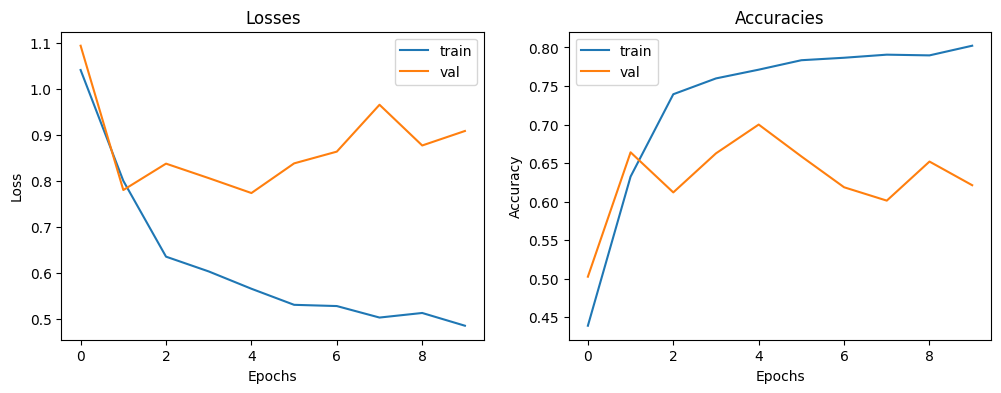

learning rate = 0.0003


Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:20<00:00,  5.72it/s]


loss = 1.1076012259443937, val_loss =1.0956045074584098, accuracy = 0.3277333378791809, val_accuracy = 0.3333333432674408


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:21<00:00,  5.61it/s]


loss = 1.1060647466535665, val_loss =1.0932817566343516, accuracy = 0.3330666720867157, val_accuracy = 0.3720000088214874


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:21<00:00,  5.41it/s]


loss = 1.1037027523089937, val_loss =1.0912081985363224, accuracy = 0.34626665711402893, val_accuracy = 0.40666666626930237


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:20<00:00,  5.89it/s]


loss = 1.0997598644919524, val_loss =1.088986138769331, accuracy = 0.3482666611671448, val_accuracy = 0.4573333263397217


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:20<00:00,  5.87it/s]


loss = 1.0980506878882899, val_loss =1.0867441642921472, accuracy = 0.35333332419395447, val_accuracy = 0.4413333237171173


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:20<00:00,  5.89it/s]


loss = 1.0968216725725068, val_loss =1.0843133259146218, accuracy = 0.35653334856033325, val_accuracy = 0.4266666769981384


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:20<00:00,  5.89it/s]


loss = 1.0919730786186785, val_loss =1.0818334732380144, accuracy = 0.37013334035873413, val_accuracy = 0.4399999976158142


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:20<00:00,  5.79it/s]


loss = 1.0874252606125412, val_loss =1.0786471576767338, accuracy = 0.390666663646698, val_accuracy = 0.4440000057220459


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:20<00:00,  5.78it/s]


loss = 1.0851547535361543, val_loss =1.07466114309036, accuracy = 0.39586666226387024, val_accuracy = 0.4466666579246521


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:20<00:00,  5.89it/s]


loss = 1.0829533934093338, val_loss =1.0698432349937332, accuracy = 0.4052000045776367, val_accuracy = 0.4426666498184204


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


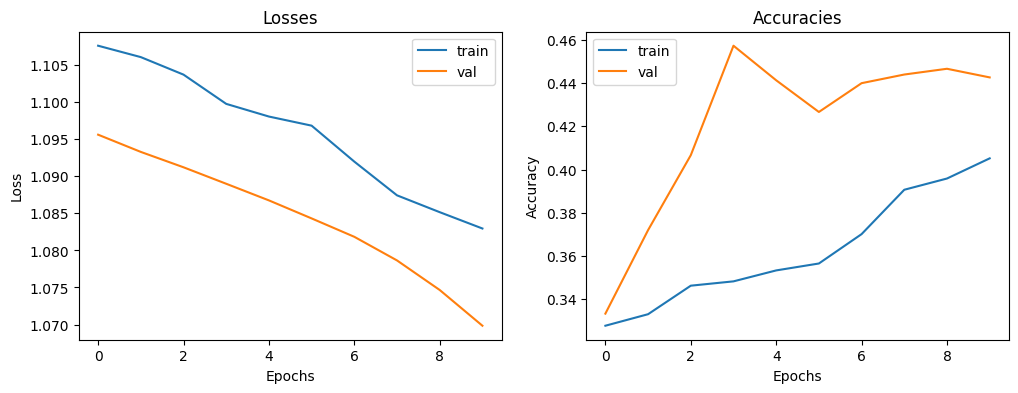

learning rate = 1e-05


In [ ]:
bidirectional=True
num_layers=1
hidden_size1=128
hidden_size2=256
learning_rates=[0.001,0.002,0.003,0.0001,0.0002,0.0003,0.00001]
for learning_rate in learning_rates:
  model=RNN_AraBERT(hidden_size1,hidden_size2,num_layers,bidirectional,droprate).to(device,non_blocking=True)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,full_dataloader,test_loader)
  print(f'learning rate = {learning_rate}')


Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:24<00:00,  4.87it/s]


loss = 0.8679588505405325, val_loss =0.6990090986628142, accuracy = 0.5740000009536743, val_accuracy = 0.7053333520889282


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:24<00:00,  4.78it/s]


loss = 0.6004115143503049, val_loss =0.7644639939783214, accuracy = 0.7390666604042053, val_accuracy = 0.6653333306312561


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:24<00:00,  4.90it/s]


loss = 0.5476186418276956, val_loss =0.77901516993718, accuracy = 0.7663999795913696, val_accuracy = 0.6693333387374878


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:23<00:00,  4.98it/s]


loss = 0.5241214553416336, val_loss =0.7179988940964298, accuracy = 0.77920001745224, val_accuracy = 0.7160000205039978


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:24<00:00,  4.84it/s]


loss = 0.48197936121636875, val_loss =0.6338431969194537, accuracy = 0.7993333339691162, val_accuracy = 0.7386666536331177


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:24<00:00,  4.80it/s]


loss = 0.46831491934447145, val_loss =0.9083472217506019, accuracy = 0.8058666586875916, val_accuracy = 0.6359999775886536


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:23<00:00,  4.93it/s]


loss = 0.47001743178069094, val_loss =0.913407041760207, accuracy = 0.7990666627883911, val_accuracy = 0.6586666703224182


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:25<00:00,  4.58it/s]


loss = 0.4489075258116637, val_loss =0.7635832089130207, accuracy = 0.8194666504859924, val_accuracy = 0.6653333306312561


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:24<00:00,  4.90it/s]


loss = 0.44165052728696874, val_loss =0.6319094994242218, accuracy = 0.818933367729187, val_accuracy = 0.7479999661445618


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:25<00:00,  4.71it/s]


loss = 0.4313421668624186, val_loss =0.737692321909244, accuracy = 0.8235999941825867, val_accuracy = 0.699999988079071


Epoch 11:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 118/118 [00:23<00:00,  4.93it/s]


loss = 0.4154590866450502, val_loss =0.6484771554195227, accuracy = 0.8249333500862122, val_accuracy = 0.7373332977294922


Epoch 12:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 118/118 [00:24<00:00,  4.73it/s]


loss = 0.41891016997769737, val_loss =0.7754540742901462, accuracy = 0.8278666734695435, val_accuracy = 0.690666675567627


Epoch 13:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 118/118 [00:24<00:00,  4.91it/s]


loss = 0.4060598816071726, val_loss =0.7543273425378794, accuracy = 0.8333333134651184, val_accuracy = 0.7013333439826965


Epoch 14:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 118/118 [00:24<00:00,  4.87it/s]


loss = 0.40885779059602095, val_loss =0.9237311174849072, accuracy = 0.8281333446502686, val_accuracy = 0.6800000071525574


Epoch 15:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 118/118 [00:23<00:00,  4.92it/s]


loss = 0.40186975273198927, val_loss =0.8223347206843017, accuracy = 0.8371999859809875, val_accuracy = 0.7093333005905151


<ipython-input-11-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


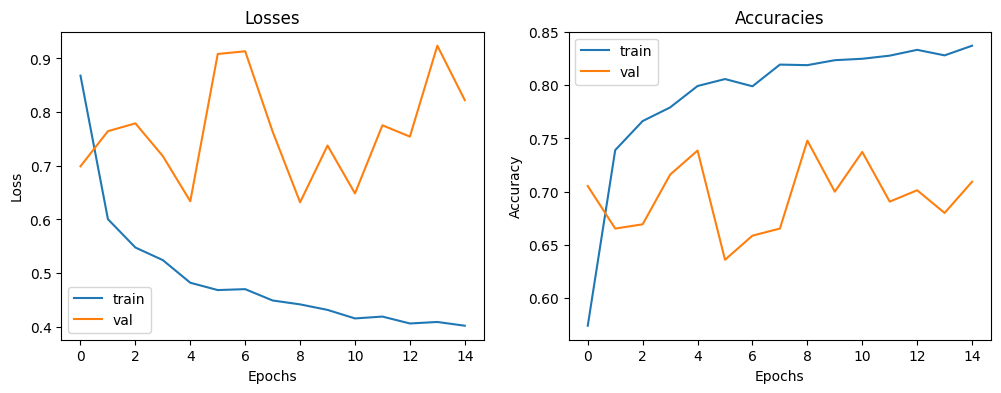

dropout rate = 0


Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:24<00:00,  4.84it/s]


loss = 0.8960365208623357, val_loss =0.8719115763492681, accuracy = 0.5437333583831787, val_accuracy = 0.5933333039283752


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:24<00:00,  4.86it/s]


loss = 0.6148189409326794, val_loss =0.7461329093133089, accuracy = 0.7344000339508057, val_accuracy = 0.6893333196640015


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:24<00:00,  4.84it/s]


loss = 0.553541850023873, val_loss =0.6579266767984718, accuracy = 0.7645333409309387, val_accuracy = 0.7440000176429749


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


loss = 0.5352148113214841, val_loss =0.6803102064296725, accuracy = 0.7773333191871643, val_accuracy = 0.734666645526886


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:24<00:00,  4.87it/s]


loss = 0.5007616135257975, val_loss =0.6919213416321314, accuracy = 0.7942667007446289, val_accuracy = 0.7199999690055847


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:25<00:00,  4.64it/s]


loss = 0.49063329420203, val_loss =0.6317456744707116, accuracy = 0.7954666614532471, val_accuracy = 0.7373332977294922


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:24<00:00,  4.88it/s]


loss = 0.4799656896361919, val_loss =0.7580543204981635, accuracy = 0.8044000267982483, val_accuracy = 0.6813333034515381


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:24<00:00,  4.80it/s]


loss = 0.4689261569822155, val_loss =0.6640377416039974, accuracy = 0.8129333257675171, val_accuracy = 0.7386666536331177


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:24<00:00,  4.88it/s]


loss = 0.45830468673547575, val_loss =0.6660744824254268, accuracy = 0.8125333189964294, val_accuracy = 0.7319999933242798


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:24<00:00,  4.78it/s]


loss = 0.432313788337344, val_loss =0.7414150243234673, accuracy = 0.8220000267028809, val_accuracy = 0.7026666402816772


Epoch 11:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 118/118 [00:23<00:00,  4.94it/s]


loss = 0.4387187313208219, val_loss =0.6767682434078712, accuracy = 0.8173333406448364, val_accuracy = 0.7386666536331177


Epoch 12:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 118/118 [00:24<00:00,  4.88it/s]


loss = 0.4315951855755499, val_loss =0.7917802004225107, accuracy = 0.8230666518211365, val_accuracy = 0.6933333277702332


Epoch 13:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 118/118 [00:24<00:00,  4.91it/s]


loss = 0.4280981557533773, val_loss =0.720277944535142, accuracy = 0.821066677570343, val_accuracy = 0.7306666374206543


Epoch 14:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 118/118 [00:24<00:00,  4.83it/s]


loss = 0.4216275156358726, val_loss =0.6272980103063225, accuracy = 0.8314666748046875, val_accuracy = 0.7759999632835388


Epoch 15:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 118/118 [00:23<00:00,  4.92it/s]


loss = 0.4060537056343299, val_loss =0.7586546958541938, accuracy = 0.8354666829109192, val_accuracy = 0.718666672706604


<ipython-input-11-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


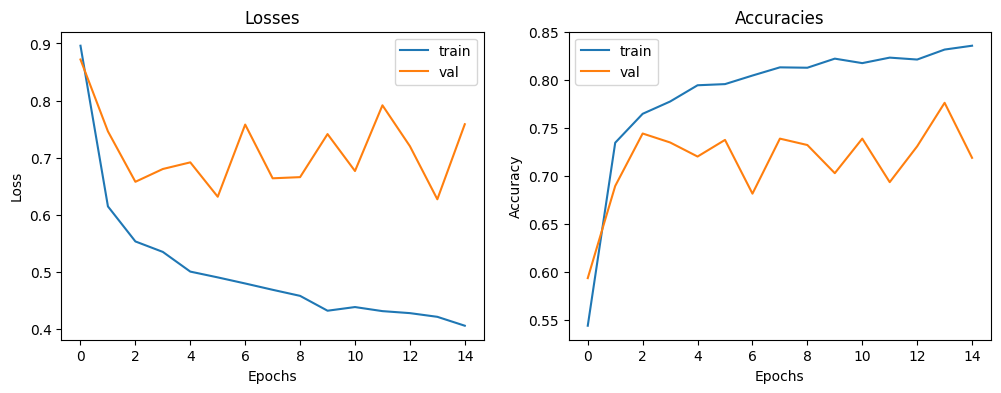

dropout rate = 0.1


Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:24<00:00,  4.74it/s]


loss = 0.8960036568876881, val_loss =0.8599156465337517, accuracy = 0.5411999821662903, val_accuracy = 0.5973333120346069


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:24<00:00,  4.91it/s]


loss = 0.6238936546626865, val_loss =0.7038045128094804, accuracy = 0.7360000014305115, val_accuracy = 0.7106666564941406


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:24<00:00,  4.90it/s]


loss = 0.5565832765311265, val_loss =0.8628850635068375, accuracy = 0.7685333490371704, val_accuracy = 0.6186666488647461


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:24<00:00,  4.90it/s]


loss = 0.5416306990143112, val_loss =0.7390775034659453, accuracy = 0.7810666561126709, val_accuracy = 0.6919999718666077


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:24<00:00,  4.83it/s]


loss = 0.5113374259761228, val_loss =0.7427259999747785, accuracy = 0.7854666709899902, val_accuracy = 0.6759999990463257


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:23<00:00,  4.92it/s]


loss = 0.4883838059881088, val_loss =0.7998884872755245, accuracy = 0.7957333326339722, val_accuracy = 0.6773333549499512


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:24<00:00,  4.81it/s]


loss = 0.4780353300193383, val_loss =0.7995815700689518, accuracy = 0.8017333149909973, val_accuracy = 0.6826666593551636


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


loss = 0.46662806726157224, val_loss =0.893971574145141, accuracy = 0.8062666654586792, val_accuracy = 0.6813333034515381


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


loss = 0.4657114558710835, val_loss =0.7666138017735068, accuracy = 0.8029333353042603, val_accuracy = 0.6959999799728394


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:25<00:00,  4.68it/s]


loss = 0.4524086680888664, val_loss =0.6552776488833184, accuracy = 0.8152000308036804, val_accuracy = 0.7306666374206543


Epoch 11:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


loss = 0.45770653065352684, val_loss =0.6322536249886531, accuracy = 0.8142666816711426, val_accuracy = 0.7479999661445618


Epoch 12:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 118/118 [00:25<00:00,  4.69it/s]


loss = 0.44714030476858313, val_loss =0.6827284470995094, accuracy = 0.8133333325386047, val_accuracy = 0.7400000095367432


Epoch 13:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 118/118 [00:24<00:00,  4.90it/s]


loss = 0.43473513596608054, val_loss =0.7767774031282527, accuracy = 0.8140000104904175, val_accuracy = 0.6959999799728394


Epoch 14:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 118/118 [00:24<00:00,  4.73it/s]


loss = 0.43146603784815607, val_loss =0.7454766430546179, accuracy = 0.8248000144958496, val_accuracy = 0.687999963760376


Epoch 15:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 118/118 [00:23<00:00,  4.92it/s]


loss = 0.4288925433435565, val_loss =0.6698190205138218, accuracy = 0.8238666653633118, val_accuracy = 0.7373332977294922


<ipython-input-11-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


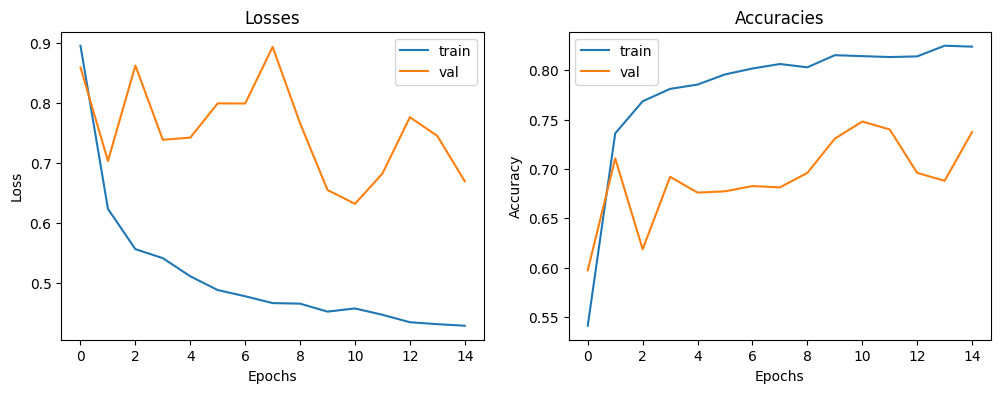

dropout rate = 0.2


Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:24<00:00,  4.80it/s]


loss = 0.8743168044022066, val_loss =0.844563083103993, accuracy = 0.5694666504859924, val_accuracy = 0.6693333387374878


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:24<00:00,  4.87it/s]


loss = 0.6312996180209348, val_loss =0.7030982590421037, accuracy = 0.7302666902542114, val_accuracy = 0.7053333520889282


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:24<00:00,  4.85it/s]


loss = 0.5765205759381712, val_loss =0.687709823386483, accuracy = 0.7516000270843506, val_accuracy = 0.7266666293144226


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:23<00:00,  4.94it/s]


loss = 0.5305591188124539, val_loss =0.7019455822682822, accuracy = 0.7739999890327454, val_accuracy = 0.7106666564941406


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:24<00:00,  4.76it/s]


loss = 0.5145975170926763, val_loss =0.6689613934606736, accuracy = 0.788266658782959, val_accuracy = 0.7253333330154419


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:23<00:00,  4.93it/s]


loss = 0.4953411952828156, val_loss =0.9401270787246809, accuracy = 0.7949333190917969, val_accuracy = 0.6306666731834412


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:24<00:00,  4.80it/s]


loss = 0.4953602396685633, val_loss =0.854317307021805, accuracy = 0.7998666763305664, val_accuracy = 0.7013333439826965


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:24<00:00,  4.90it/s]


loss = 0.46622863142963744, val_loss =0.7443651373488546, accuracy = 0.8085333704948425, val_accuracy = 0.7133333086967468


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:24<00:00,  4.85it/s]


loss = 0.4832320819226427, val_loss =0.8743553285476345, accuracy = 0.8054666519165039, val_accuracy = 0.6786666512489319


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:24<00:00,  4.90it/s]


loss = 0.4627227867565182, val_loss =0.7103903306264776, accuracy = 0.8073333501815796, val_accuracy = 0.7239999771118164


Epoch 11:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


loss = 0.4520635503876226, val_loss =1.0803276219695903, accuracy = 0.8138666749000549, val_accuracy = 0.6453333497047424


Epoch 12:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 118/118 [00:24<00:00,  4.81it/s]


loss = 0.4541629161071642, val_loss =0.7559506637155237, accuracy = 0.8116000294685364, val_accuracy = 0.6919999718666077


Epoch 13:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


loss = 0.4410602358901699, val_loss =1.1398357067345375, accuracy = 0.81413334608078, val_accuracy = 0.6759999990463257


Epoch 14:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 118/118 [00:25<00:00,  4.56it/s]


loss = 0.4333871975957067, val_loss =0.6546744326449012, accuracy = 0.8224000334739685, val_accuracy = 0.762666642665863


Epoch 15:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 118/118 [00:24<00:00,  4.90it/s]


loss = 0.44183918562486474, val_loss =0.7151954370263846, accuracy = 0.8173333406448364, val_accuracy = 0.7400000095367432


<ipython-input-11-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


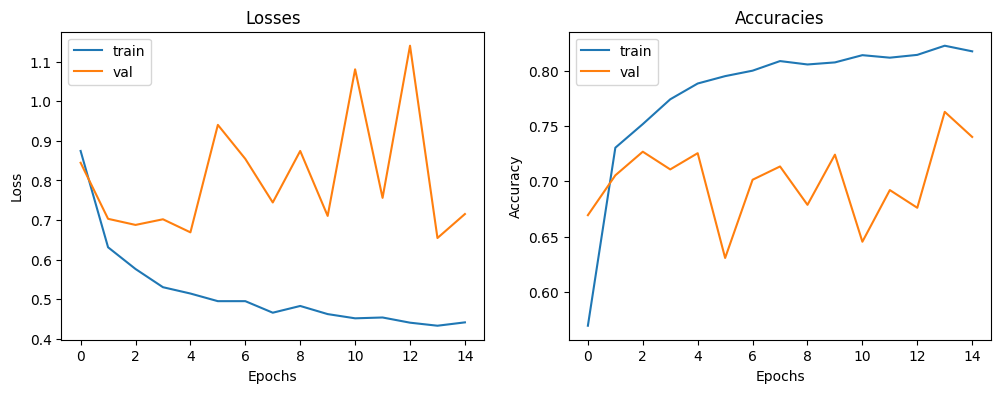

dropout rate = 0.3


Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:25<00:00,  4.64it/s]


loss = 0.913449353968475, val_loss =0.705342794633538, accuracy = 0.5206666588783264, val_accuracy = 0.7080000042915344


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:24<00:00,  4.90it/s]


loss = 0.6504830291922468, val_loss =0.880101526636492, accuracy = 0.7193333506584167, val_accuracy = 0.6213333010673523


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:25<00:00,  4.69it/s]


loss = 0.5750017439153, val_loss =0.7178647353912179, accuracy = 0.7634666562080383, val_accuracy = 0.6666666865348816


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:24<00:00,  4.92it/s]


loss = 0.525763359607964, val_loss =0.9465415643451284, accuracy = 0.7873333692550659, val_accuracy = 0.6453333497047424


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:25<00:00,  4.57it/s]


loss = 0.5223168561452763, val_loss =0.8242787695876029, accuracy = 0.7821333408355713, val_accuracy = 0.671999990940094


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:24<00:00,  4.90it/s]


loss = 0.5072530276694049, val_loss =0.6203912972583382, accuracy = 0.7889333367347717, val_accuracy = 0.7440000176429749


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:25<00:00,  4.65it/s]


loss = 0.4865358715752249, val_loss =0.7119533519608144, accuracy = 0.79666668176651, val_accuracy = 0.7093333005905151


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:24<00:00,  4.90it/s]


loss = 0.48611932272575037, val_loss =0.760290269728511, accuracy = 0.8013333678245544, val_accuracy = 0.6933333277702332


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:24<00:00,  4.80it/s]


loss = 0.4676780713702548, val_loss =0.8199733880320453, accuracy = 0.8109333515167236, val_accuracy = 0.6853333115577698


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:23<00:00,  4.93it/s]


loss = 0.4739839940055179, val_loss =0.8037982237770928, accuracy = 0.8069333434104919, val_accuracy = 0.6546666622161865


Epoch 11:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 118/118 [00:24<00:00,  4.80it/s]


loss = 0.462239528933272, val_loss =0.7299494081262178, accuracy = 0.809333324432373, val_accuracy = 0.7293333411216736


Epoch 12:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


loss = 0.46403664024358166, val_loss =1.1296760392001686, accuracy = 0.8116000294685364, val_accuracy = 0.6493332982063293


Epoch 13:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 118/118 [00:24<00:00,  4.86it/s]


loss = 0.4528501567672612, val_loss =0.8012942377294746, accuracy = 0.8125333189964294, val_accuracy = 0.6813333034515381


Epoch 14:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 118/118 [00:24<00:00,  4.90it/s]


loss = 0.442553488385226, val_loss =0.9864372125481511, accuracy = 0.8193333148956299, val_accuracy = 0.7013333439826965


Epoch 15:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 118/118 [00:24<00:00,  4.84it/s]


loss = 0.43539856903694374, val_loss =0.7524964420726447, accuracy = 0.8226667046546936, val_accuracy = 0.7199999690055847


<ipython-input-11-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


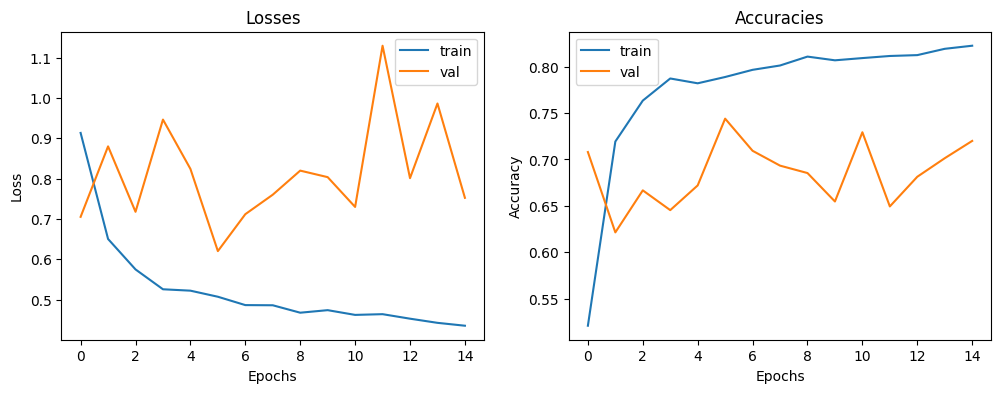

dropout rate = 0.4


Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:24<00:00,  4.91it/s]


loss = 0.9212277874480939, val_loss =0.9044355242584826, accuracy = 0.5273333191871643, val_accuracy = 0.5320000052452087


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:24<00:00,  4.85it/s]


loss = 0.6530411483436697, val_loss =1.3606676921626786, accuracy = 0.7206666469573975, val_accuracy = 0.5360000133514404


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


loss = 0.5731545073612848, val_loss =0.9312421789231387, accuracy = 0.7614666819572449, val_accuracy = 0.6333333253860474


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:24<00:00,  4.92it/s]


loss = 0.549082746762757, val_loss =1.7886649599577007, accuracy = 0.7749333381652832, val_accuracy = 0.47466665506362915


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:24<00:00,  4.84it/s]


loss = 0.5324422511735708, val_loss =1.1504296431801617, accuracy = 0.7789333462715149, val_accuracy = 0.5986666679382324


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


loss = 0.512786153933876, val_loss =1.1781165441695085, accuracy = 0.7885333299636841, val_accuracy = 0.5786666870117188


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:25<00:00,  4.58it/s]


loss = 0.5283977303632406, val_loss =0.8419613655570318, accuracy = 0.7798666954040527, val_accuracy = 0.6506666541099548


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:24<00:00,  4.88it/s]


loss = 0.49315036870014967, val_loss =0.9429046641306068, accuracy = 0.795199990272522, val_accuracy = 0.671999990940094


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:25<00:00,  4.63it/s]


loss = 0.49921734194694733, val_loss =0.8173625779308287, accuracy = 0.7914666533470154, val_accuracy = 0.718666672706604


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:25<00:00,  4.61it/s]


loss = 0.48811203175624174, val_loss =0.8473872574598357, accuracy = 0.7990666627883911, val_accuracy = 0.7146666646003723


Epoch 11:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 118/118 [00:26<00:00,  4.52it/s]


loss = 0.47524827252359086, val_loss =1.181494256238601, accuracy = 0.8078666925430298, val_accuracy = 0.5960000157356262


Epoch 12:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 118/118 [00:27<00:00,  4.31it/s]


loss = 0.46979828063562523, val_loss =1.1438886135234576, accuracy = 0.8033333420753479, val_accuracy = 0.6240000128746033


Epoch 13:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 118/118 [00:28<00:00,  4.12it/s]


loss = 0.45801162959198954, val_loss =0.8378273364108716, accuracy = 0.809066653251648, val_accuracy = 0.6946666836738586


Epoch 14:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 118/118 [00:27<00:00,  4.26it/s]


loss = 0.44926975110463174, val_loss =0.9583634644036266, accuracy = 0.815333366394043, val_accuracy = 0.6666666865348816


Epoch 15:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 118/118 [00:24<00:00,  4.85it/s]


loss = 0.44325639024538493, val_loss =0.8884039484785294, accuracy = 0.8101333379745483, val_accuracy = 0.6893333196640015


<ipython-input-11-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


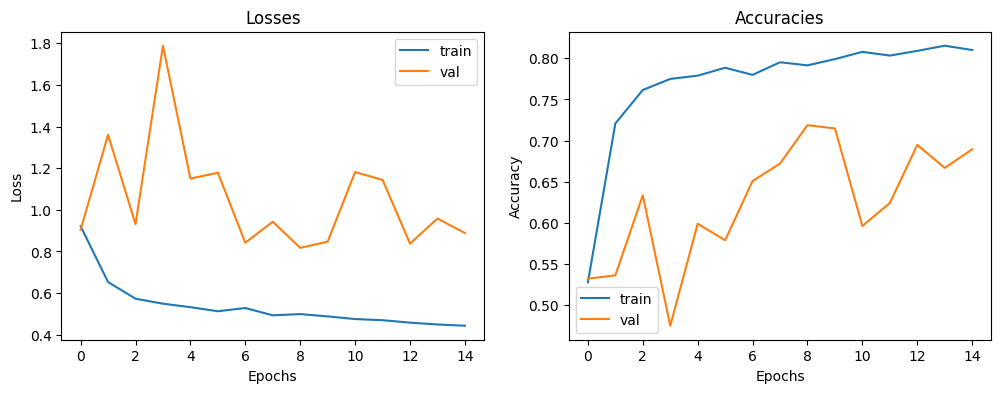

dropout rate = 0.5


Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:24<00:00,  4.84it/s]


loss = 0.9382310702843372, val_loss =0.9935307654276309, accuracy = 0.5206666588783264, val_accuracy = 0.4906666576862335


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:24<00:00,  4.87it/s]


loss = 0.6637756150907398, val_loss =1.001613701251251, accuracy = 0.7197333574295044, val_accuracy = 0.5586666464805603


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:24<00:00,  4.87it/s]


loss = 0.6088556446701104, val_loss =1.200459859905464, accuracy = 0.7518666982650757, val_accuracy = 0.5173333287239075


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:24<00:00,  4.83it/s]


loss = 0.5630141864379417, val_loss =1.014929192280629, accuracy = 0.7725333571434021, val_accuracy = 0.5759999752044678


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


loss = 0.5491368605621214, val_loss =0.8978859217252424, accuracy = 0.7752000093460083, val_accuracy = 0.5933333039283752


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:24<00:00,  4.77it/s]


loss = 0.5128149970079908, val_loss =1.4599550702760757, accuracy = 0.7941333651542664, val_accuracy = 0.5333333015441895


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:24<00:00,  4.87it/s]


loss = 0.515462089732078, val_loss =1.2783455222730824, accuracy = 0.7901333570480347, val_accuracy = 0.5613332986831665


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:26<00:00,  4.48it/s]


loss = 0.5118672064306177, val_loss =0.9263258994425891, accuracy = 0.7910666465759277, val_accuracy = 0.6626666784286499


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:24<00:00,  4.90it/s]


loss = 0.4944140927136857, val_loss =0.8044703992874164, accuracy = 0.8073333501815796, val_accuracy = 0.6773333549499512


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:25<00:00,  4.70it/s]


loss = 0.5100159092318424, val_loss =1.244212431386204, accuracy = 0.7905333638191223, val_accuracy = 0.6066666841506958


Epoch 11:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


loss = 0.48528407578580796, val_loss =1.0118649484691533, accuracy = 0.8013333678245544, val_accuracy = 0.6106666326522827


Epoch 12:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 118/118 [00:24<00:00,  4.81it/s]


loss = 0.4922713366860674, val_loss =1.0617663807497066, accuracy = 0.7969333529472351, val_accuracy = 0.6266666650772095


Epoch 13:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 118/118 [00:24<00:00,  4.91it/s]


loss = 0.4744853223207202, val_loss =1.1422865946538694, accuracy = 0.8070666790008545, val_accuracy = 0.6346666812896729


Epoch 14:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 118/118 [00:24<00:00,  4.87it/s]


loss = 0.4653183189704435, val_loss =1.0812326491523903, accuracy = 0.8086666464805603, val_accuracy = 0.6586666703224182


Epoch 15:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 118/118 [00:24<00:00,  4.86it/s]


loss = 0.47047926134752927, val_loss =1.372103942590015, accuracy = 0.8078666925430298, val_accuracy = 0.5666666626930237


<ipython-input-11-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


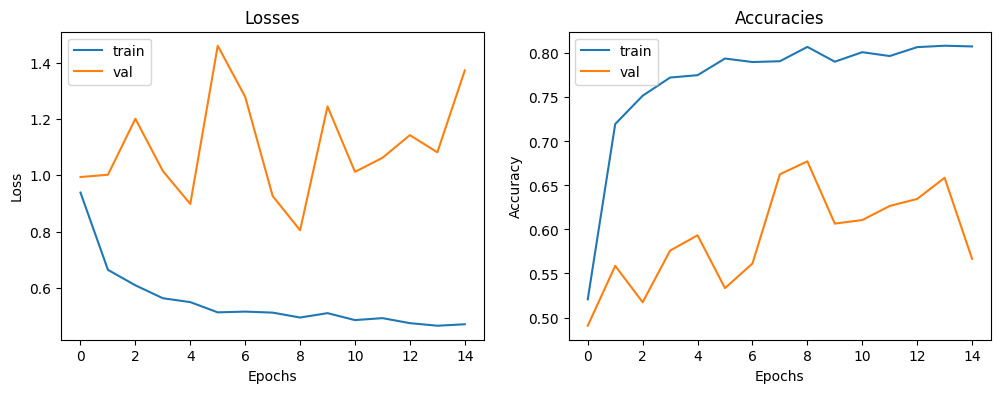

dropout rate = 0.6


In [ ]:
bidirectional=True
num_layers=4
hidden_size1=256
hidden_size2=256
learning_rate=0.0003
drop_rates=[0,0.1,0.2,0.3,0.4,0.5,0.6]
for drop_rate in drop_rates:
  model=RNN_AraBERT(hidden_size1,hidden_size2,num_layers,bidirectional,drop_rate).to(device,non_blocking=True)
  optimizer=optim.Adam(model.parameters(),lr=learning_rate)
  train(model,epoch,optimizer,criterion,full_dataloader,test_loader)
  print(f'dropout rate = {drop_rate}')
  model_name='MARBERT+LSTM'
  test_and_report(model,test_loader,model_name)

Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1: 100%|██████████| 118/118 [00:25<00:00,  4.70it/s]


loss = 0.9268326453879703, val_loss =0.8659196454876413, accuracy = 0.5273333191871643, val_accuracy = 0.6026666760444641


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2: 100%|██████████| 118/118 [00:26<00:00,  4.41it/s]


loss = 0.6693164153215045, val_loss =0.7395493545455806, accuracy = 0.7124000191688538, val_accuracy = 0.7160000205039978


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3: 100%|██████████| 118/118 [00:28<00:00,  4.10it/s]


loss = 0.5874120637998173, val_loss =0.7691381547335987, accuracy = 0.751466691493988, val_accuracy = 0.6946666836738586


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4: 100%|██████████| 118/118 [00:24<00:00,  4.87it/s]


loss = 0.5503091091727866, val_loss =0.7249427953834328, accuracy = 0.7698667049407959, val_accuracy = 0.6773333549499512


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5: 100%|██████████| 118/118 [00:24<00:00,  4.81it/s]


loss = 0.5295733986035294, val_loss =0.8506269573544146, accuracy = 0.7820000052452087, val_accuracy = 0.699999988079071


Epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6: 100%|██████████| 118/118 [00:25<00:00,  4.63it/s]


loss = 0.49386137521454826, val_loss =0.6608554687061743, accuracy = 0.8004000186920166, val_accuracy = 0.7453333139419556


Epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7: 100%|██████████| 118/118 [00:25<00:00,  4.59it/s]


loss = 0.4983116490169531, val_loss =0.7048570447229355, accuracy = 0.7981333136558533, val_accuracy = 0.7253333330154419


Epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8: 100%|██████████| 118/118 [00:23<00:00,  4.95it/s]


loss = 0.48120305081662945, val_loss =0.7721436953947557, accuracy = 0.8046666979789734, val_accuracy = 0.6786666512489319


Epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9: 100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


loss = 0.46510232761211534, val_loss =0.6886627946755586, accuracy = 0.8101333379745483, val_accuracy = 0.7333333492279053


Epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10: 100%|██████████| 118/118 [00:25<00:00,  4.58it/s]


loss = 0.46738621456517787, val_loss =0.8248780425574164, accuracy = 0.8098666667938232, val_accuracy = 0.6759999990463257


Epoch 11:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11: 100%|██████████| 118/118 [00:23<00:00,  4.95it/s]


loss = 0.45508344502989423, val_loss =0.9405183321633176, accuracy = 0.8078666925430298, val_accuracy = 0.6599999666213989


Epoch 12:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12: 100%|██████████| 118/118 [00:24<00:00,  4.84it/s]


loss = 0.44126875629612866, val_loss =0.703072598614871, accuracy = 0.8184000253677368, val_accuracy = 0.734666645526886


Epoch 13:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13: 100%|██████████| 118/118 [00:24<00:00,  4.91it/s]


loss = 0.43231546711095653, val_loss =0.8713960282854806, accuracy = 0.8234666585922241, val_accuracy = 0.7039999961853027


Epoch 14:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14: 100%|██████████| 118/118 [00:25<00:00,  4.68it/s]


loss = 0.4190118922940463, val_loss =0.6483605697900545, accuracy = 0.82586669921875, val_accuracy = 0.762666642665863


Epoch 15:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15: 100%|██████████| 118/118 [00:24<00:00,  4.90it/s]


loss = 0.4290424698251807, val_loss =0.7236820654633304, accuracy = 0.8214666843414307, val_accuracy = 0.7333333492279053


<ipython-input-21-c9d6db1c648f>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


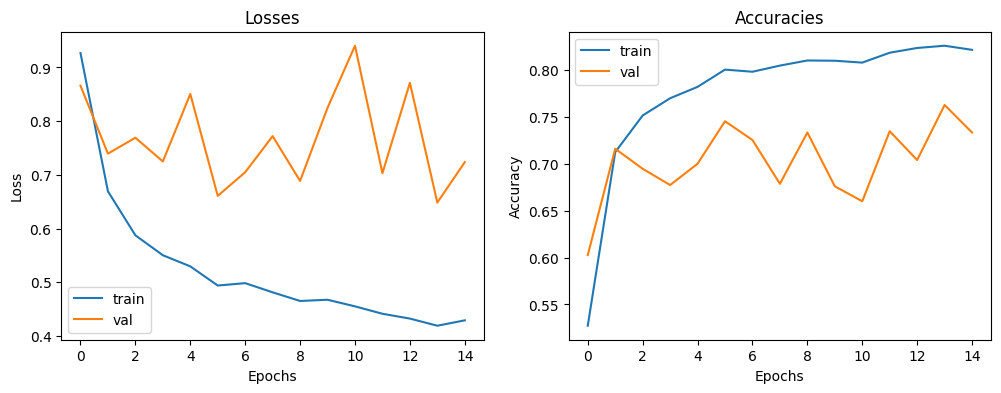

Test correct = 550

Test total dataitem = 750

Test Accuracy = 0.7333333492279053

              precision    recall  f1-score   support

    negative       0.84      0.67      0.75       250
     neutral       0.64      0.81      0.71       250
    positive       0.77      0.72      0.74       250

    accuracy                           0.73       750
   macro avg       0.75      0.73      0.73       750
weighted avg       0.75      0.73      0.73       750



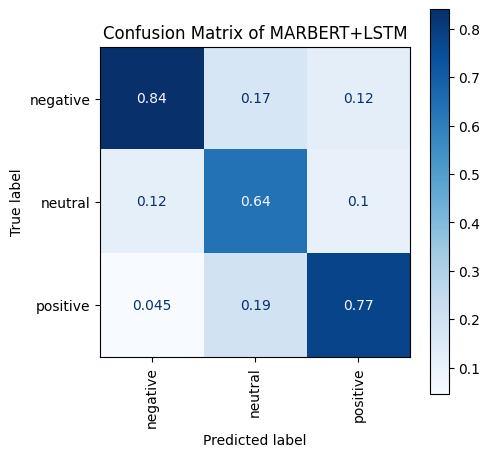

In [ ]:
bidirectional=True
num_layers=4
hidden_size1=256
hidden_size2=256
learning_rate=0.0003
droprate=0.3
epoch=15
model=RNN_AraBERT(hidden_size1,hidden_size2,num_layers,bidirectional,droprate).to(device,non_blocking=True)
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
train(model,epoch,optimizer,criterion,full_dataloader,test_loader)
model_name='MARBERT+LSTM'
test_and_report(model,test_loader,model_name)

In [ ]:
bidirectional=False
num_layers=1
hidden_size1=128
hidden_size2=256
learning_rate=0.0003
droprate=0.4
epoch=10
model=RNN_AraBERT(hidden_size1,hidden_size2,num_layers,bidirectional,droprate).to(device,non_blocking=True)
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
train(model,epoch,optimizer,criterion,full_dataloader,test_loader)
model_name='MARBERT+LSTM'
test_and_report(model,test_loader,model_name)

---
---
---
---